In [ ]:
import argparse
import pandas as pd
import pickle
from scripts.imports import *
from scripts.parallel_blocks import *
from scripts.FSC_dataframe_phoreal import FSC_dataframe

# Function to parse command line arguments
def parse_args():
    parser = argparse.ArgumentParser(description="Generate and save a concatenated dataframe from multiple directories.")
    parser.add_argument('output_pickle', type=str, help='Name of the output pickle file (without extension)')
    parser.add_argument('--width', type=float, default=5, help='Width of the box (default: 0.05)')
    parser.add_argument('--height', type=float, default=5, help='Height of the box (default: 0.05)')
    parser.add_argument('--small_box', type=float, default=1, help='Size of the small box (default: 0.005)')
    parser.add_argument('--threshold', type=int, default=1, help='Data threshold value (default: 2)')
    parser.add_argument('--alt_thresh', type=int, default=80, help='Altitude threshold value (default: 90)')
    parser.add_argument('--rebinned', type=int, default=0, help='Rebinned into specified meter resolution')
    parser.add_argument('--method', type=str, default='normal', help='Method for probability distribution')
    parser.add_argument('--site', type=str, default='all', help='restrict to specific site if necessary')
    parser.add_argument('--outlier_removal', type=float, default=0, help='outlier_removal by z_score')
    return parser.parse_args()

# Main function
def main():

    output_pickle = 'dataset'

    dirpaths = [
        # '../data_store/data/sodankyla_full/',
        # '../data_store/data/delta_junction/',
        # '../data_store/data/marcell_MN/',
        # '../data_store/data/lacclair/',
        # '../data_store/data/torgnon/',
        '../data_store/data/oregon_yp/'
    ]
        
    csv_path = 'snow_cam_details.csv'
    excel_df = pd.read_csv(csv_path).drop('Image', axis=1)
    
    output_pickle_file = f"{output_pickle}.pkl"
    checkpoint_file = f"{output_pickle}_checkpoint.pkl"

    width=5
    height=5
    threshold=1
    small_box=10
    alt_thresh=80
    rebinned=30
    method='bimodal'
    outlier_removal=2
    loss='linear'
    
    # Load progress if checkpoint exists
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'rb') as f:
            processed_indices, partial_df = pickle.load(f)
        print(f"Resuming from checkpoint. Already processed: {processed_indices}")
    else:
        processed_indices = set()
        partial_df = pd.DataFrame()

    for dir_idx, dirpath in enumerate(dirpaths):
        foldername = dirpath.split('/')[-2]
        
        all_ATL03, all_ATL08 = track_pairs(dirpath)
        total_indices = len(all_ATL03)

        for i in range(total_indices):
            # Skip already processed indices
            if (dir_idx, i) in processed_indices:
                continue

            try:
                filedate = datetime_to_date(parse_filename_datetime(all_ATL03[i]))

                if ((excel_df['Date'] == filedate) & (excel_df['Camera'] == foldername)).any():
                    coords = (excel_df.loc[(excel_df['Date'] == filedate) & (excel_df['Camera'] == foldername), 'x_coord'].iloc[0],\
                              excel_df.loc[(excel_df['Date'] == filedate) & (excel_df['Camera'] == foldername), 'y_coord'].iloc[0])
                    altitude = excel_df.loc[(excel_df['Date'] == filedate) & (excel_df['Camera'] == foldername), 'Altitude'].iloc[0]
                    
                    df = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i],
                                                                coords = coords,width=width,height=height,
                                                                file_index = i,loss=loss, graph_detail=0,
                                                               altitude=altitude, threshold=threshold, small_box=small_box,\
                                                                  alt_thresh=alt_thresh, rebinned=rebinned, method=method,
                                                                  outlier_removal=outlier_removal)
                                                                  
                    df['FSC'] = excel_df.loc[(excel_df['Date'] == filedate) & (excel_df['Camera'] == foldername), 'FSC'].iloc[0]
                    df['TreeSnow'] = excel_df.loc[(excel_df['Date']==filedate) & (excel_df['Camera']==foldername), 'Tree Snow'].iloc[0]

                    # Append new data to the partial dataframe
                    partial_df = pd.concat([partial_df, df], ignore_index=True)

                    # print(partial_df)

                    # Update the processed indices
                    processed_indices.add((dir_idx, i))

                    # Save checkpoint after each index
                    with open(checkpoint_file, 'wb') as f:
                        pickle.dump((processed_indices, partial_df), f)
                    print(f"Checkpoint saved to {checkpoint_file}")

            except Exception as e:
                print(f"Error processing {dirpath} index {i}: {e}")
                continue

    # Save final results
    partial_df.reset_index(drop=True, inplace=True)
    partial_df.to_pickle(output_pickle_file)

    # Clean up checkpoint
    if os.path.exists(checkpoint_file):
        os.remove(checkpoint_file)

    print(f"Dataframe saved to {output_pickle_file}")

if __name__ == '__main__':
    main()

Resuming from checkpoint. Already processed: {(0, 1), (0, 2), (0, 0)}
../data_store/data/oregon_yp/ 3


# Sodankyla

#### Arctan loss, f_scale = .1

Nothing in rebinned section for sodankyla_full file 0's beam 3.
Nothing in rebinned section for sodankyla_full file 0's beam 4.
Nothing in rebinned section for sodankyla_full file 0's beam 5.
Nothing in rebinned section for sodankyla_full file 0's beam 6.


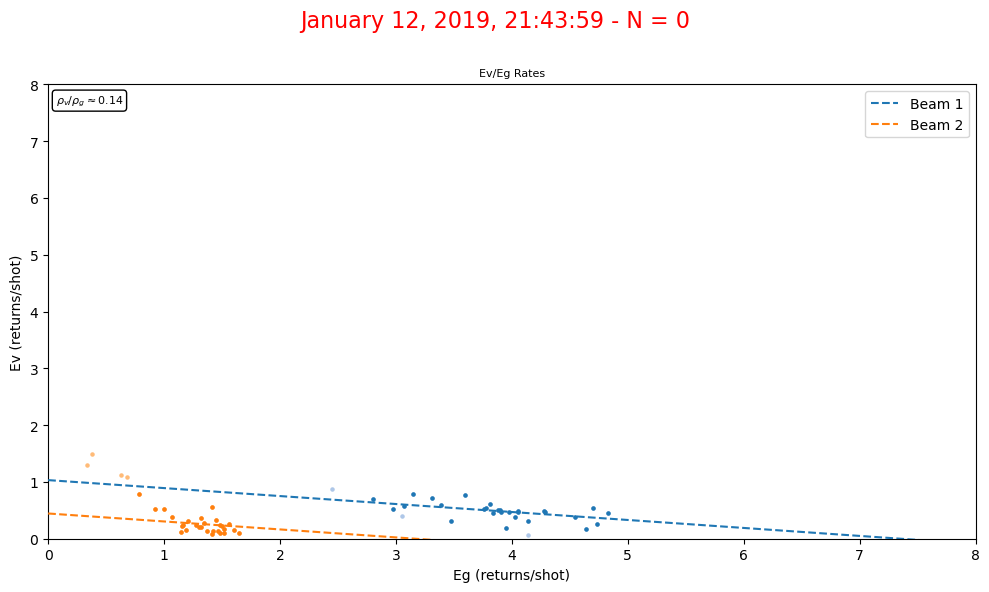

           camera        date        lat        lon      pvpg        pv  \
0  sodankyla_full  12/01/2019  67.362058  26.634739  0.140336  0.733427   

         pg  data_quantity         snr  msw_flag segment_landcover  \
0  5.226226             32  129.116048       1.0       (111.0, 56)   

   cloud_flag_atm  layer_flag  
0             1.0         1.0  
Nothing in rebinned section for sodankyla_full file 1's beam 1.
Nothing in rebinned section for sodankyla_full file 1's beam 2.


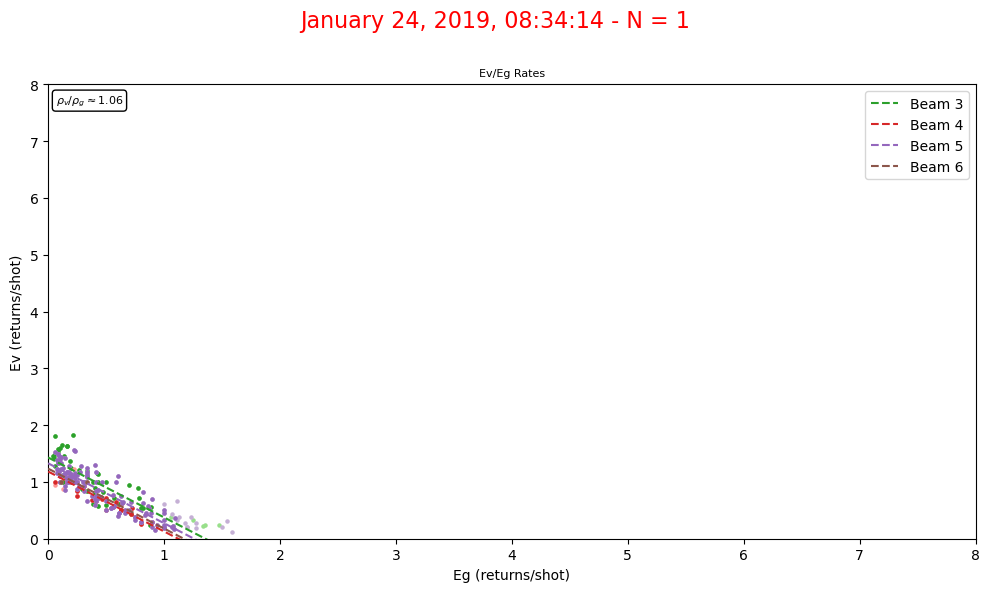

           camera        date        lat        lon      pvpg        pv  \
0  sodankyla_full  24/01/2019  67.362058  26.634739  1.055122  1.333418   

         pg  data_quantity       snr  msw_flag segment_landcover  \
0  1.263757            131  0.871018       3.0      (111.0, 160)   

   cloud_flag_atm  layer_flag  
0        1.342466     0.96347  
Nothing in rebinned section for sodankyla_full file 2's beam 2.
Nothing in rebinned section for sodankyla_full file 2's beam 3.
Nothing in rebinned section for sodankyla_full file 2's beam 4.
Nothing in rebinned section for sodankyla_full file 2's beam 5.
Nothing in rebinned section for sodankyla_full file 2's beam 6.


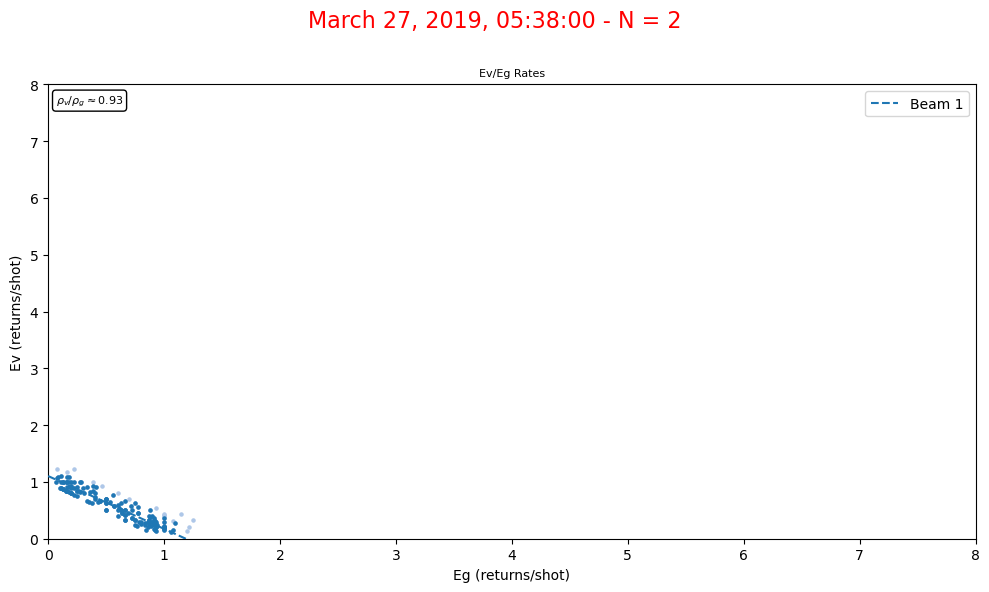

           camera        date        lat        lon      pvpg        pv  \
0  sodankyla_full  27/03/2019  67.362058  26.634739  0.929781  1.103368   

         pg  data_quantity       snr  msw_flag segment_landcover  \
0  1.186697            159  0.117701   2.08805      (111.0, 155)   

   cloud_flag_atm  layer_flag  
0        2.660377         1.0  
Nothing in rebinned section for sodankyla_full file 3's beam 5.
Nothing in rebinned section for sodankyla_full file 3's beam 6.


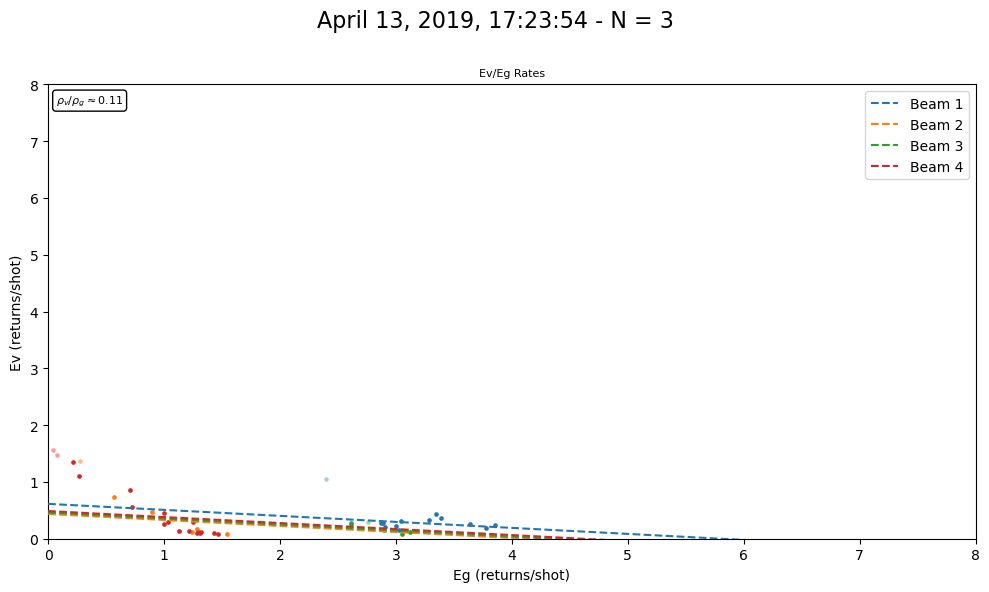

           camera        date        lat        lon      pvpg        pv  \
0  sodankyla_full  13/04/2019  67.362058  26.634739  0.105725  0.520287   

         pg  data_quantity       snr  msw_flag segment_landcover  \
0  4.921115             18  7.188325       1.0       (111.0, 36)   

   cloud_flag_atm  layer_flag  
0             1.0    0.136364  
Nothing in rebinned section for sodankyla_full file 4's beam 1.
Nothing in rebinned section for sodankyla_full file 4's beam 2.
Nothing in rebinned section for sodankyla_full file 4's beam 3.
Nothing in rebinned section for sodankyla_full file 4's beam 4.


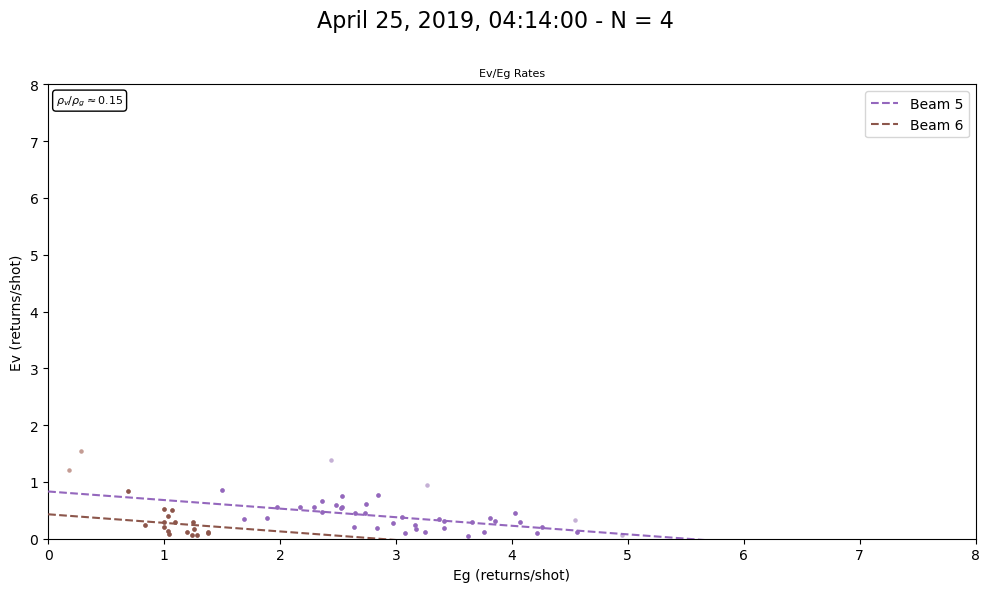

           camera        date        lat        lon      pvpg        pv  \
0  sodankyla_full  25/04/2019  67.362058  26.634739  0.150965  0.704645   

         pg  data_quantity       snr  msw_flag segment_landcover  \
0  4.667616             41  1.302726       0.0       (111.0, 50)   

   cloud_flag_atm  layer_flag  
0             0.0         0.0  
Nothing in rebinned section for sodankyla_full file 5's beam 1.
Nothing in rebinned section for sodankyla_full file 5's beam 2.
Nothing in rebinned section for sodankyla_full file 5's beam 3.
Nothing in rebinned section for sodankyla_full file 5's beam 4.


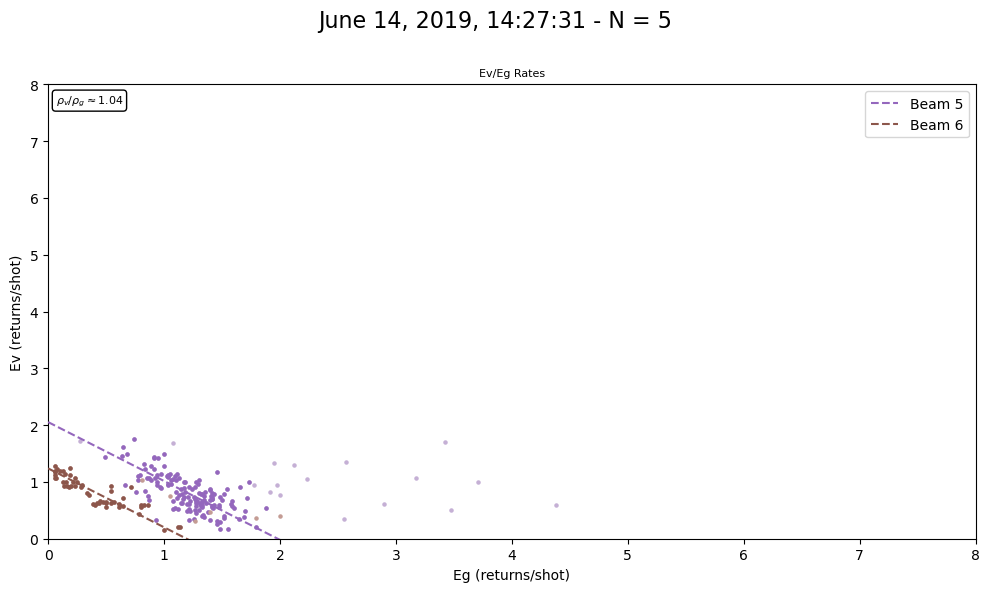

           camera        date        lat        lon      pvpg       pv  \
0  sodankyla_full  14/06/2019  67.362058  26.634739  1.037077  1.83936   

       pg  data_quantity       snr  msw_flag segment_landcover  \
0  1.7736            163  0.880557  0.782805      (111.0, 219)   

   cloud_flag_atm  layer_flag  
0        0.294118    0.022624  


/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope =

Nothing in rebinned section for sodankyla_full file 6's beam 3.
Nothing in rebinned section for sodankyla_full file 6's beam 4.
Nothing in rebinned section for sodankyla_full file 6's beam 5.
Nothing in rebinned section for sodankyla_full file 6's beam 6.


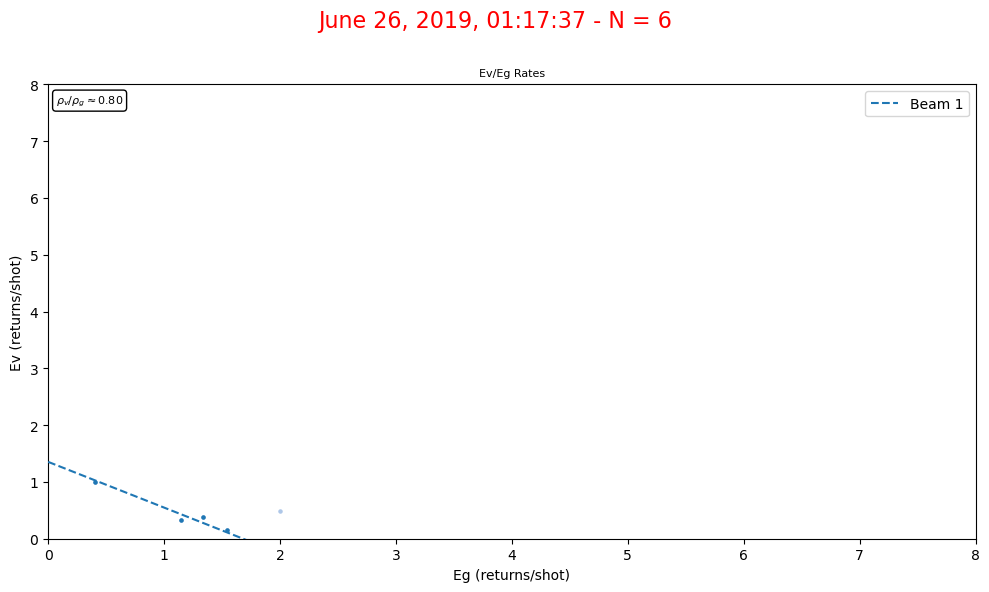

           camera        date        lat        lon      pvpg        pv  \
0  sodankyla_full  26/06/2019  67.362058  26.634739  0.804795  1.353104   

         pg  data_quantity       snr  msw_flag segment_landcover  \
0  1.681302              5  0.350685       2.0        (111.0, 4)   

   cloud_flag_atm  layer_flag  
0             2.0         1.0  


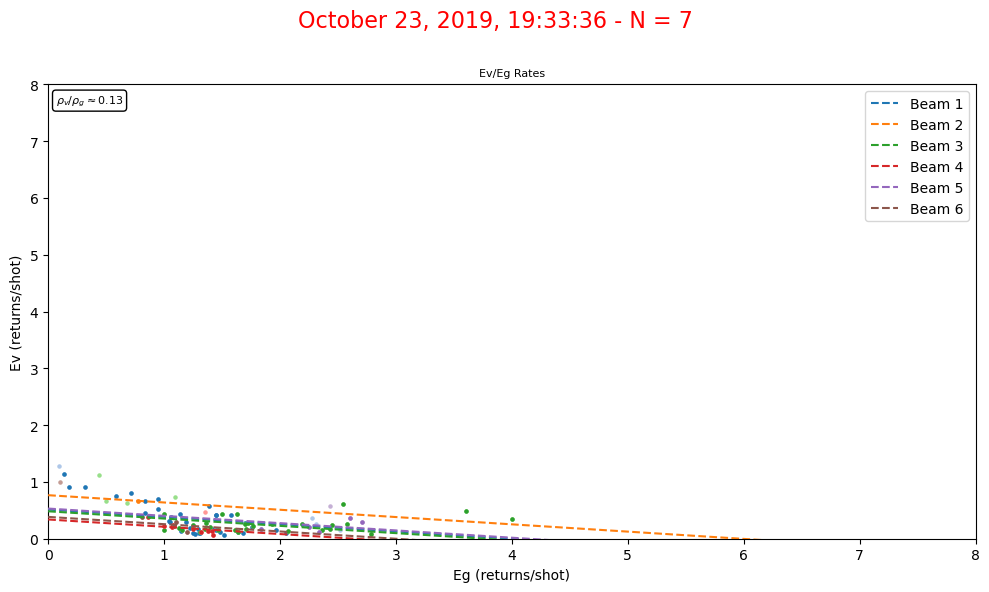

           camera        date        lat        lon      pvpg        pv  \
0  sodankyla_full  23/10/2019  67.362058  26.634739  0.128264  0.481657   

         pg  data_quantity       snr  msw_flag segment_landcover  \
0  3.755204             40  1.384346  2.428571       (111.0, 94)   

   cloud_flag_atm  layer_flag  
0         1.44898         1.0  
Nothing in rebinned section for sodankyla_full file 8's beam 1.
Nothing in rebinned section for sodankyla_full file 8's beam 2.


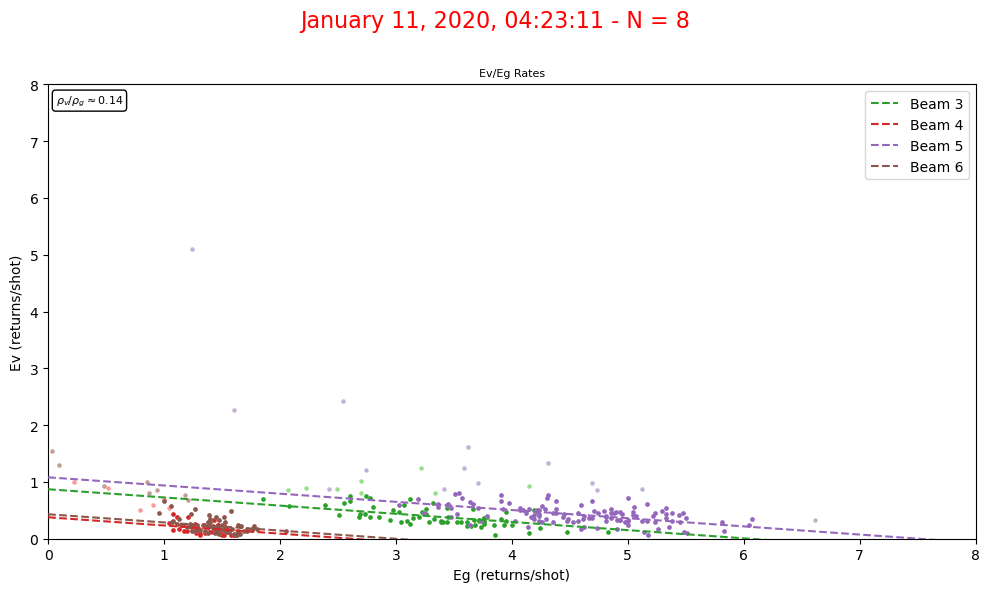

           camera        date        lat        lon      pvpg        pv  \
0  sodankyla_full  11/01/2020  67.362058  26.634739  0.143959  0.778151   

         pg  data_quantity         snr  msw_flag segment_landcover  \
0  5.405358            133  237.751276       1.0      (111.0, 291)   

   cloud_flag_atm  layer_flag  
0             2.0         1.0  
Nothing in rebinned section for sodankyla_full file 9's beam 1.
Nothing in rebinned section for sodankyla_full file 9's beam 2.
Nothing in rebinned section for sodankyla_full file 9's beam 3.
Nothing in rebinned section for sodankyla_full file 9's beam 4.
Nothing in rebinned section for sodankyla_full file 9's beam 5.
Nothing in rebinned section for sodankyla_full file 9's beam 6.
Empty DataFrame
Columns: [camera, date, lat, lon, pvpg, pv, pg, data_quantity, snr, msw_flag, segment_landcover, cloud_flag_atm, layer_flag]
Index: []
Nothing in rebinned section for sodankyla_full file 10's beam 1.
Nothing in rebinned section for sodankyla_fu

KeyboardInterrupt: 

In [2]:
from scripts.parallel_blocks import *

dirpath = '../data_store/data/sodankyla_full/'

all_ATL03, all_ATL08, failed_ATL03 = track_pairs(dirpath, failed=True)
N = len(all_ATL03)

coords = (26.634154, 67.361833)

for i in range(N):
    data = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i], coords=coords, width=4,height=4,file_index=i, alt_thresh=80,\
                         altitude=185, threshold=1, small_box=8.05, graph_detail=1, loss='linear', rebinned=30, f_scale=.05,\
                         outlier_removal=0.1,method='bimodal')

    df_grouped = data.groupby(['camera','date','lat','lon', 'beam']).agg({
        'pvpg': 'mean',
        'pv': 'mean',
        'pg': 'mean',
        'data_quantity': 'max',
        'snr': 'mean',
        'msw_flag': 'mean',
        'segment_landcover': scipy.stats.mode,
        'cloud_flag_atm': 'mean',
        'layer_flag': 'mean'
    }).reset_index()
    
    print(df_grouped)

# Delta Junction

Nothing in rebinned section for delta_junction file 0's beam 3.
Nothing in rebinned section for delta_junction file 0's beam 4.
Nothing in rebinned section for delta_junction file 0's beam 5.
Nothing in rebinned section for delta_junction file 0's beam 6.


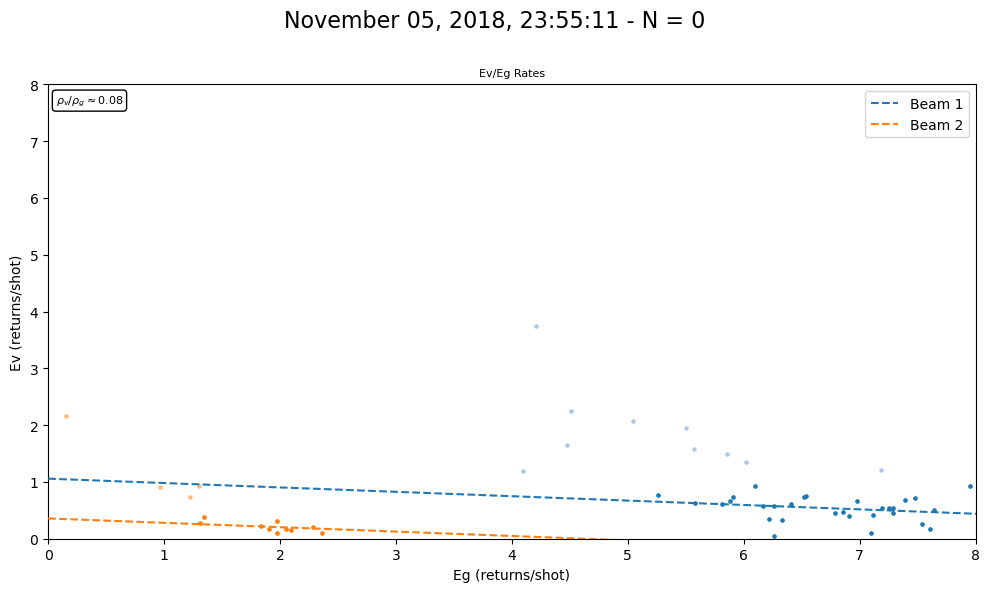

Nothing in rebinned section for delta_junction file 1's beam 5.
Nothing in rebinned section for delta_junction file 1's beam 6.


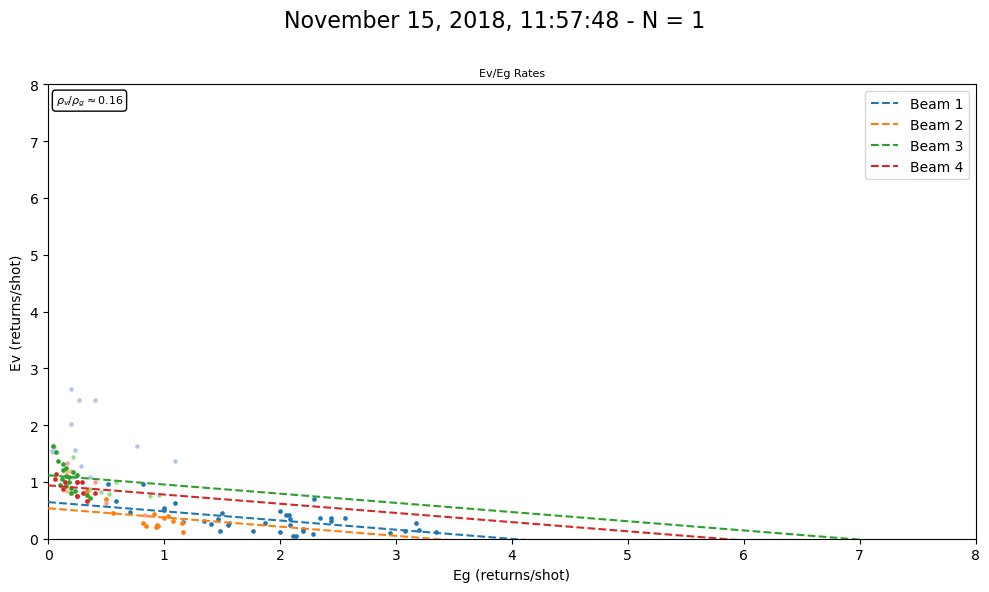

Nothing in rebinned section for delta_junction file 2's beam 1.
Nothing in rebinned section for delta_junction file 2's beam 2.


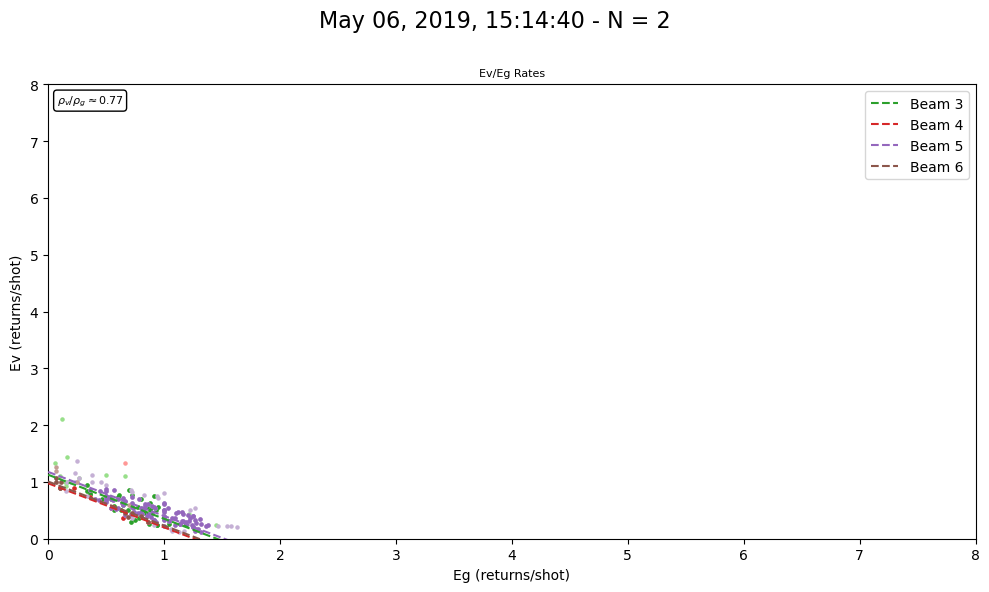

Nothing in rebinned section for delta_junction file 3's beam 1.
Nothing in rebinned section for delta_junction file 3's beam 2.


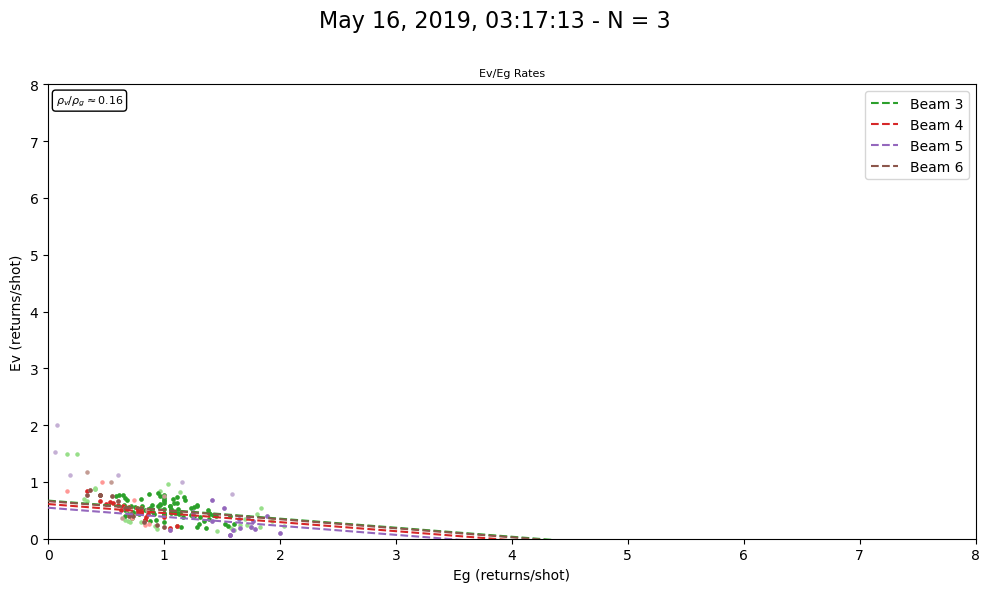

Nothing in rebinned section for delta_junction file 4's beam 1.
Nothing in rebinned section for delta_junction file 4's beam 2.
Nothing in rebinned section for delta_junction file 4's beam 3.
Nothing in rebinned section for delta_junction file 4's beam 4.


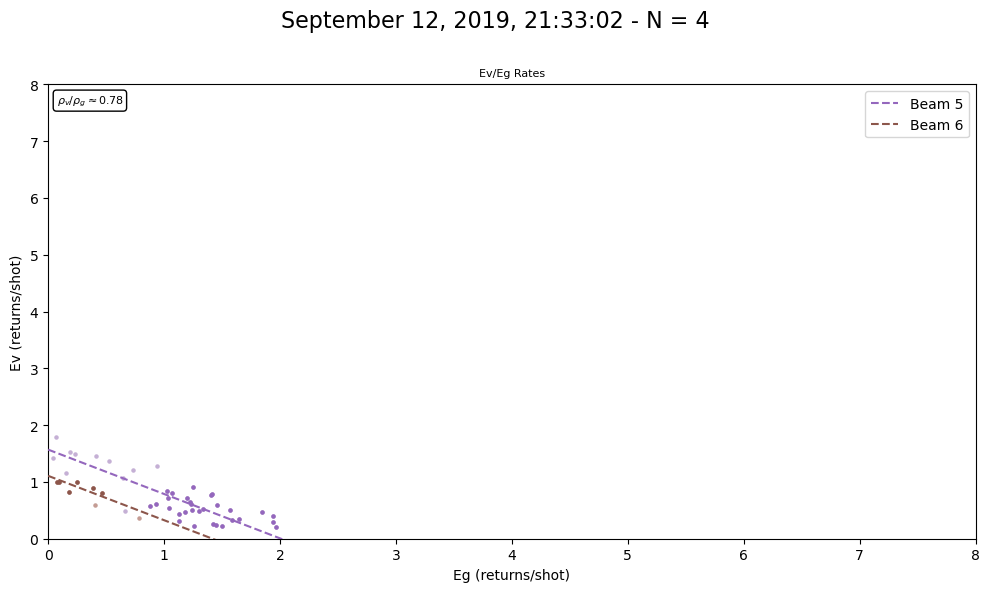

Nothing in rebinned section for delta_junction file 5's beam 1.
Nothing in rebinned section for delta_junction file 5's beam 2.
Nothing in rebinned section for delta_junction file 5's beam 3.
Nothing in rebinned section for delta_junction file 5's beam 4.
Nothing in rebinned section for delta_junction file 5's beam 6.


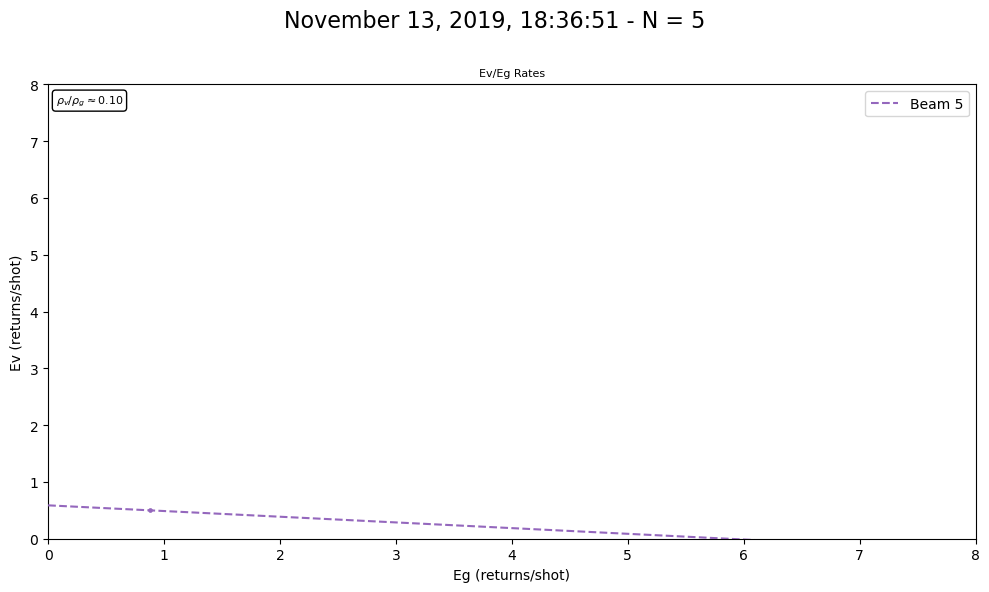

Nothing in rebinned section for delta_junction file 6's beam 1.
Nothing in rebinned section for delta_junction file 6's beam 2.
Nothing in rebinned section for delta_junction file 6's beam 3.
Nothing in rebinned section for delta_junction file 6's beam 4.


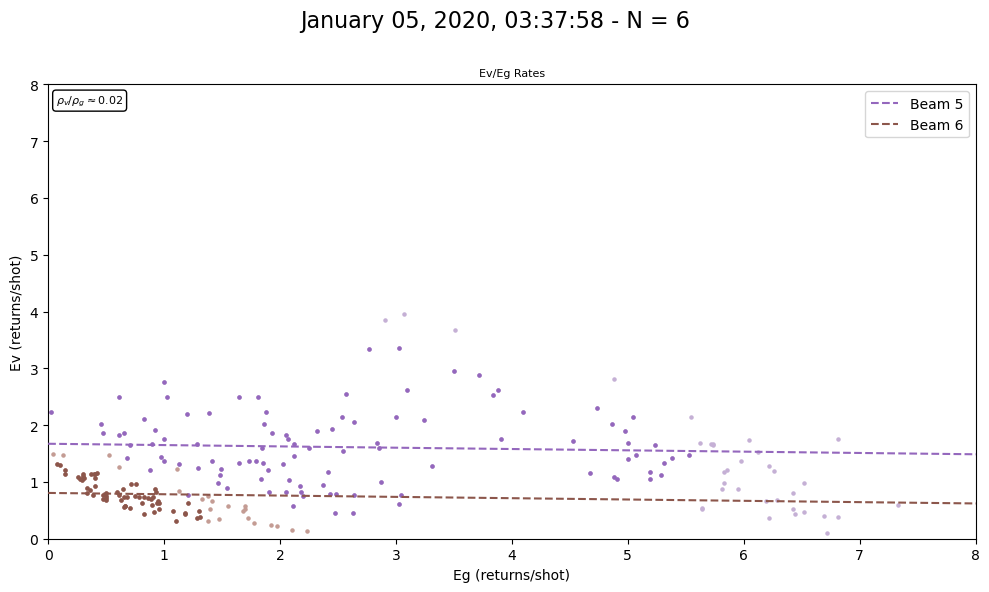

Nothing in rebinned section for delta_junction file 7's beam 1.
Nothing in rebinned section for delta_junction file 7's beam 2.
Nothing in rebinned section for delta_junction file 7's beam 3.
Nothing in rebinned section for delta_junction file 7's beam 4.
Nothing in rebinned section for delta_junction file 7's beam 5.
Nothing in rebinned section for delta_junction file 7's beam 6.


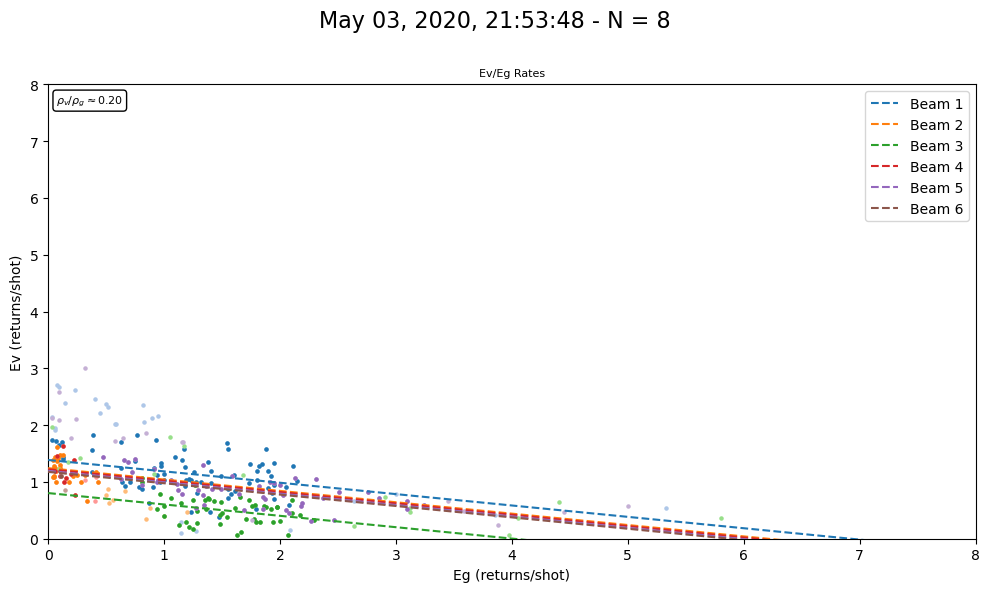

Nothing in rebinned section for delta_junction file 9's beam 1.
Nothing in rebinned section for delta_junction file 9's beam 2.


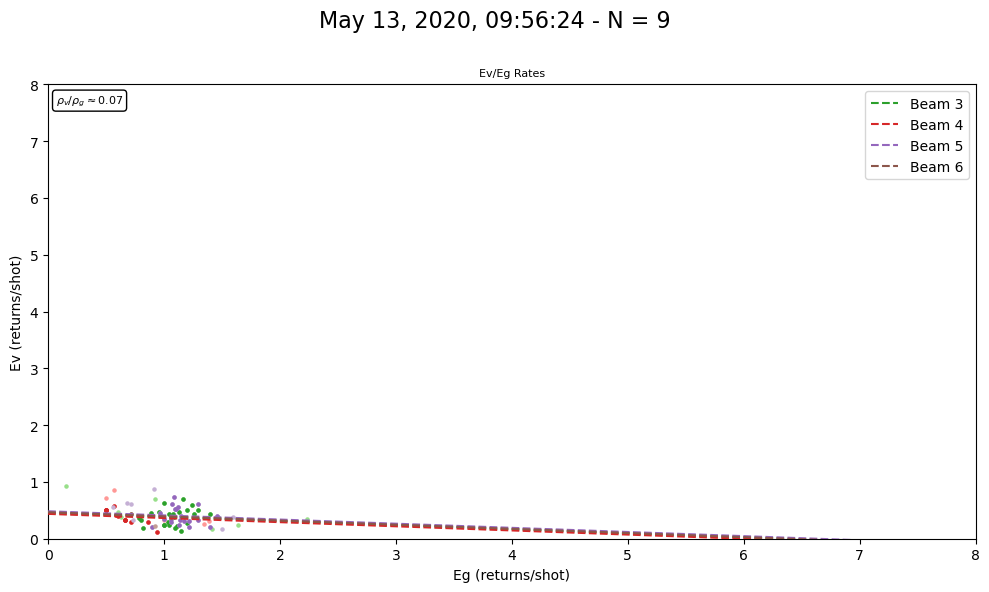

Nothing in rebinned section for delta_junction file 10's beam 3.
Nothing in rebinned section for delta_junction file 10's beam 4.
Nothing in rebinned section for delta_junction file 10's beam 5.
Nothing in rebinned section for delta_junction file 10's beam 6.


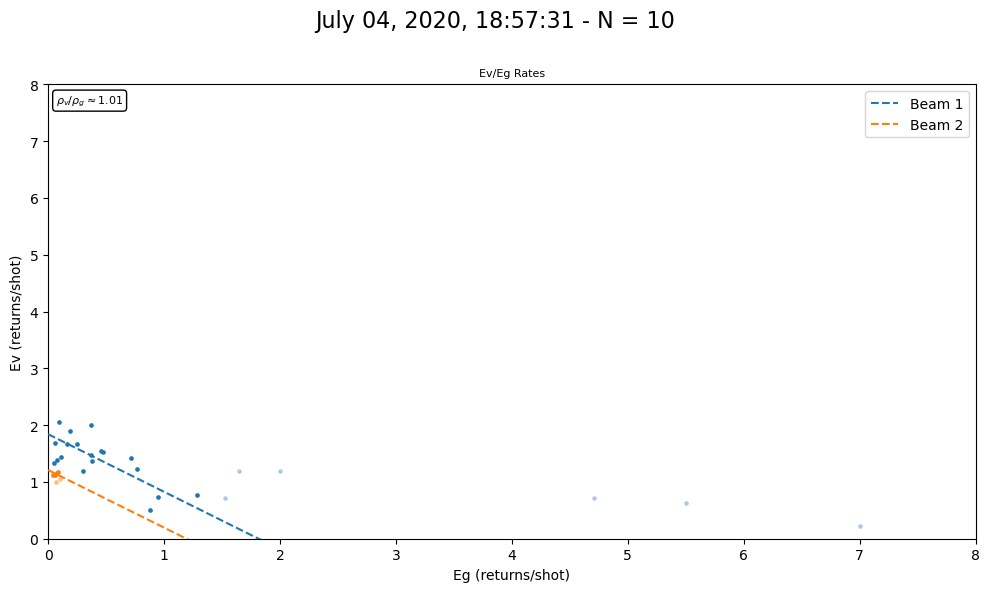

Nothing in rebinned section for delta_junction file 11's beam 1.
Nothing in rebinned section for delta_junction file 11's beam 2.


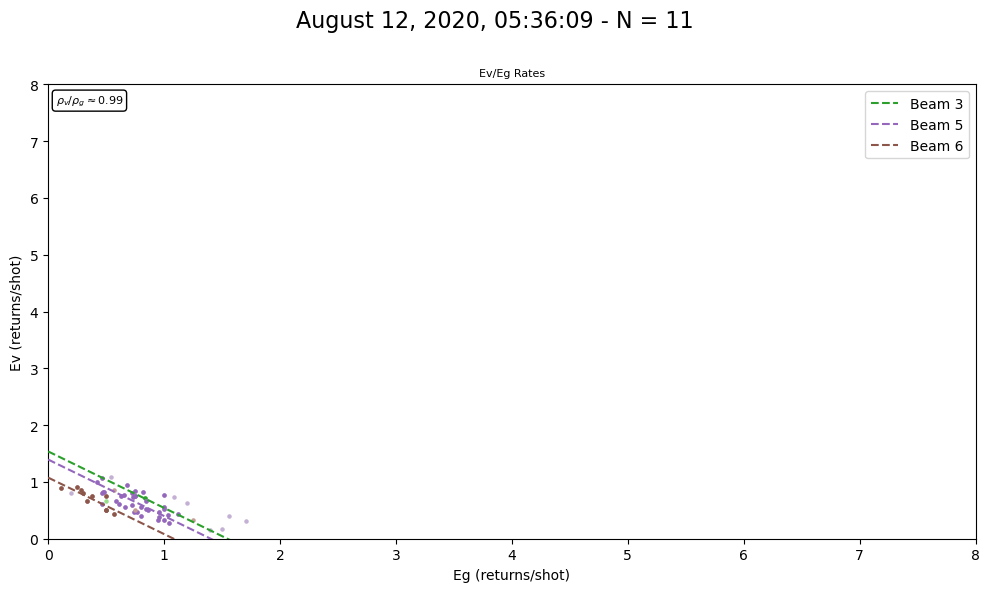

Nothing in rebinned section for delta_junction file 12's beam 1.
Nothing in rebinned section for delta_junction file 12's beam 2.
Nothing in rebinned section for delta_junction file 12's beam 5.
Nothing in rebinned section for delta_junction file 12's beam 6.


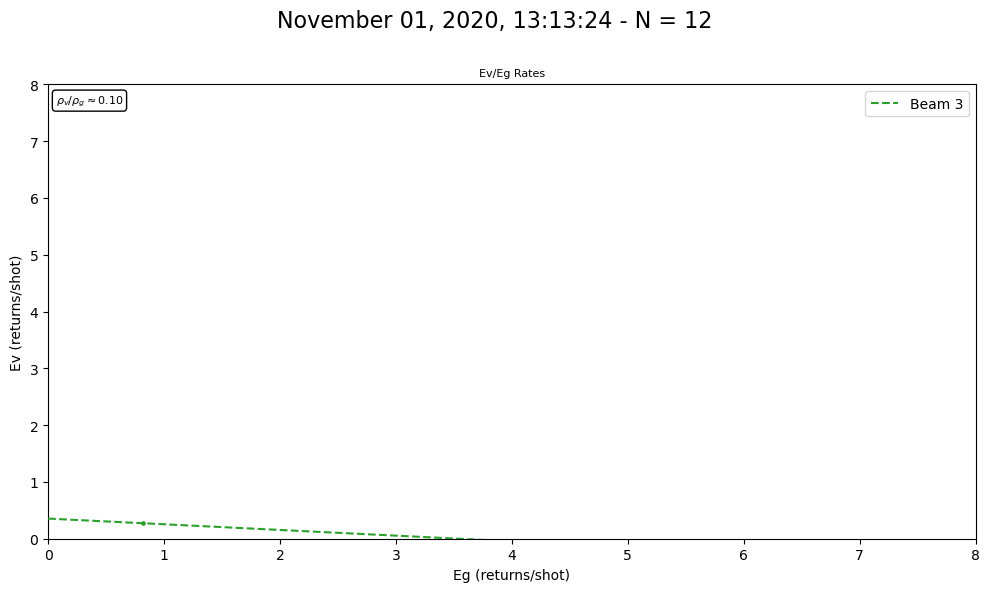

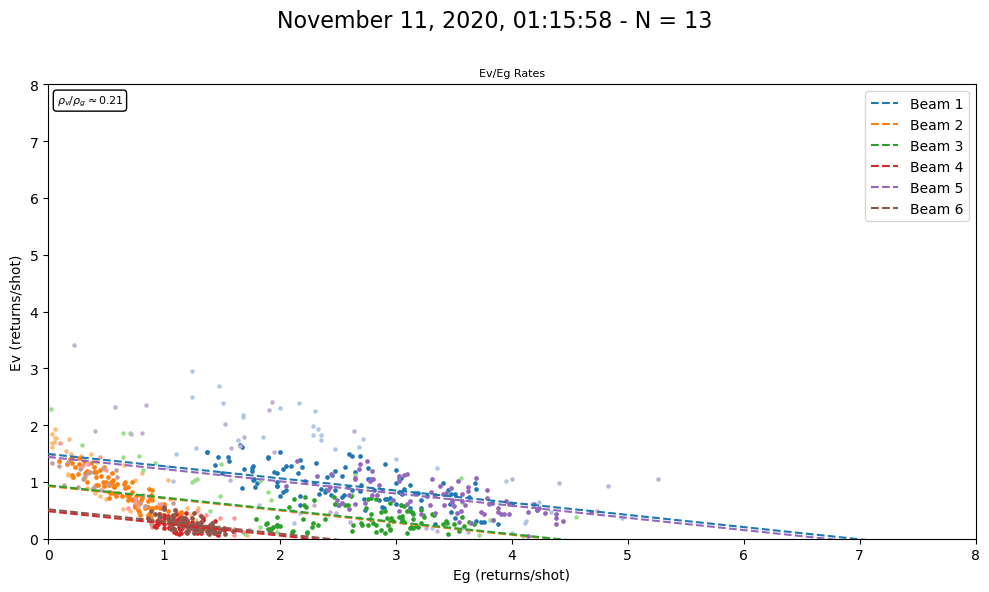

Nothing in rebinned section for delta_junction file 14's beam 5.
Nothing in rebinned section for delta_junction file 14's beam 6.


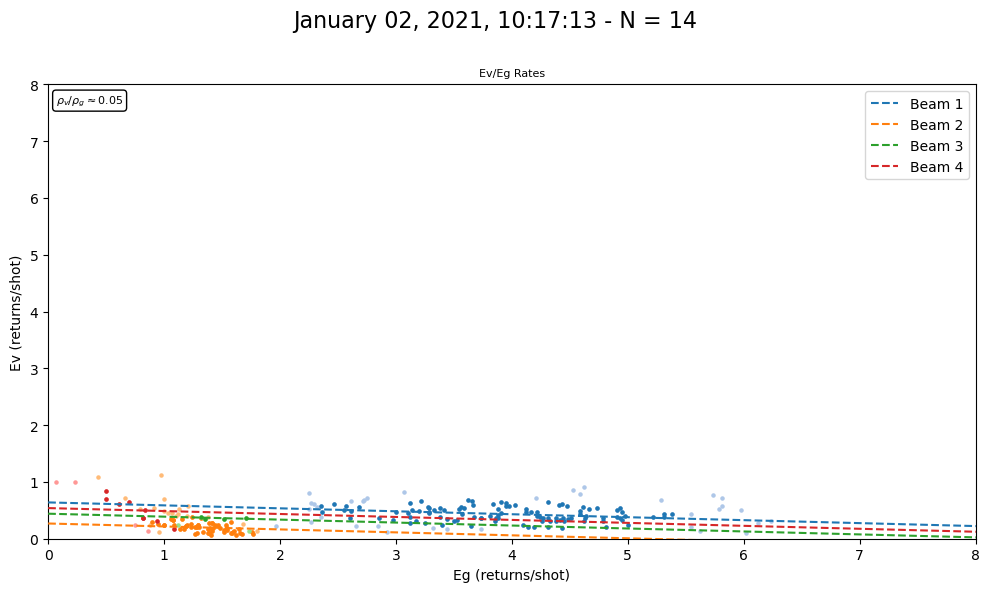

Nothing in rebinned section for delta_junction file 15's beam 3.
Nothing in rebinned section for delta_junction file 15's beam 4.
Nothing in rebinned section for delta_junction file 15's beam 5.
Nothing in rebinned section for delta_junction file 15's beam 6.


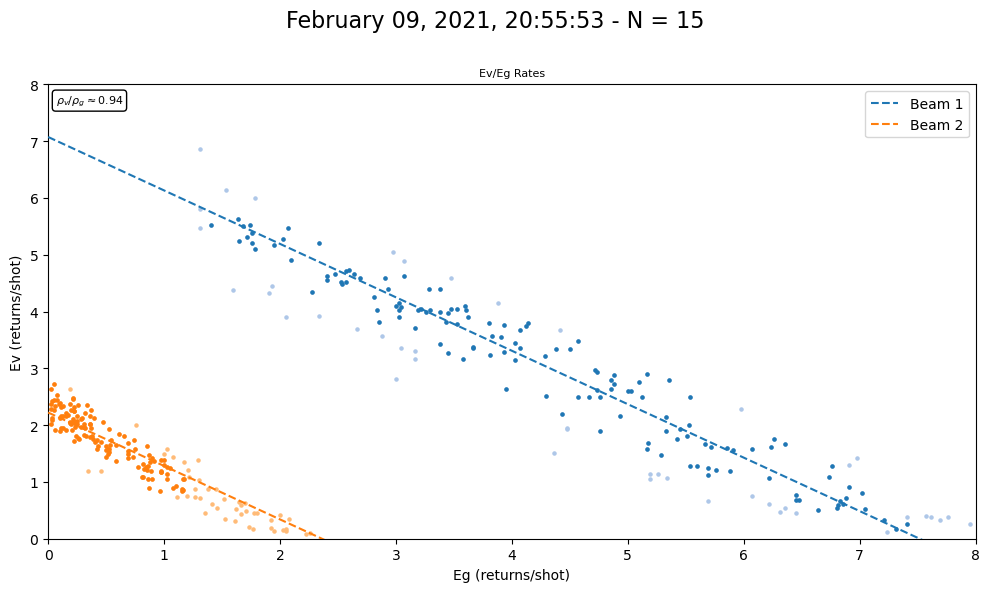

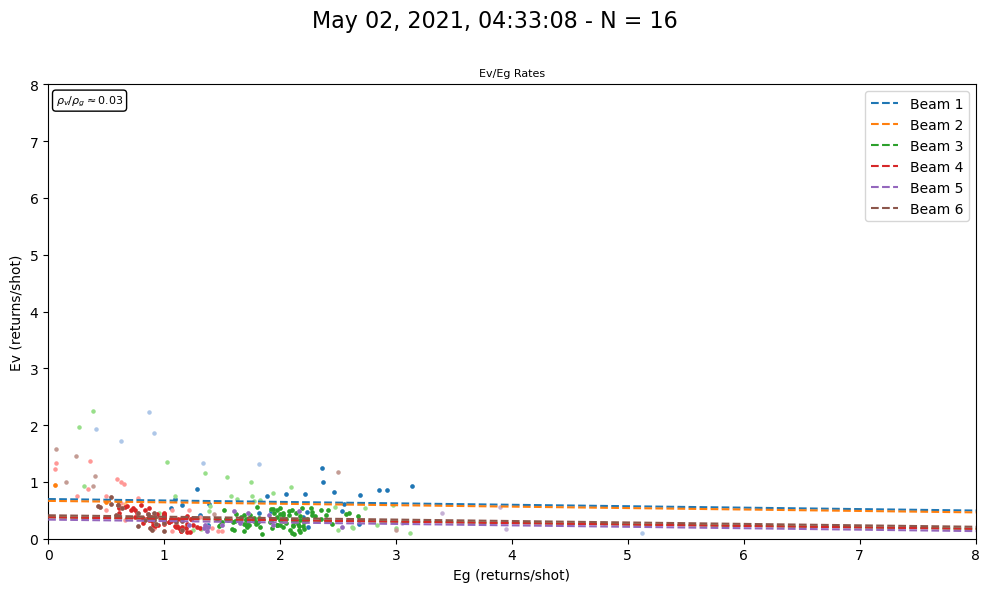

Nothing in rebinned section for delta_junction file 17's beam 1.
Nothing in rebinned section for delta_junction file 17's beam 2.
Nothing in rebinned section for delta_junction file 17's beam 3.
Nothing in rebinned section for delta_junction file 17's beam 4.
Nothing in rebinned section for delta_junction file 17's beam 6.
Nothing in rebinned section for delta_junction file 18's beam 5.
Nothing in rebinned section for delta_junction file 18's beam 6.


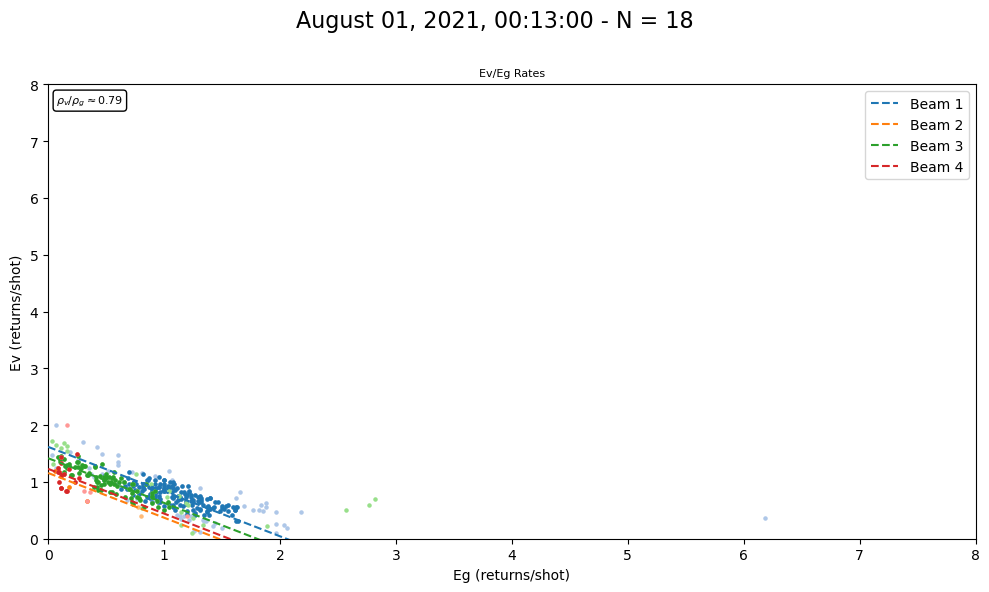

Nothing in rebinned section for delta_junction file 19's beam 5.
Nothing in rebinned section for delta_junction file 19's beam 6.


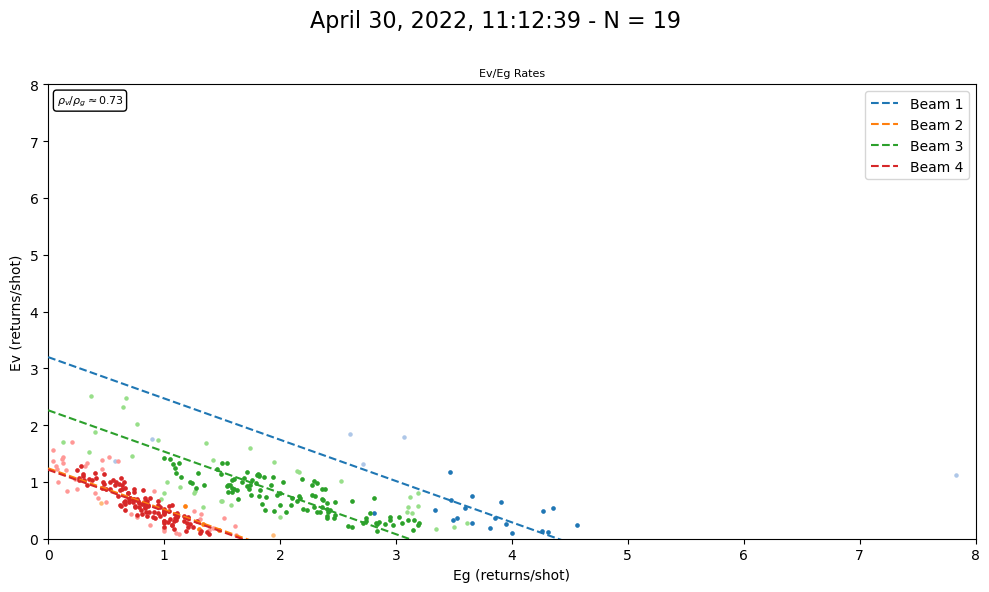

Nothing in rebinned section for delta_junction file 20's beam 3.
Nothing in rebinned section for delta_junction file 20's beam 5.
Nothing in rebinned section for delta_junction file 20's beam 6.


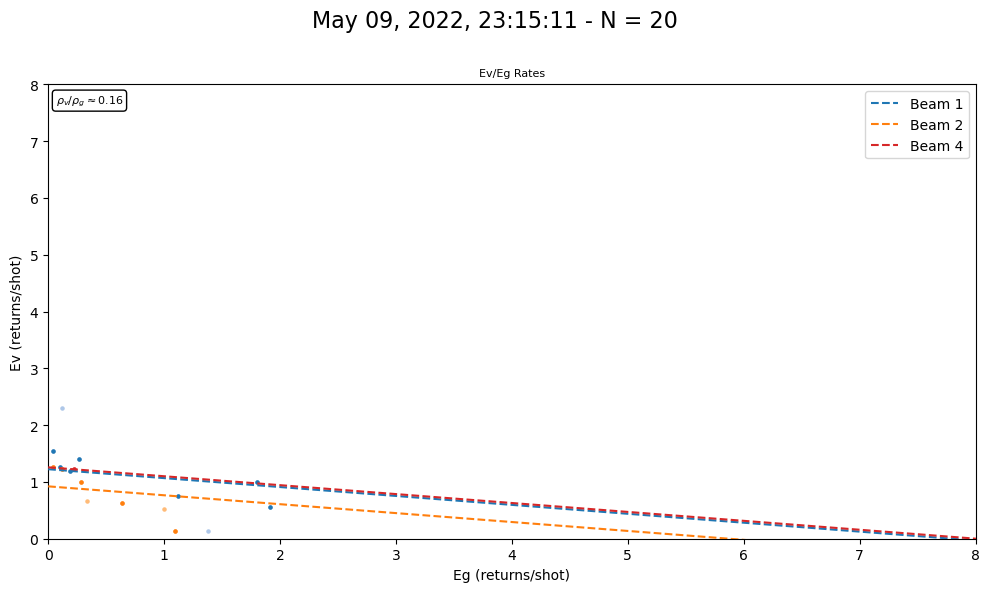

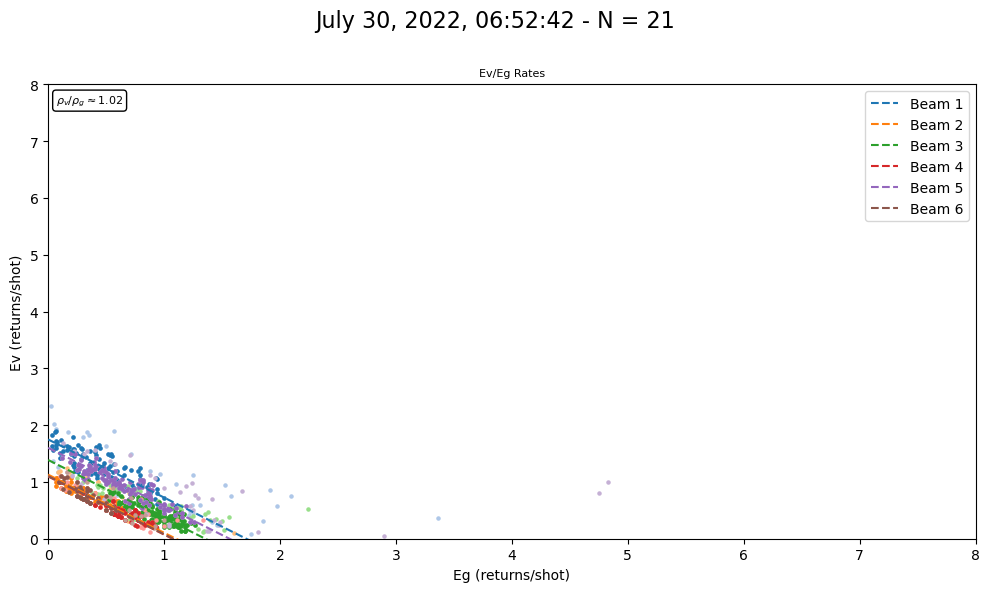

Nothing in rebinned section for delta_junction file 22's beam 3.
Nothing in rebinned section for delta_junction file 22's beam 4.
Nothing in rebinned section for delta_junction file 22's beam 5.
Nothing in rebinned section for delta_junction file 22's beam 6.


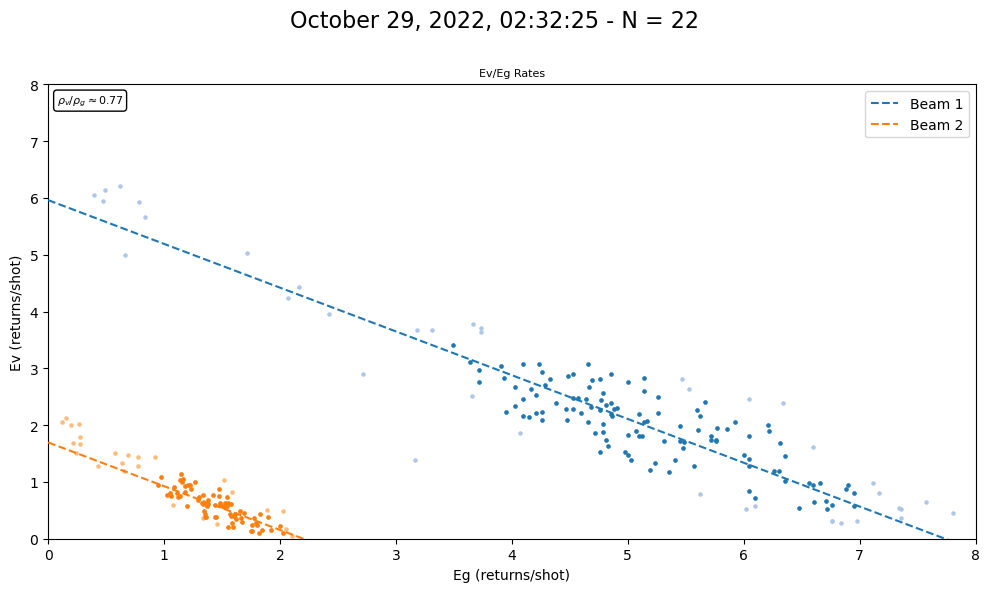

Nothing in rebinned section for delta_junction file 23's beam 5.
Nothing in rebinned section for delta_junction file 23's beam 6.


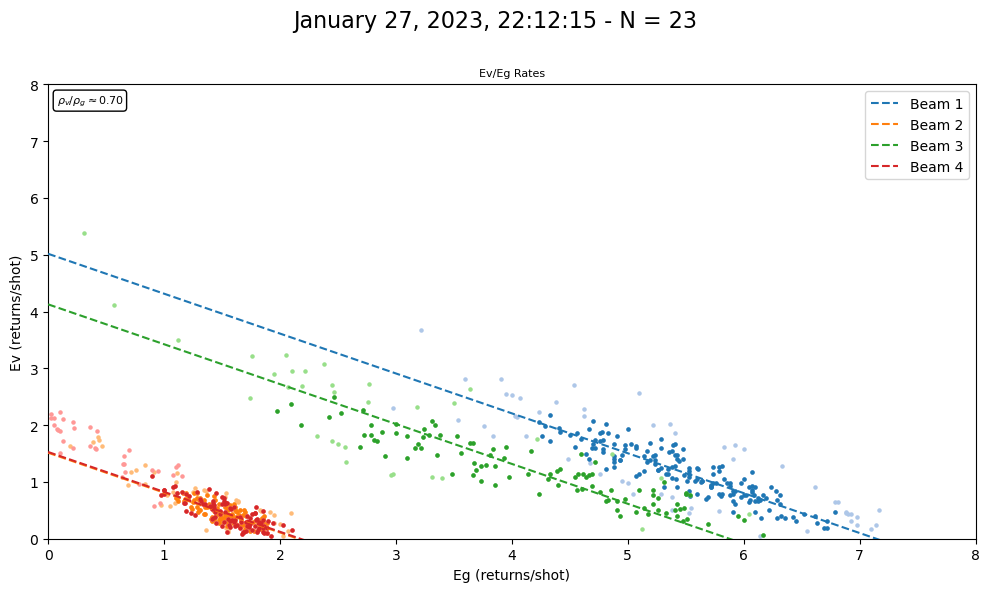

Nothing in rebinned section for delta_junction file 24's beam 5.
Nothing in rebinned section for delta_junction file 24's beam 6.


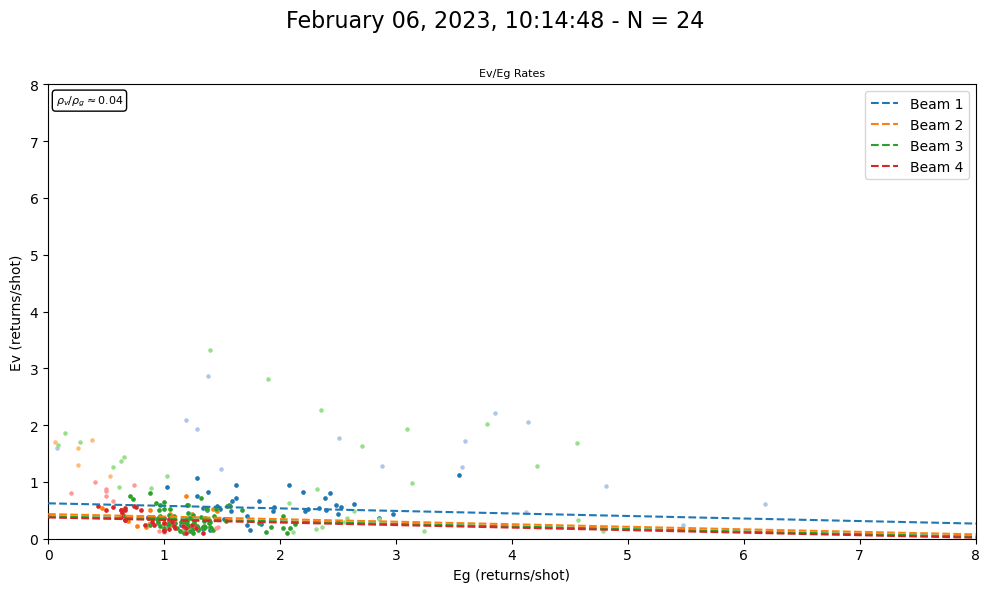

Nothing in rebinned section for delta_junction file 25's beam 1.
Nothing in rebinned section for delta_junction file 25's beam 2.


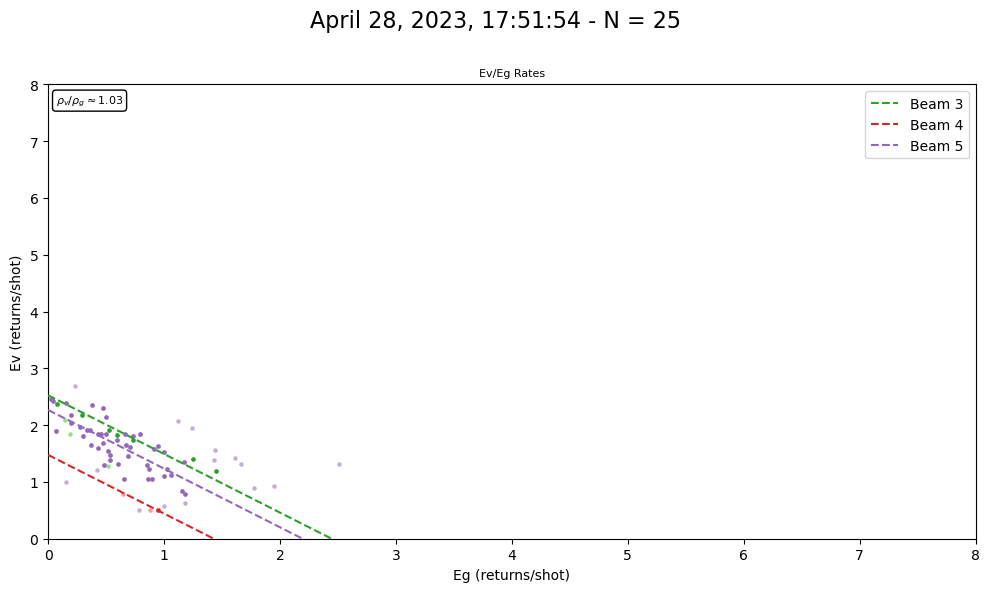

Nothing in rebinned section for delta_junction file 26's beam 5.


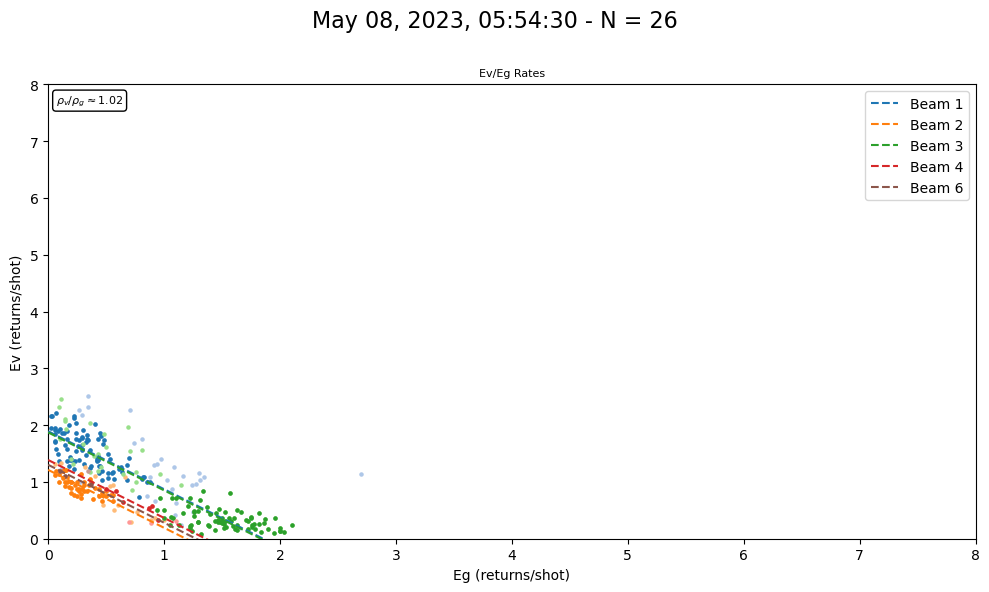

Nothing in rebinned section for delta_junction file 27's beam 1.
Nothing in rebinned section for delta_junction file 27's beam 2.
Nothing in rebinned section for delta_junction file 27's beam 3.
Nothing in rebinned section for delta_junction file 27's beam 4.


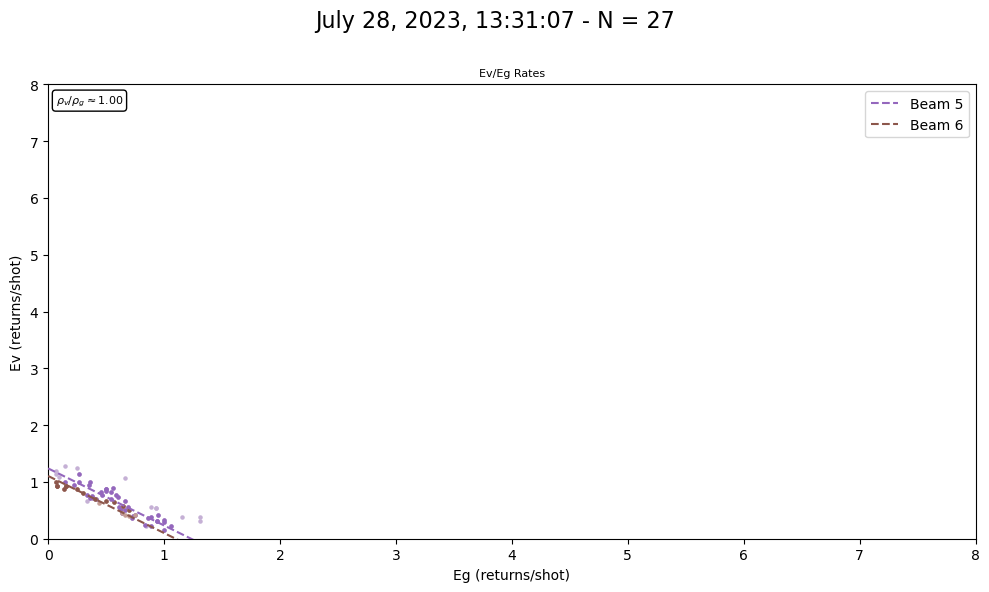

Nothing in rebinned section for delta_junction file 28's beam 1.
Nothing in rebinned section for delta_junction file 28's beam 2.


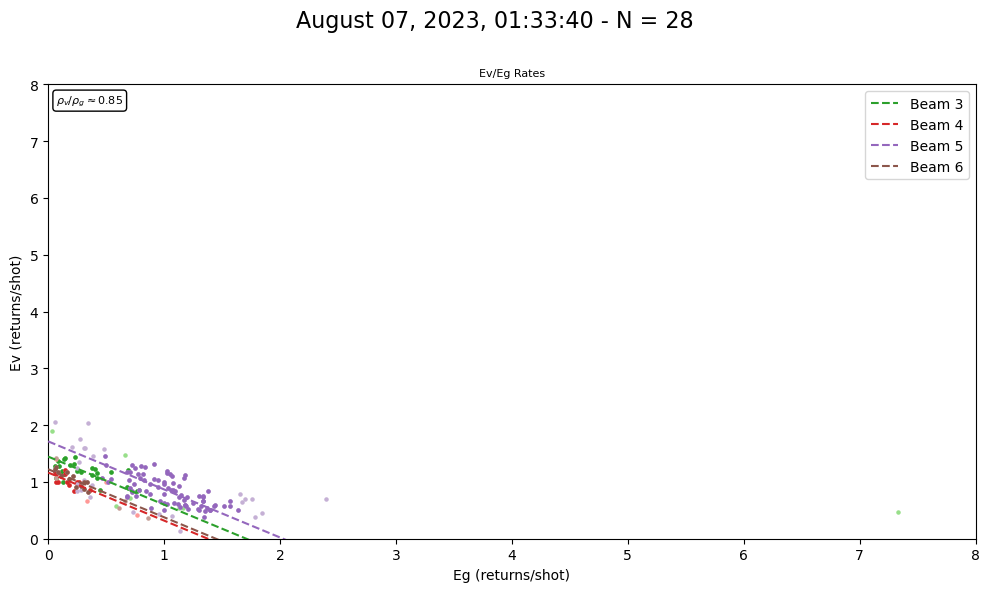

Nothing in rebinned section for delta_junction file 29's beam 1.
Nothing in rebinned section for delta_junction file 29's beam 2.
Nothing in rebinned section for delta_junction file 29's beam 3.
Nothing in rebinned section for delta_junction file 29's beam 4.
Nothing in rebinned section for delta_junction file 29's beam 5.
Nothing in rebinned section for delta_junction file 29's beam 6.
Nothing in rebinned section for delta_junction file 30's beam 1.
Nothing in rebinned section for delta_junction file 30's beam 2.


/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope =

Nothing in rebinned section for delta_junction file 30's beam 4.


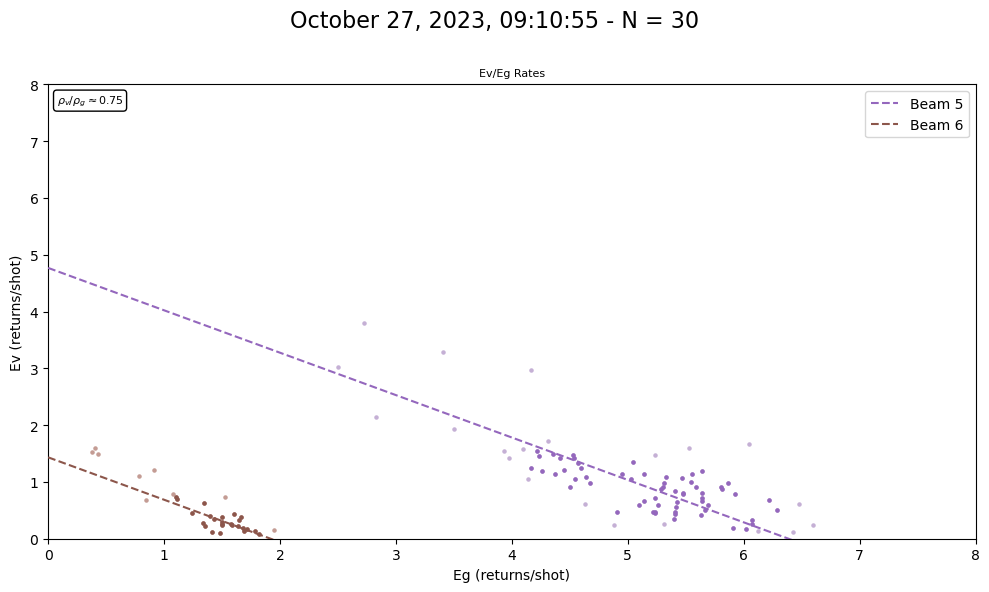

Nothing in rebinned section for delta_junction file 31's beam 5.
Nothing in rebinned section for delta_junction file 31's beam 6.


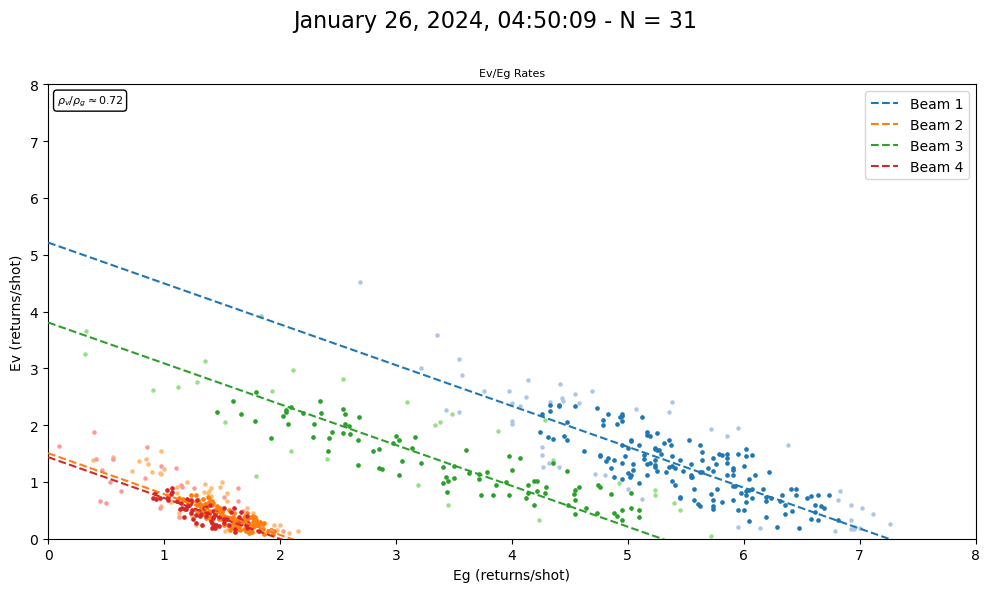

Nothing in rebinned section for delta_junction file 32's beam 5.
Nothing in rebinned section for delta_junction file 32's beam 6.


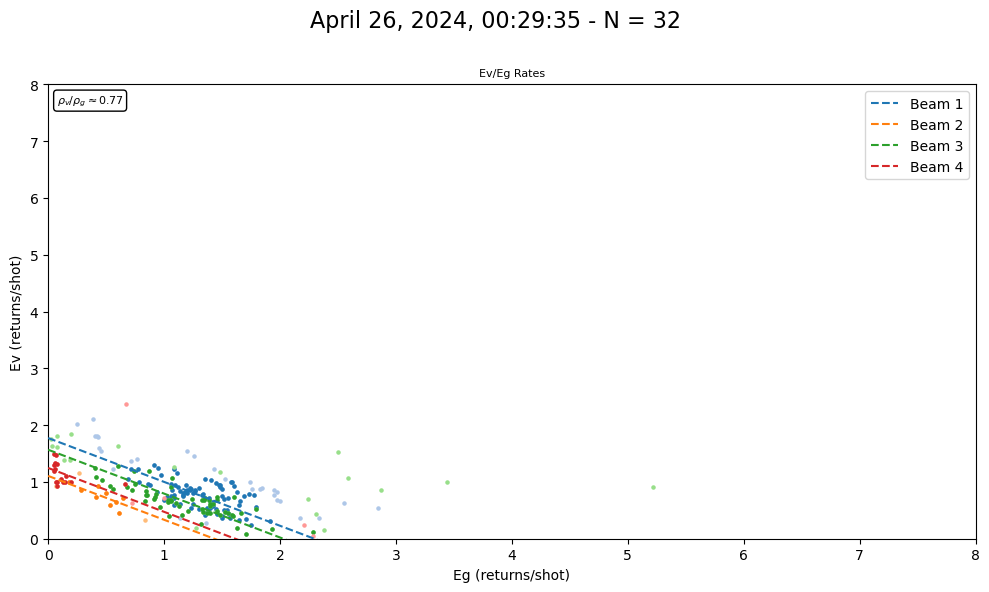

Nothing in rebinned section for delta_junction file 33's beam 1.
Nothing in rebinned section for delta_junction file 33's beam 2.
Nothing in rebinned section for delta_junction file 33's beam 4.


/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope =

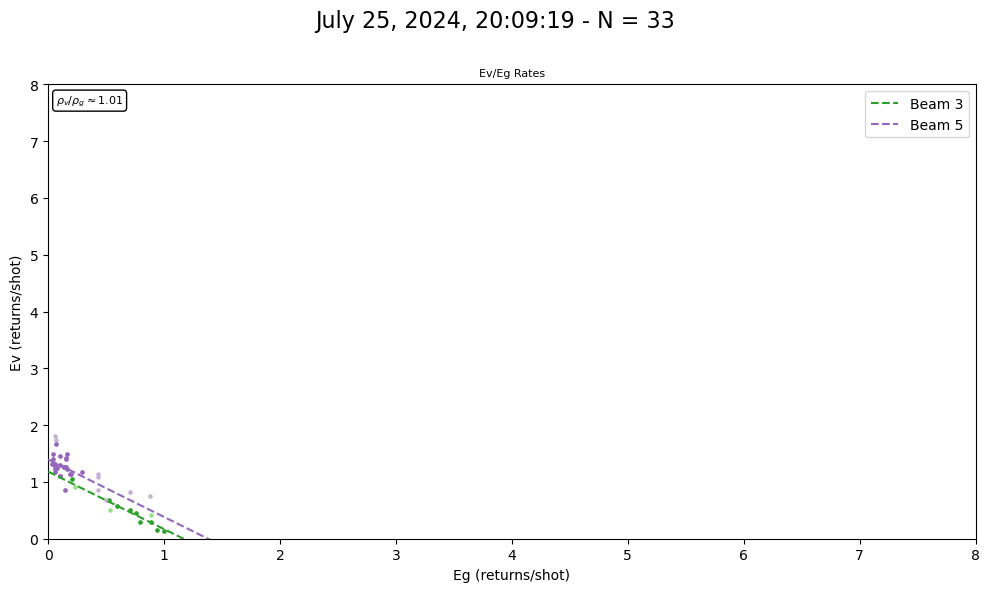

In [1]:
from scripts.parallel_blocks import *

dirpath = '../data_store/data/delta_junction/'

all_ATL03, all_ATL08, failed_ATL03 = track_pairs(dirpath, failed=True)
N = len(all_ATL03)

coords = (-145.7514, 63.8811)

for i in range(N):
    data = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i], coords=coords, width=4,height=4,file_index=i, alt_thresh=80,\
                         altitude=504, threshold=1, small_box=8.05, graph_detail=1, loss='linear', rebinned=30, f_scale=.05,
                         outlier_removal=.1, method='bimodal')

# Marcell MN

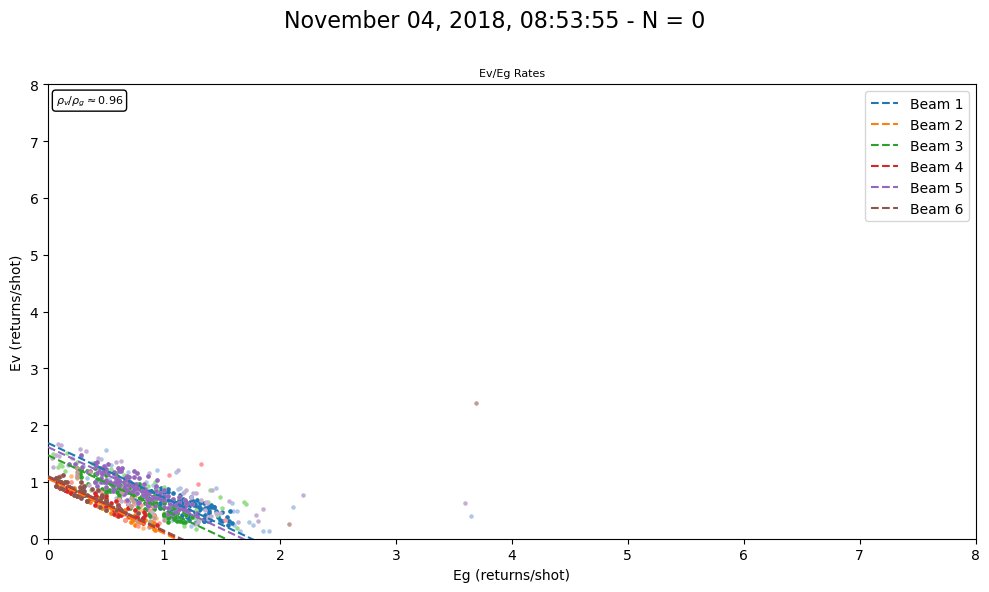

Nothing in rebinned section for marcell_MN file 1's beam 1.
Nothing in rebinned section for marcell_MN file 1's beam 2.
Nothing in rebinned section for marcell_MN file 1's beam 3.
Nothing in rebinned section for marcell_MN file 1's beam 4.


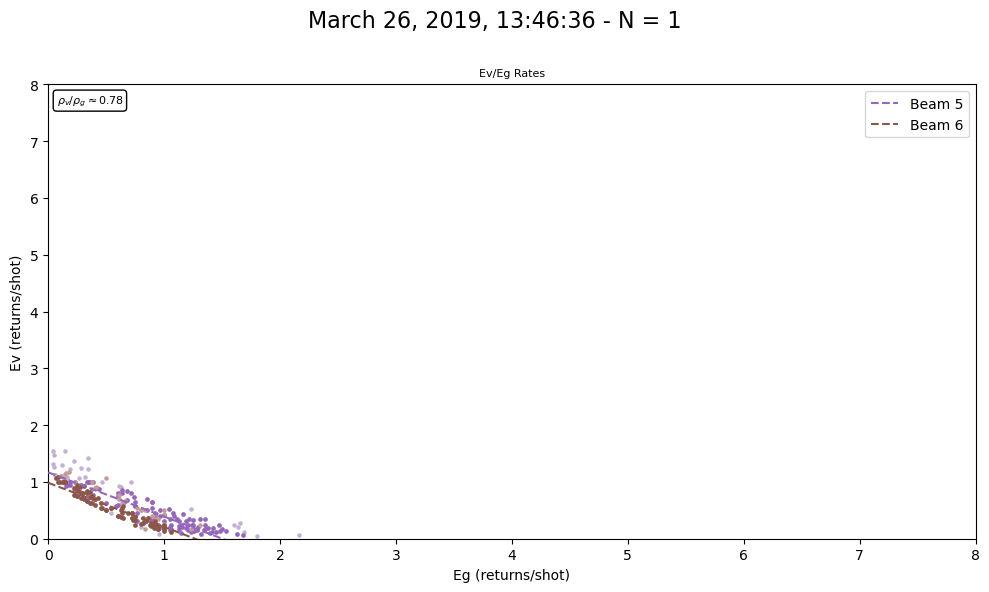

Nothing in rebinned section for marcell_MN file 2's beam 1.
Nothing in rebinned section for marcell_MN file 2's beam 2.
Nothing in rebinned section for marcell_MN file 2's beam 3.
Nothing in rebinned section for marcell_MN file 2's beam 4.


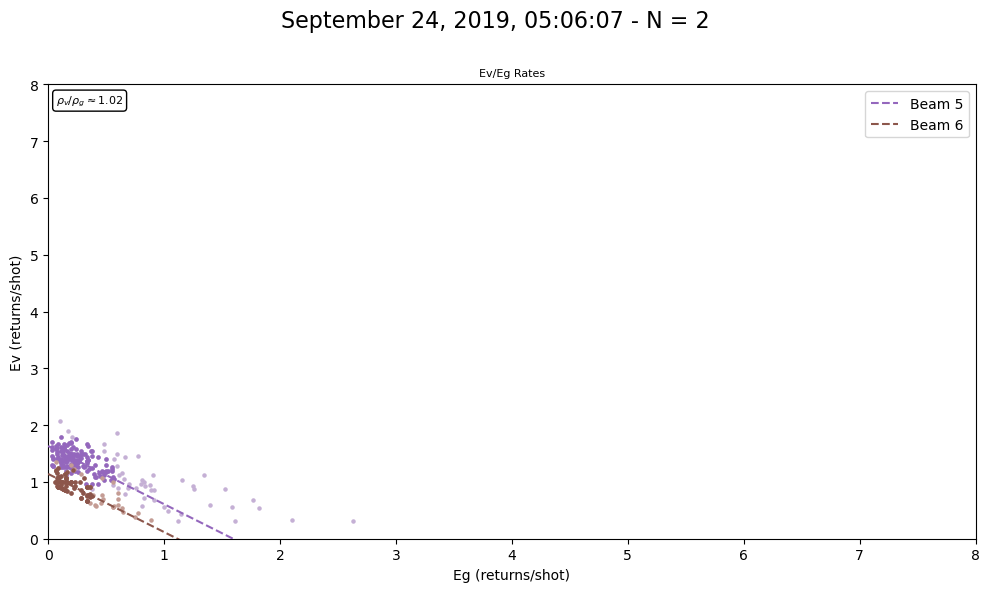

Nothing in rebinned section for marcell_MN file 3's beam 1.
Nothing in rebinned section for marcell_MN file 3's beam 2.
Nothing in rebinned section for marcell_MN file 3's beam 3.
Nothing in rebinned section for marcell_MN file 3's beam 4.


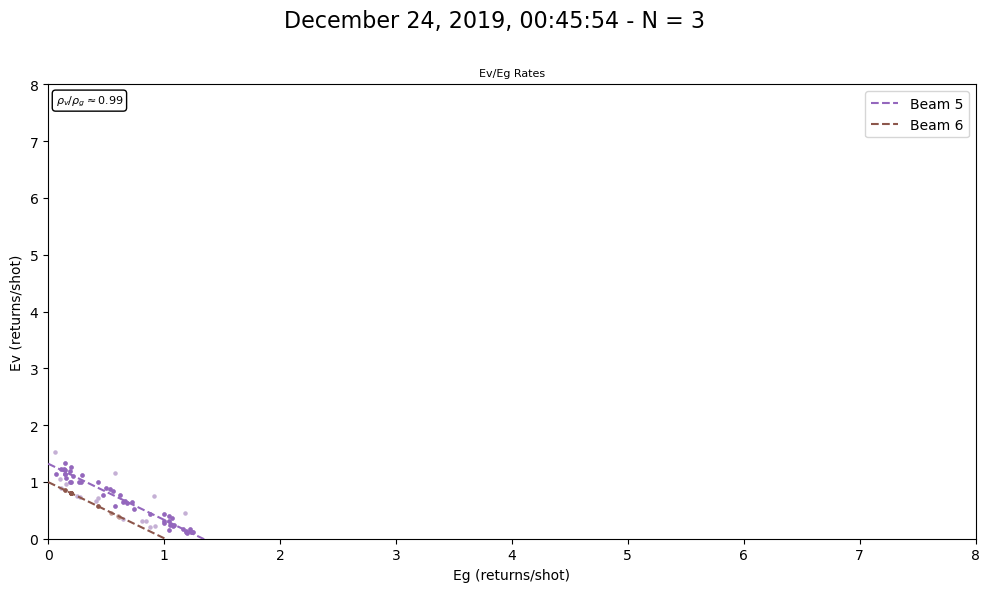

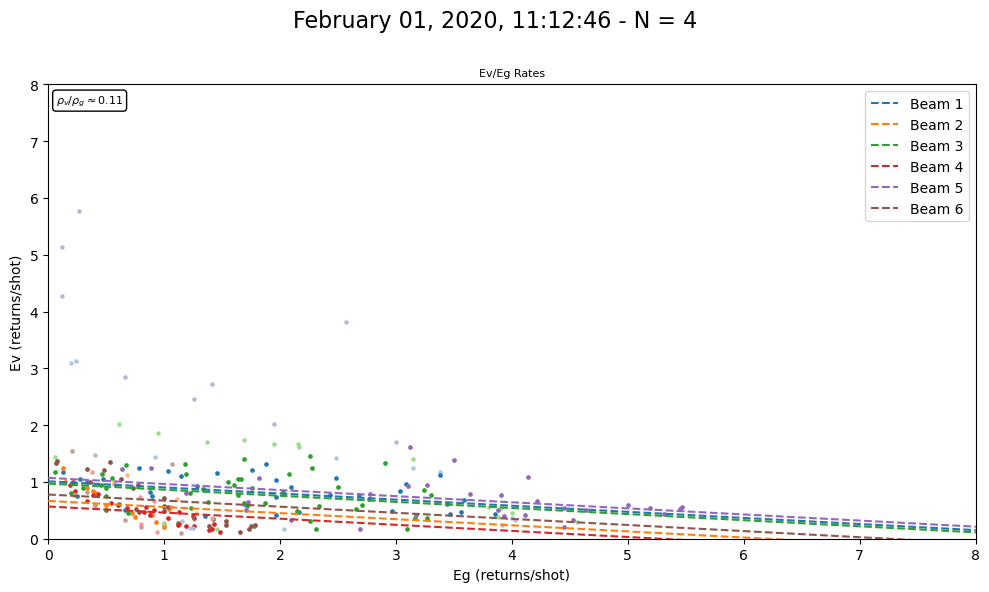

Nothing in rebinned section for marcell_MN file 5's beam 1.
Nothing in rebinned section for marcell_MN file 5's beam 2.
Nothing in rebinned section for marcell_MN file 5's beam 3.
Nothing in rebinned section for marcell_MN file 5's beam 4.


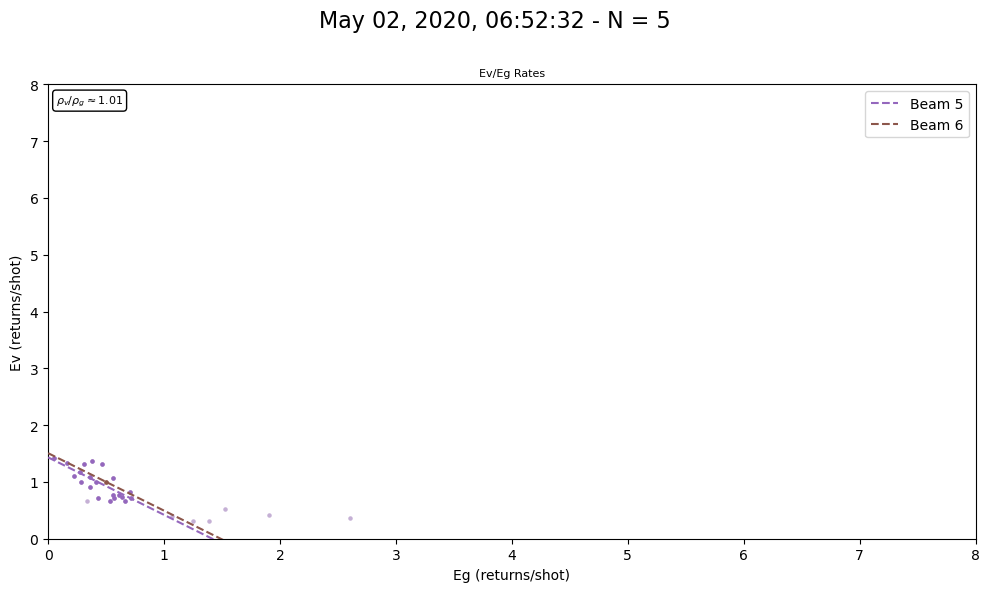

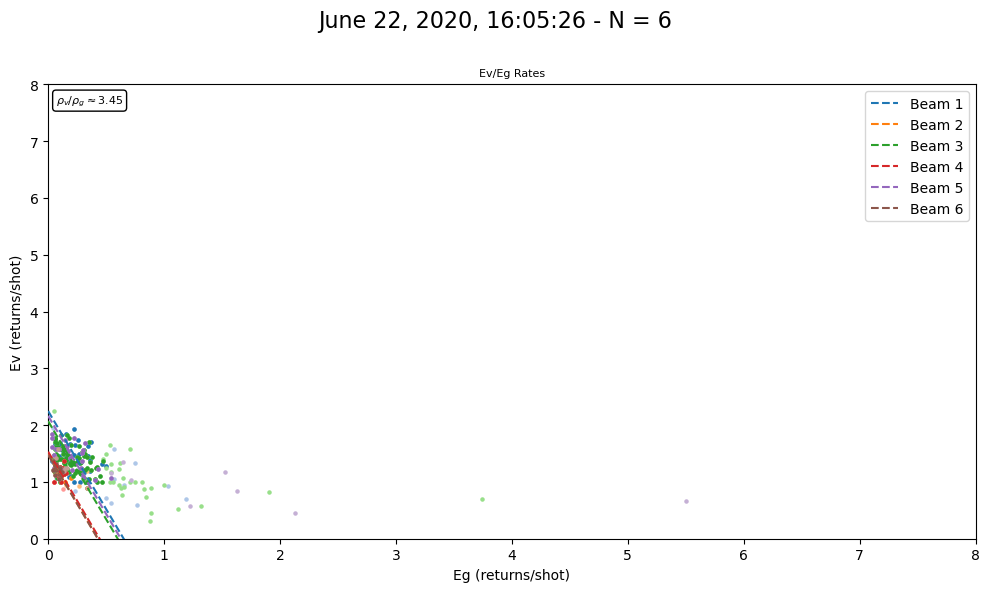

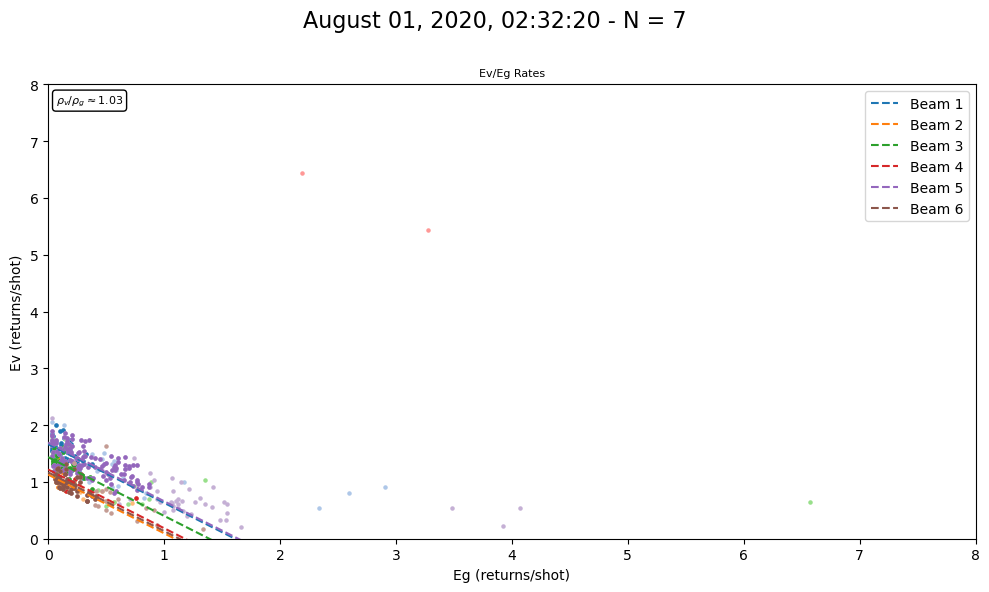

Nothing in rebinned section for marcell_MN file 8's beam 1.
Nothing in rebinned section for marcell_MN file 8's beam 2.
Nothing in rebinned section for marcell_MN file 8's beam 3.
Nothing in rebinned section for marcell_MN file 8's beam 4.


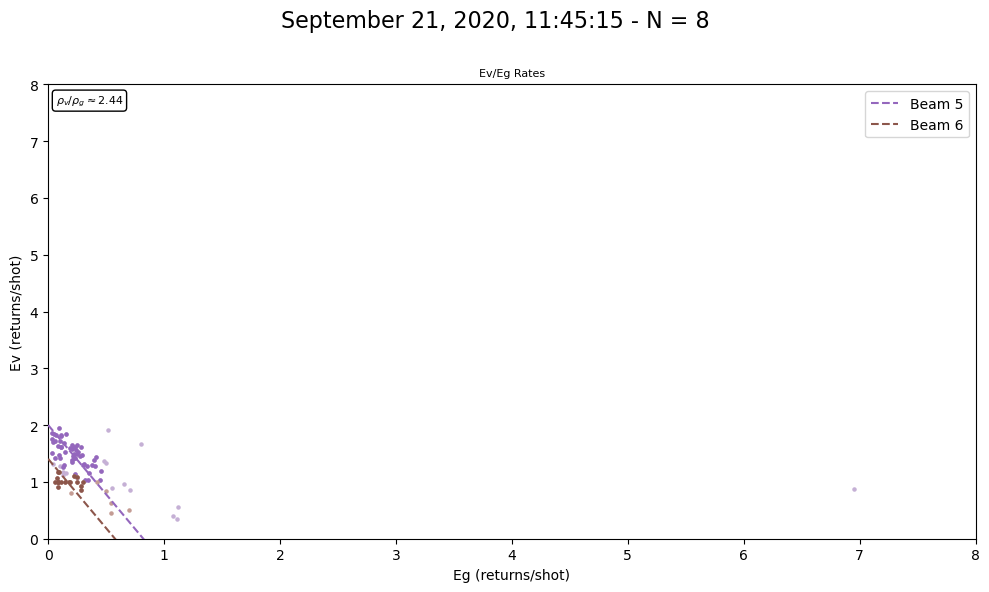

Nothing in rebinned section for marcell_MN file 9's beam 5.
Nothing in rebinned section for marcell_MN file 9's beam 6.


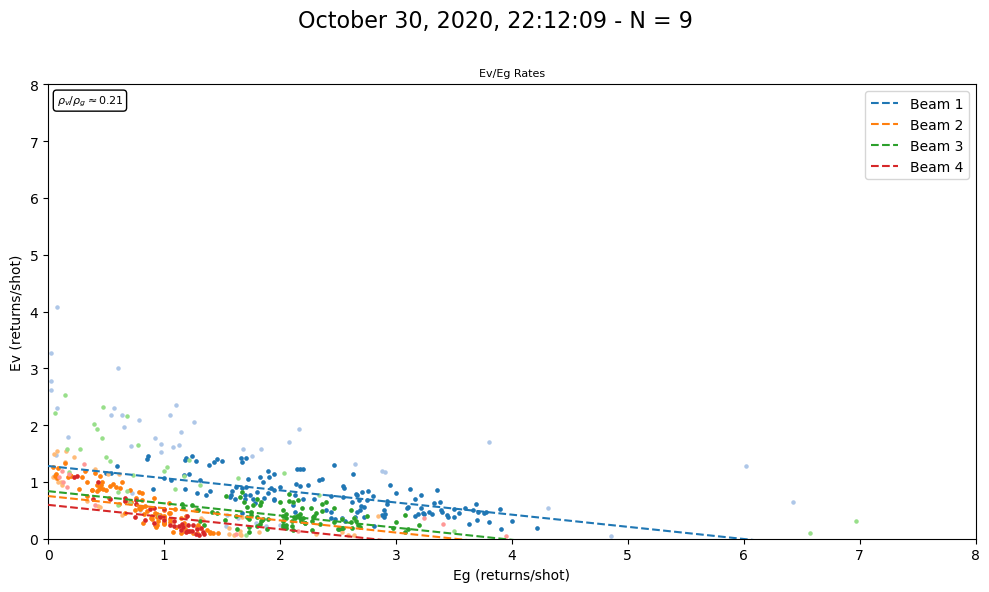

Nothing in rebinned section for marcell_MN file 10's beam 1.
Nothing in rebinned section for marcell_MN file 10's beam 2.
Nothing in rebinned section for marcell_MN file 10's beam 3.
Nothing in rebinned section for marcell_MN file 10's beam 4.
Nothing in rebinned section for marcell_MN file 10's beam 5.
Nothing in rebinned section for marcell_MN file 10's beam 6.
Nothing in rebinned section for marcell_MN file 11's beam 1.
Nothing in rebinned section for marcell_MN file 11's beam 2.
Nothing in rebinned section for marcell_MN file 11's beam 3.
Nothing in rebinned section for marcell_MN file 11's beam 4.
Nothing in rebinned section for marcell_MN file 11's beam 6.


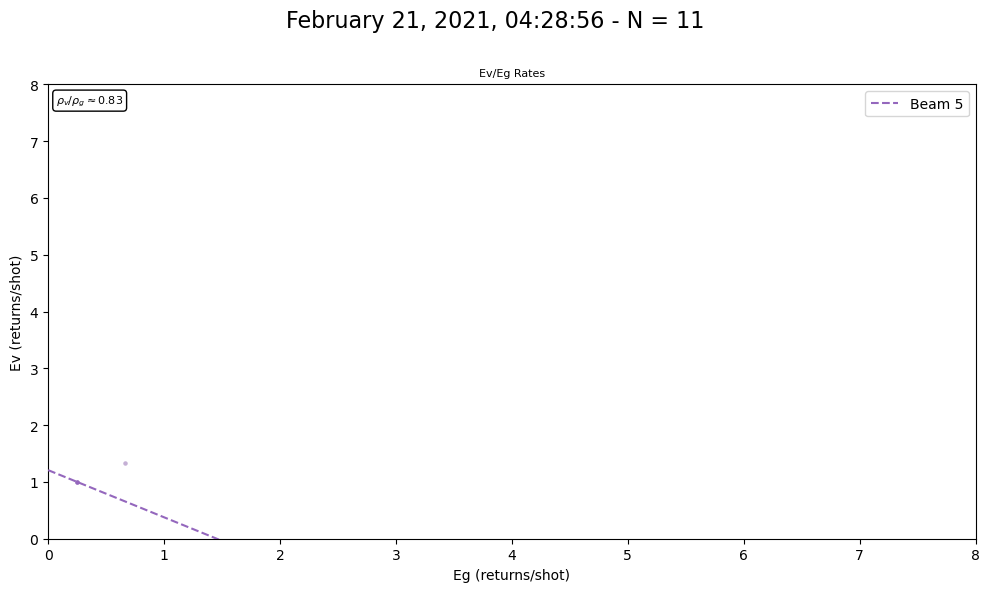

Nothing in rebinned section for marcell_MN file 12's beam 1.
Nothing in rebinned section for marcell_MN file 12's beam 2.
Nothing in rebinned section for marcell_MN file 12's beam 3.
Nothing in rebinned section for marcell_MN file 12's beam 4.


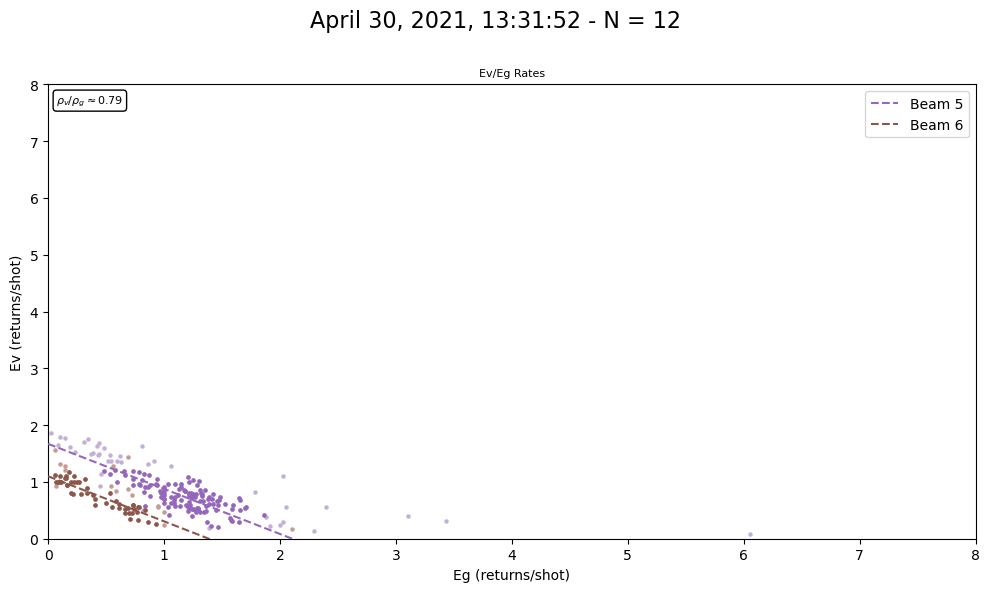

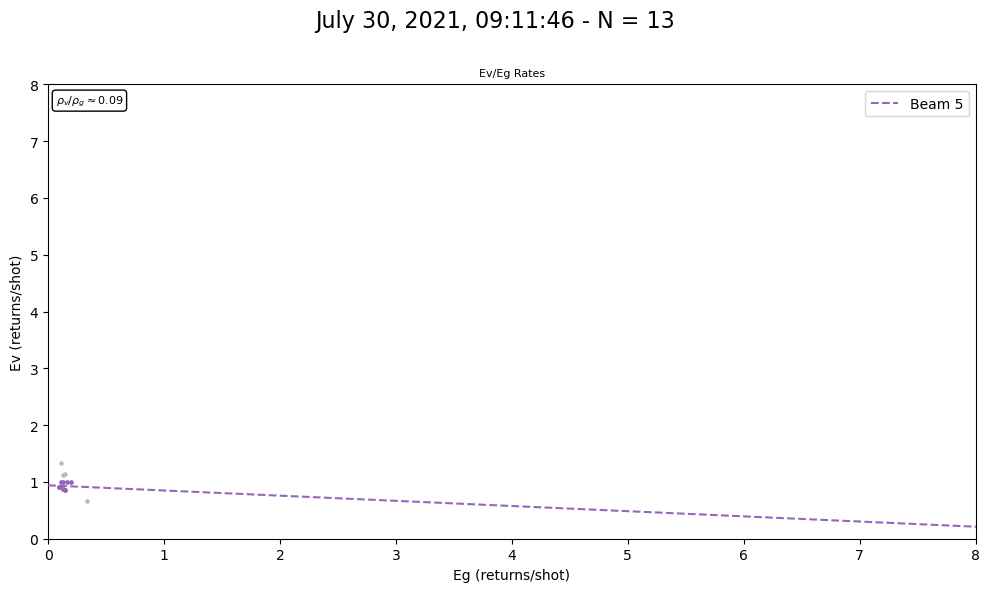

Nothing in rebinned section for marcell_MN file 14's beam 3.
Nothing in rebinned section for marcell_MN file 14's beam 4.
Nothing in rebinned section for marcell_MN file 14's beam 5.
Nothing in rebinned section for marcell_MN file 14's beam 6.


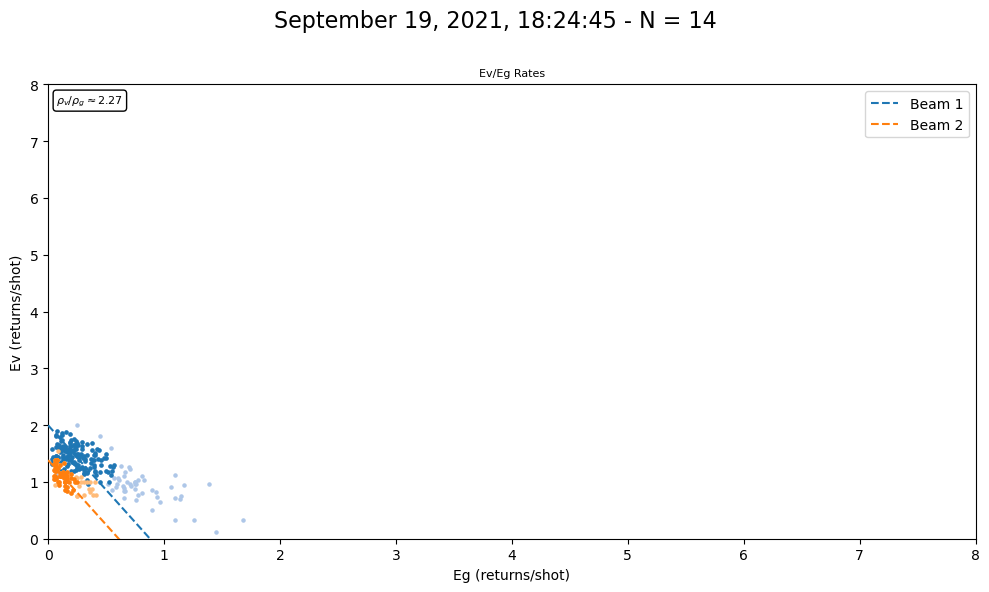

Nothing in rebinned section for marcell_MN file 15's beam 3.
Nothing in rebinned section for marcell_MN file 15's beam 4.
Nothing in rebinned section for marcell_MN file 15's beam 5.
Nothing in rebinned section for marcell_MN file 15's beam 6.


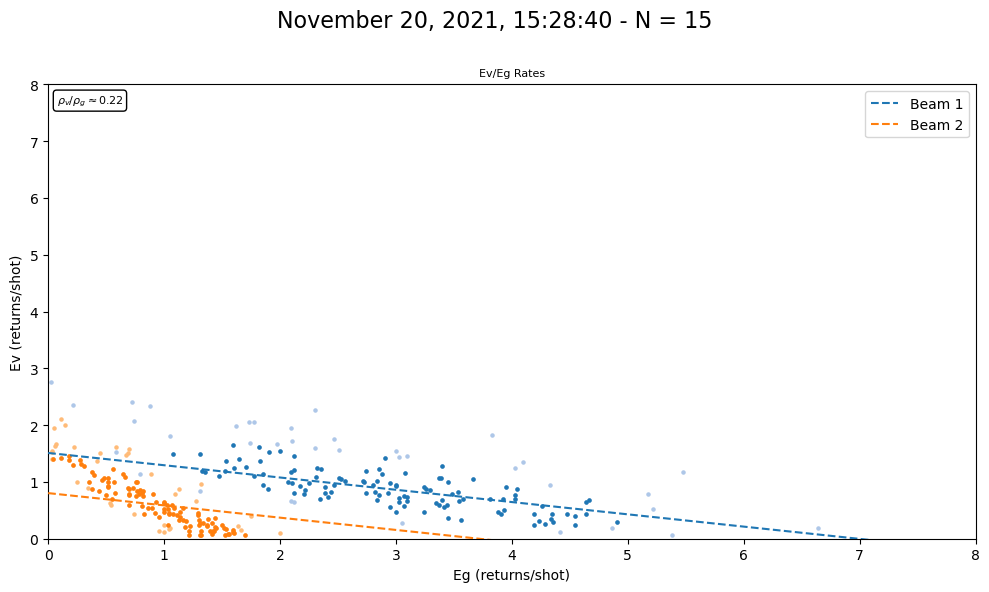

Nothing in rebinned section for marcell_MN file 16's beam 1.
Nothing in rebinned section for marcell_MN file 16's beam 2.
Nothing in rebinned section for marcell_MN file 16's beam 3.
Nothing in rebinned section for marcell_MN file 16's beam 4.


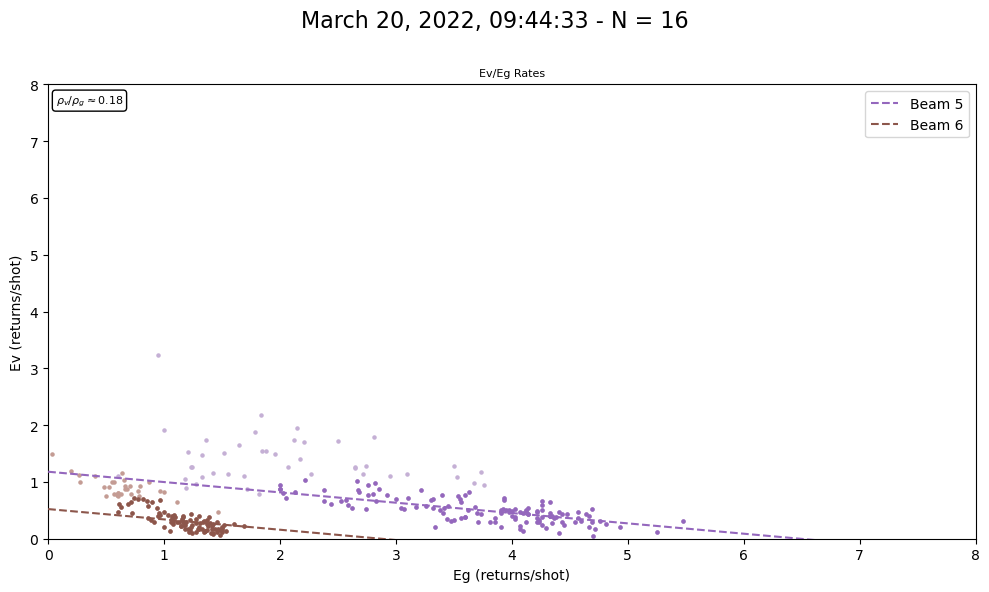

Nothing in rebinned section for marcell_MN file 17's beam 1.
Nothing in rebinned section for marcell_MN file 17's beam 2.
Nothing in rebinned section for marcell_MN file 17's beam 4.


/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope =

Nothing in rebinned section for marcell_MN file 18's beam 1.
Nothing in rebinned section for marcell_MN file 18's beam 2.
Nothing in rebinned section for marcell_MN file 18's beam 4.


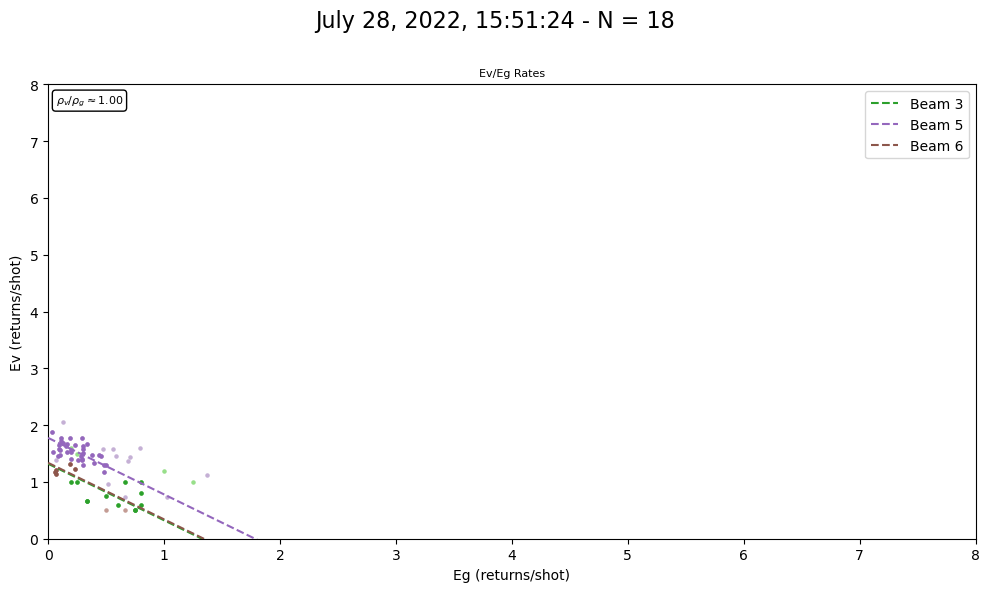

Nothing in rebinned section for marcell_MN file 19's beam 1.
Nothing in rebinned section for marcell_MN file 19's beam 2.


/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope =

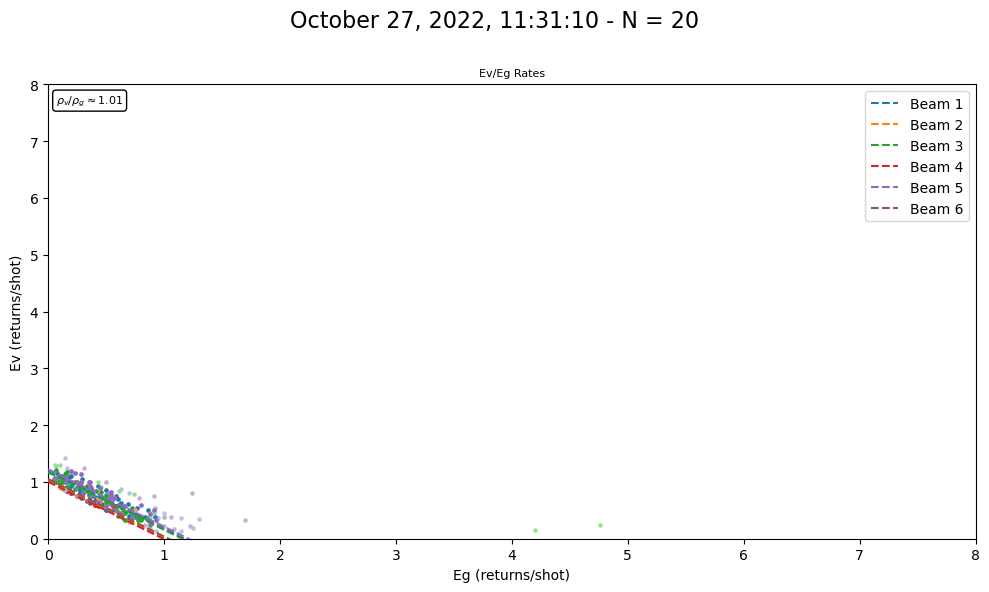

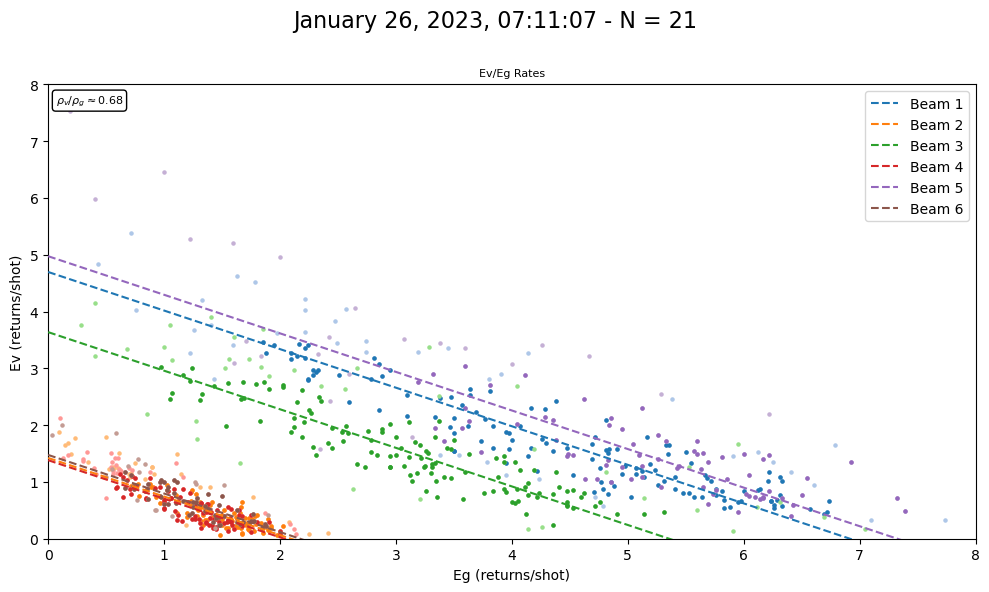

Nothing in rebinned section for marcell_MN file 22's beam 1.
Nothing in rebinned section for marcell_MN file 22's beam 2.
Nothing in rebinned section for marcell_MN file 22's beam 3.
Nothing in rebinned section for marcell_MN file 22's beam 4.


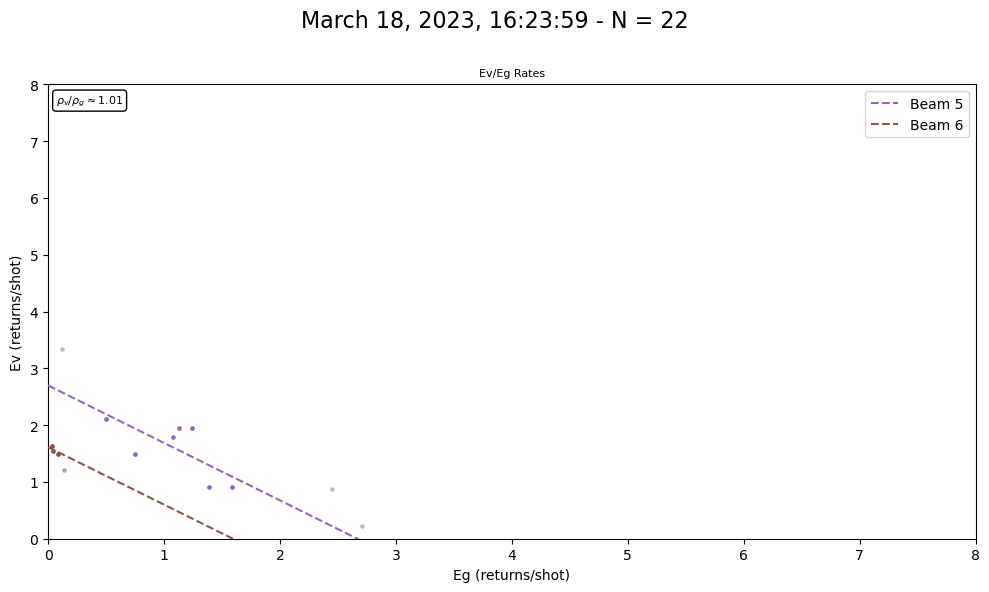

Nothing in rebinned section for marcell_MN file 23's beam 2.
Nothing in rebinned section for marcell_MN file 23's beam 3.
Nothing in rebinned section for marcell_MN file 23's beam 4.
Nothing in rebinned section for marcell_MN file 23's beam 5.
Nothing in rebinned section for marcell_MN file 23's beam 6.
Nothing in rebinned section for marcell_MN file 24's beam 1.
Nothing in rebinned section for marcell_MN file 24's beam 2.


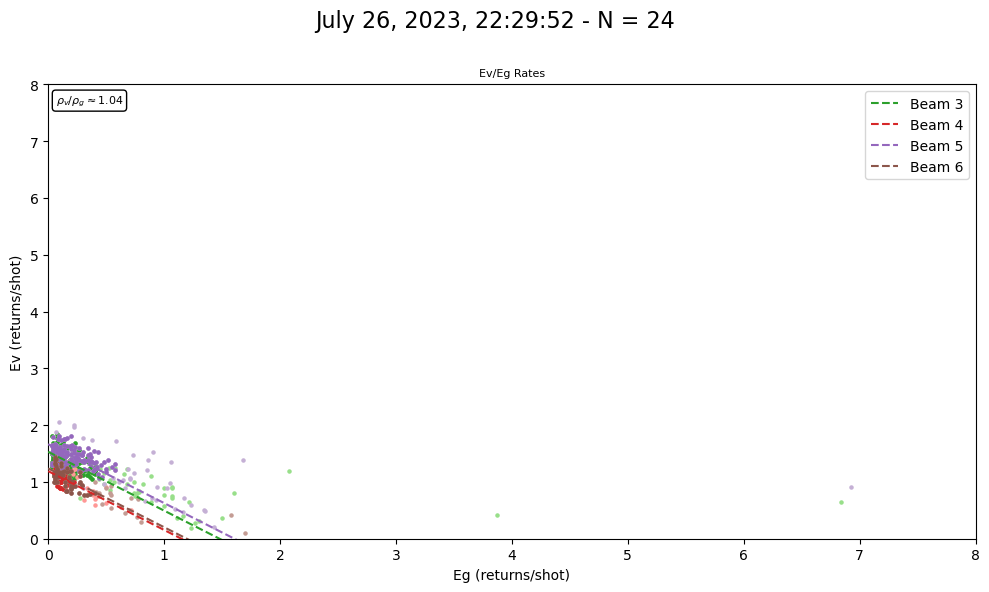

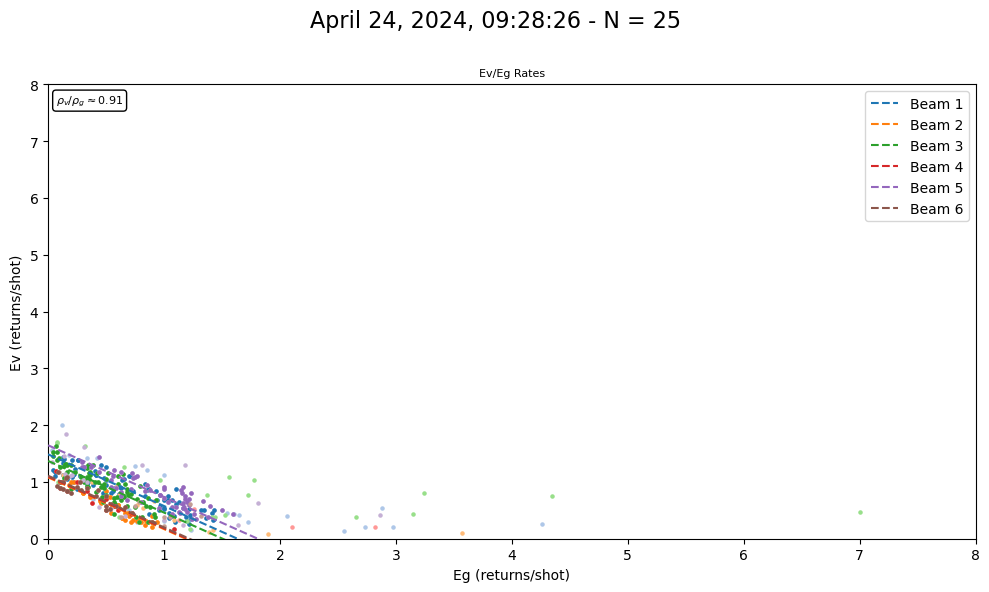

Nothing in rebinned section for marcell_MN file 26's beam 5.
Nothing in rebinned section for marcell_MN file 26's beam 6.


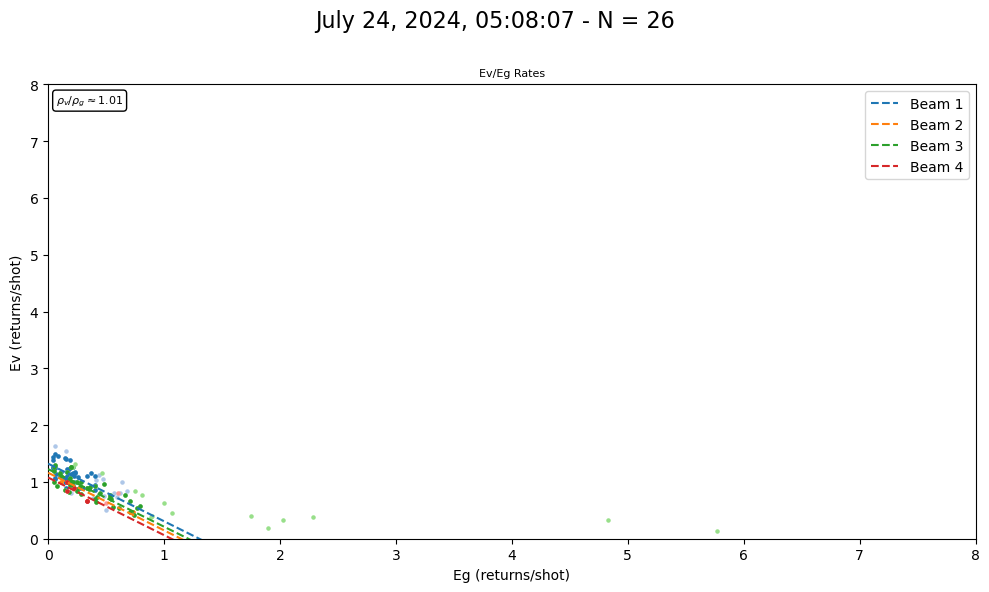

In [1]:
from scripts.parallel_blocks import *

dirpath = '../data_store/data/marcell_MN/'

all_ATL03, all_ATL08, failed_ATL03 = track_pairs(dirpath, failed=True)
N = len(all_ATL03)

coords = (-93.4541, 47.5049)

for i in range(N):
    data = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i], coords=coords, width=4,height=4,file_index=i, alt_thresh=80,\
                         altitude=413, threshold=1, small_box=8.05, graph_detail=1, loss='linear', rebinned=30, f_scale=.05,\
                         outlier_removal=.1,method='bimodal')

# Lacclair

Nothing in rebinned section for lacclair file 0's beam 1.
Nothing in rebinned section for lacclair file 0's beam 2.
Nothing in rebinned section for lacclair file 0's beam 3.
Nothing in rebinned section for lacclair file 0's beam 4.
Nothing in rebinned section for lacclair file 0's beam 5.
Nothing in rebinned section for lacclair file 0's beam 6.
Nothing in rebinned section for lacclair file 1's beam 5.
Nothing in rebinned section for lacclair file 1's beam 6.


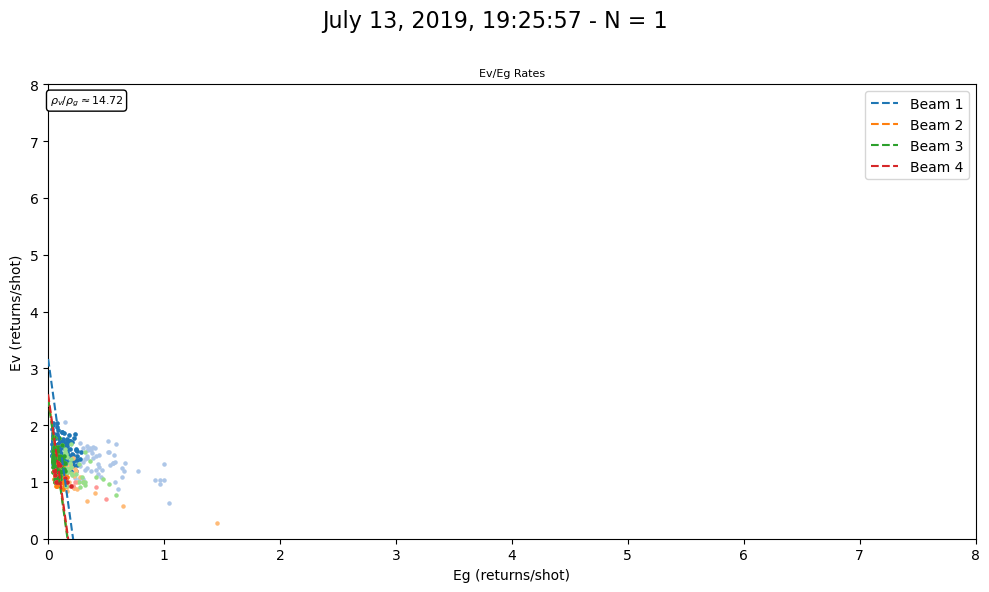

Nothing in rebinned section for lacclair file 2's beam 3.
Nothing in rebinned section for lacclair file 2's beam 4.
Nothing in rebinned section for lacclair file 2's beam 5.
Nothing in rebinned section for lacclair file 2's beam 6.


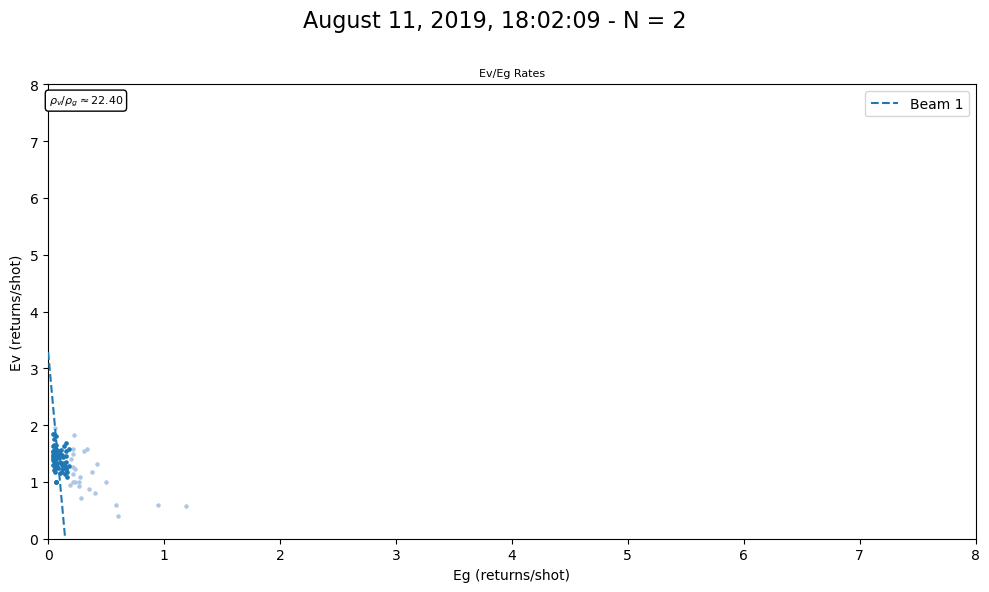

Nothing in rebinned section for lacclair file 3's beam 1.
Nothing in rebinned section for lacclair file 3's beam 2.


/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope =

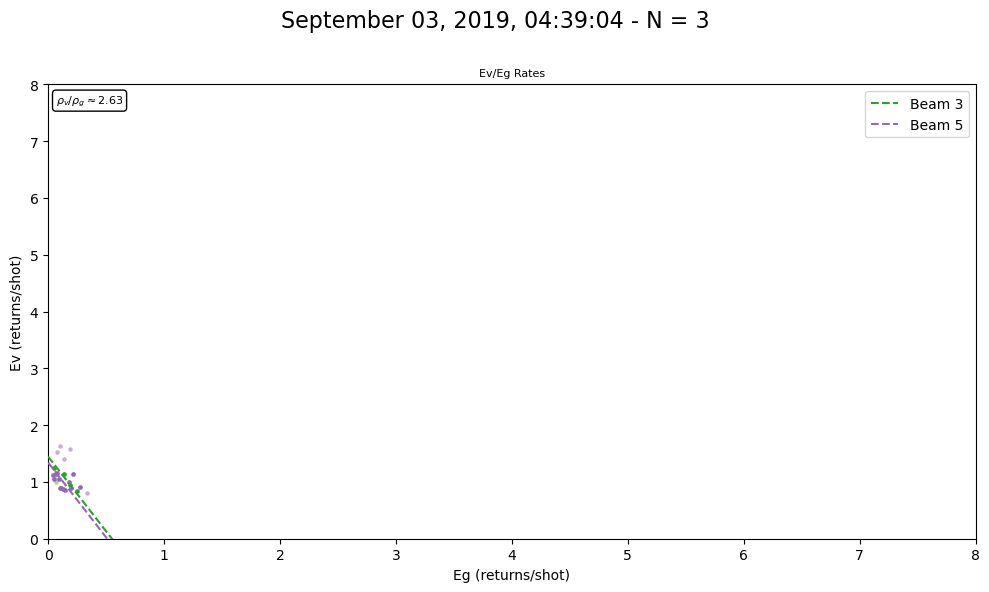

Nothing in rebinned section for lacclair file 4's beam 5.
Nothing in rebinned section for lacclair file 4's beam 6.


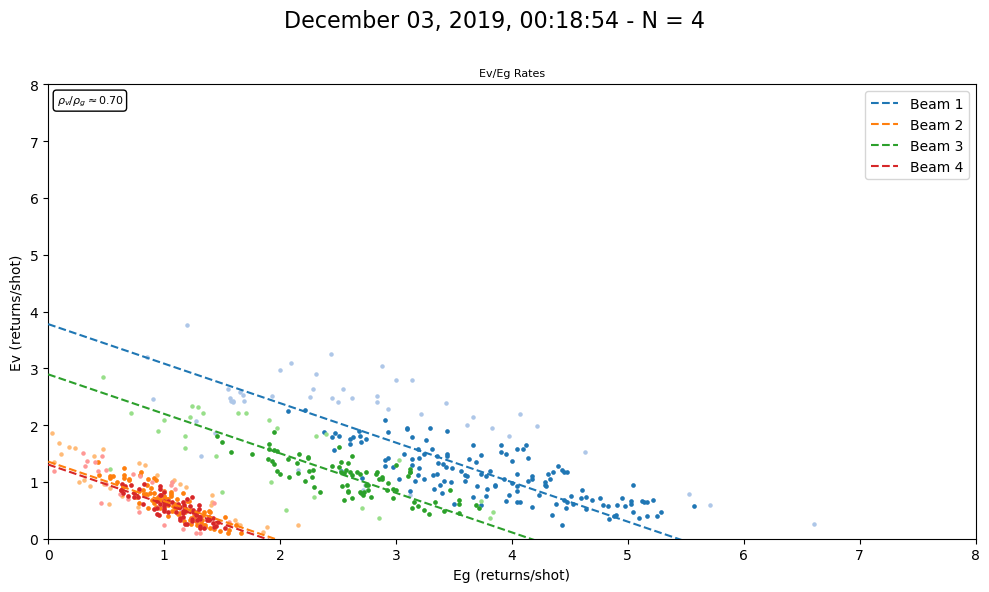

Nothing in rebinned section for lacclair file 5's beam 1.
Nothing in rebinned section for lacclair file 5's beam 2.


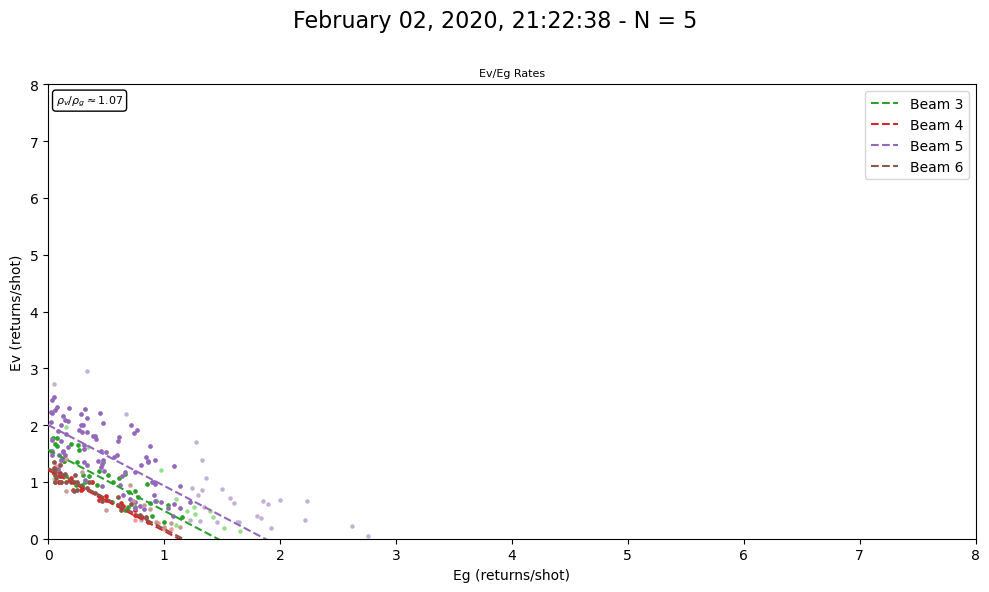

Nothing in rebinned section for lacclair file 6's beam 2.
Nothing in rebinned section for lacclair file 6's beam 3.
Nothing in rebinned section for lacclair file 6's beam 4.
Nothing in rebinned section for lacclair file 6's beam 5.
Nothing in rebinned section for lacclair file 6's beam 6.


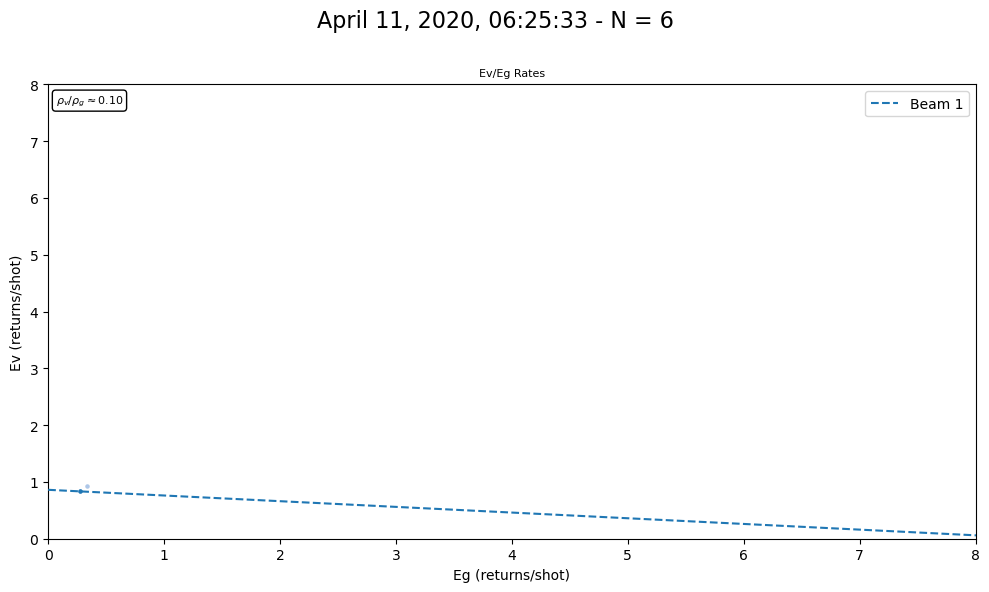

Nothing in rebinned section for lacclair file 7's beam 1.
Nothing in rebinned section for lacclair file 7's beam 2.
Nothing in rebinned section for lacclair file 7's beam 3.
Nothing in rebinned section for lacclair file 7's beam 4.


/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope =

Nothing in rebinned section for lacclair file 8's beam 1.
Nothing in rebinned section for lacclair file 8's beam 2.
Nothing in rebinned section for lacclair file 8's beam 3.
Nothing in rebinned section for lacclair file 8's beam 4.
Nothing in rebinned section for lacclair file 8's beam 5.
Nothing in rebinned section for lacclair file 8's beam 6.
Nothing in rebinned section for lacclair file 9's beam 3.
Nothing in rebinned section for lacclair file 9's beam 4.
Nothing in rebinned section for lacclair file 9's beam 5.
Nothing in rebinned section for lacclair file 9's beam 6.


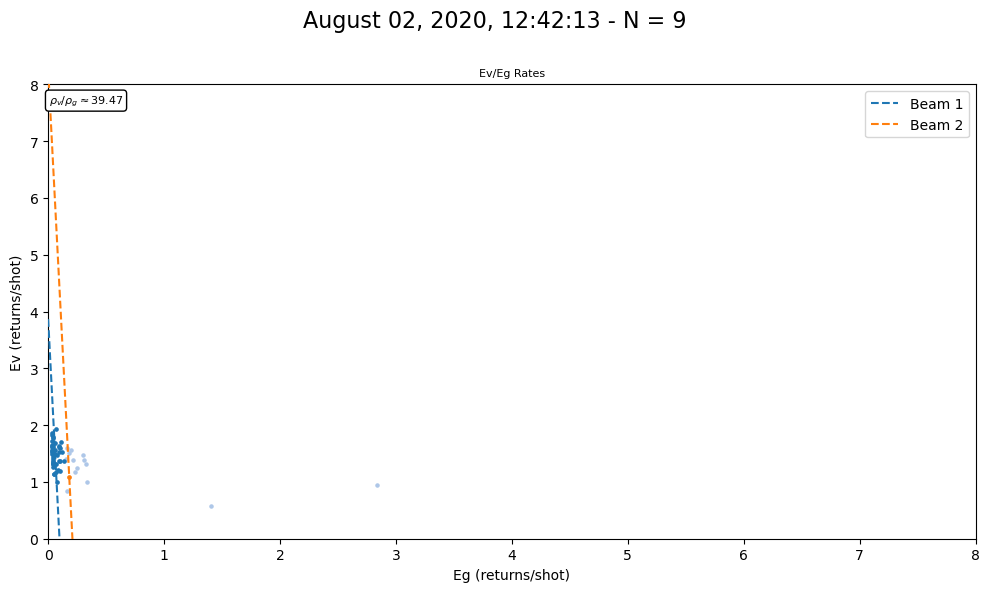

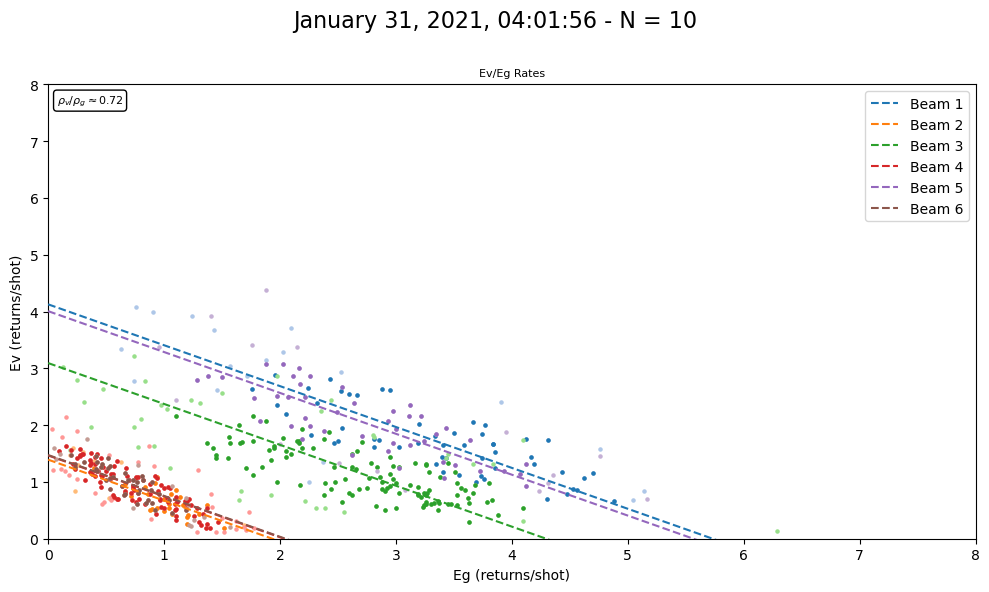

Nothing in rebinned section for lacclair file 11's beam 1.
Nothing in rebinned section for lacclair file 11's beam 2.
Nothing in rebinned section for lacclair file 11's beam 3.
Nothing in rebinned section for lacclair file 11's beam 4.
Nothing in rebinned section for lacclair file 12's beam 1.
Nothing in rebinned section for lacclair file 12's beam 2.


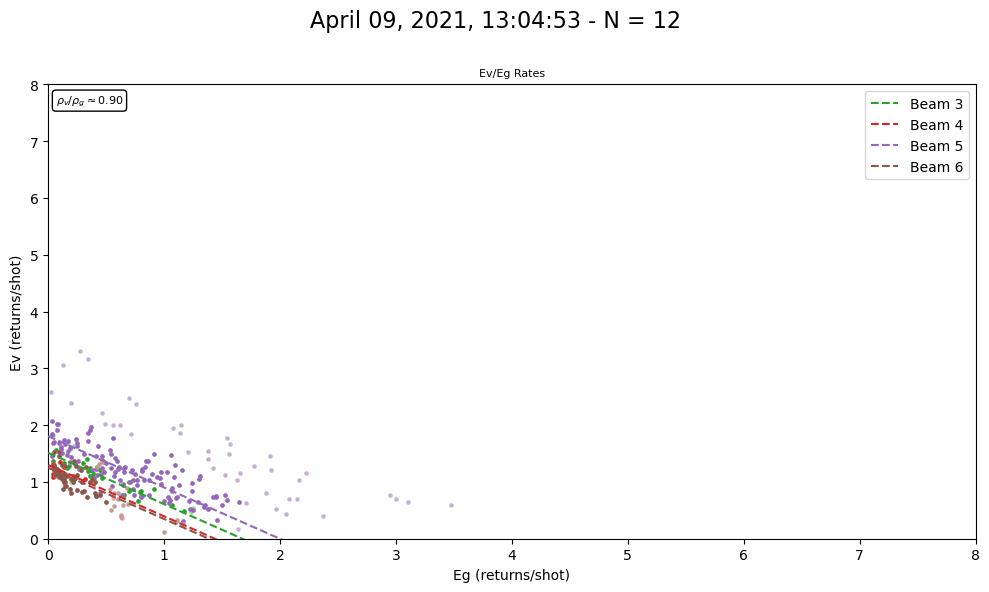

Nothing in rebinned section for lacclair file 13's beam 1.
Nothing in rebinned section for lacclair file 13's beam 2.
Nothing in rebinned section for lacclair file 13's beam 3.
Nothing in rebinned section for lacclair file 13's beam 4.
Nothing in rebinned section for lacclair file 13's beam 5.
Nothing in rebinned section for lacclair file 13's beam 6.
Nothing in rebinned section for lacclair file 14's beam 1.
Nothing in rebinned section for lacclair file 14's beam 2.


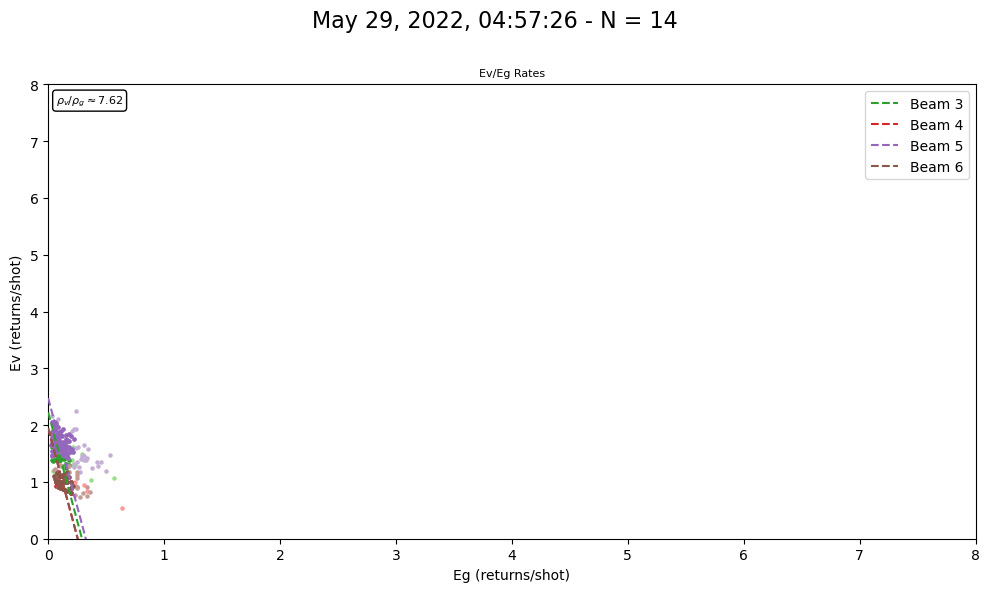

/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope =

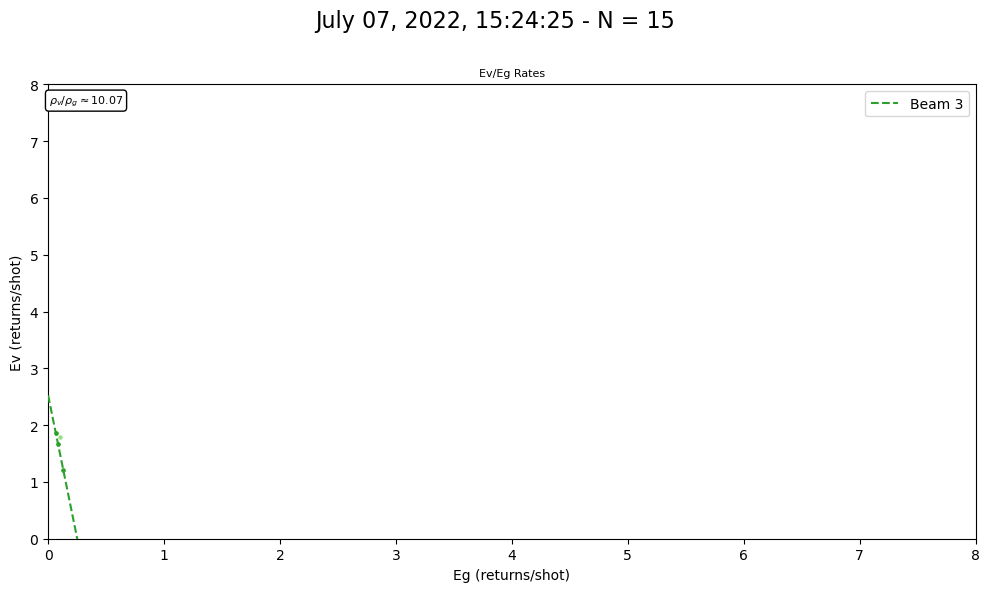

Nothing in rebinned section for lacclair file 16's beam 3.
Nothing in rebinned section for lacclair file 16's beam 4.
Nothing in rebinned section for lacclair file 16's beam 5.
Nothing in rebinned section for lacclair file 16's beam 6.


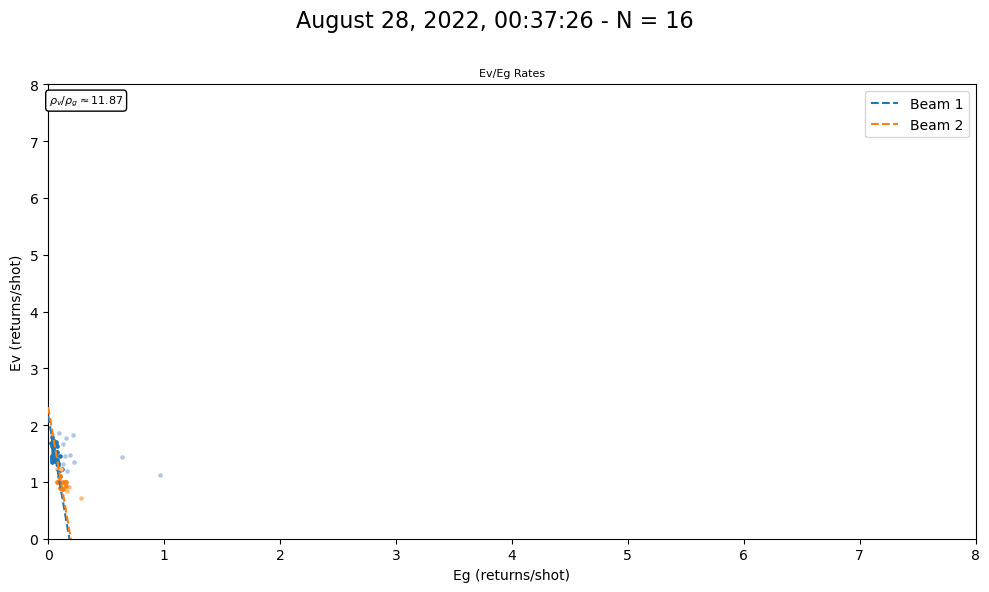

Nothing in rebinned section for lacclair file 17's beam 1.
Nothing in rebinned section for lacclair file 17's beam 2.
Nothing in rebinned section for lacclair file 17's beam 3.
Nothing in rebinned section for lacclair file 17's beam 4.
Nothing in rebinned section for lacclair file 17's beam 5.
Nothing in rebinned section for lacclair file 17's beam 6.
Nothing in rebinned section for lacclair file 18's beam 1.
Nothing in rebinned section for lacclair file 18's beam 2.
Nothing in rebinned section for lacclair file 18's beam 4.


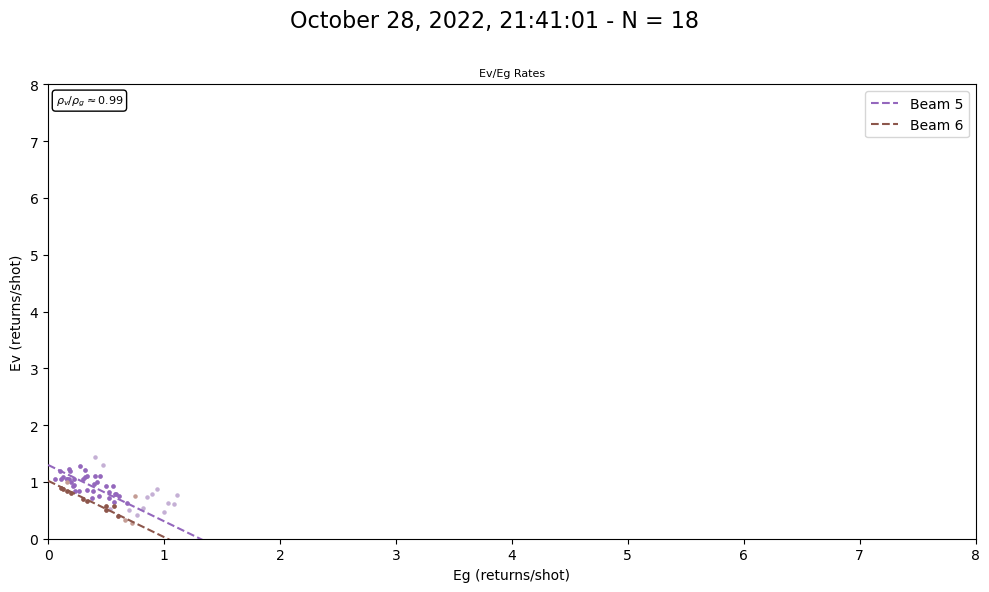

Nothing in rebinned section for lacclair file 19's beam 1.
Nothing in rebinned section for lacclair file 19's beam 2.
Nothing in rebinned section for lacclair file 19's beam 3.
Nothing in rebinned section for lacclair file 19's beam 4.
Nothing in rebinned section for lacclair file 19's beam 5.
Nothing in rebinned section for lacclair file 19's beam 6.
Nothing in rebinned section for lacclair file 20's beam 1.
Nothing in rebinned section for lacclair file 20's beam 2.
Nothing in rebinned section for lacclair file 20's beam 3.
Nothing in rebinned section for lacclair file 20's beam 4.


/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope =

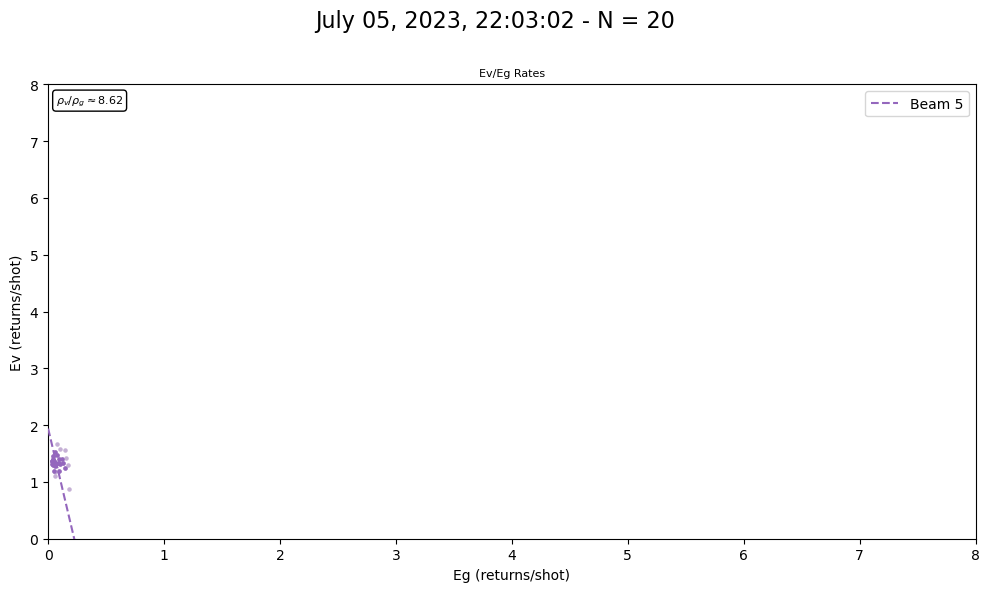

Nothing in rebinned section for lacclair file 21's beam 1.
Nothing in rebinned section for lacclair file 21's beam 2.
Nothing in rebinned section for lacclair file 21's beam 3.
Nothing in rebinned section for lacclair file 21's beam 4.


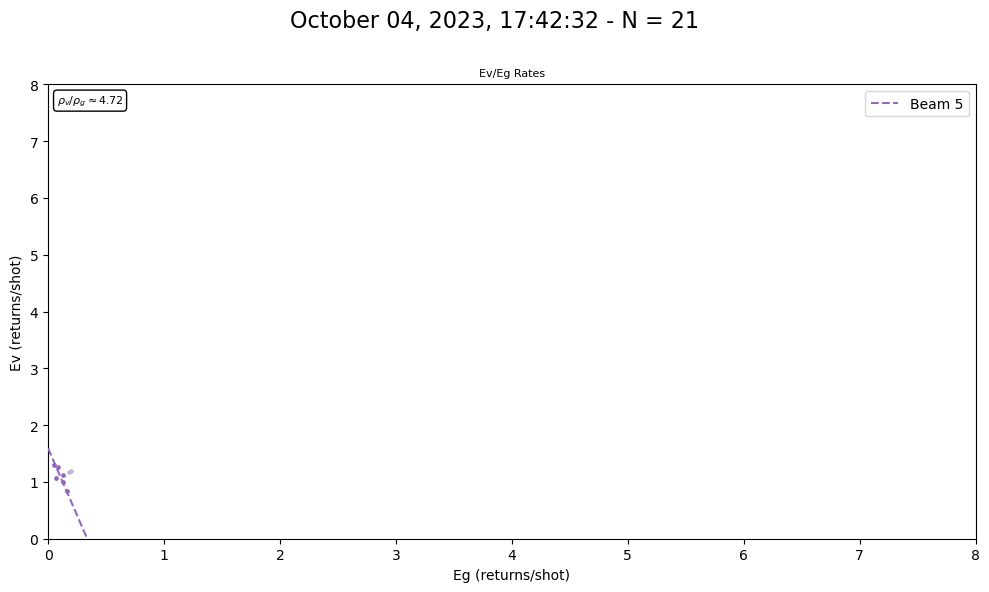

Nothing in rebinned section for lacclair file 22's beam 5.
Nothing in rebinned section for lacclair file 22's beam 6.


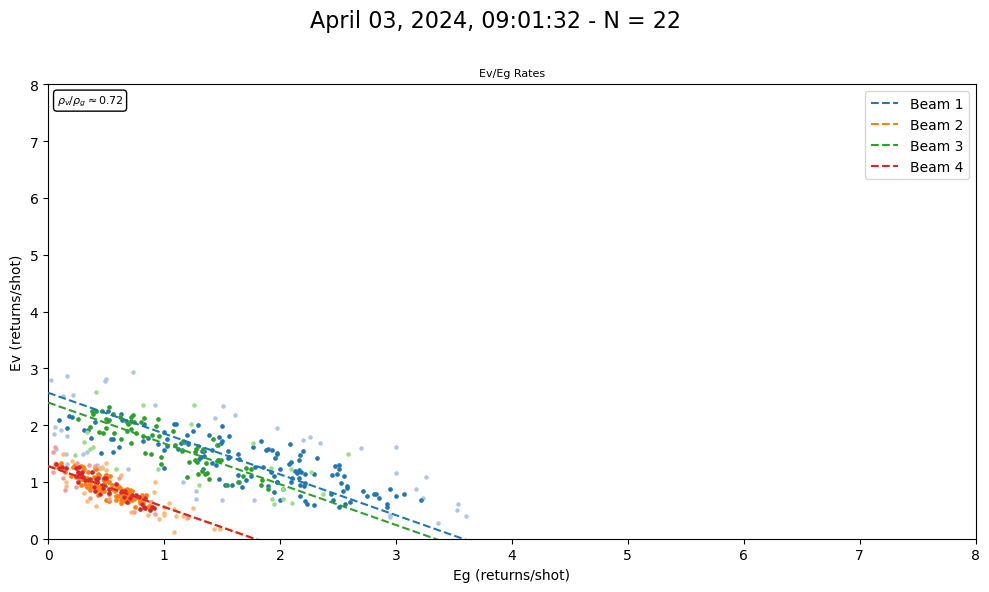

Nothing in rebinned section for lacclair file 23's beam 1.
Nothing in rebinned section for lacclair file 23's beam 2.


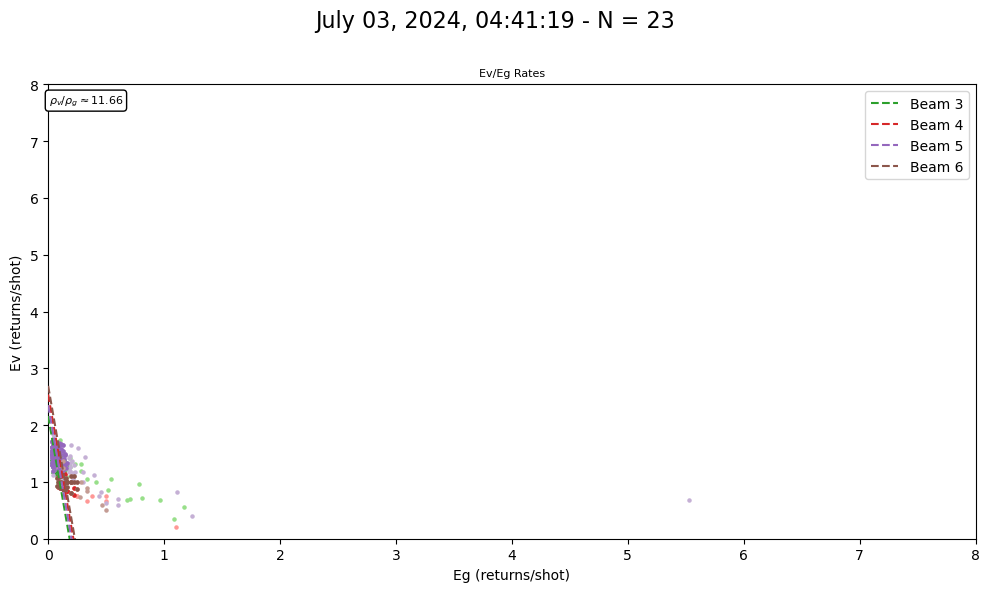

In [2]:
from scripts.parallel_blocks import *

dirpath = '../data_store/data/lacclair/'

all_ATL03, all_ATL08, failed_ATL03 = track_pairs(dirpath, failed=True)
N = len(all_ATL03)

coords = (-71.6696, 46.9521)

for i in range(N):
    data = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i], coords=coords, width=4,height=4,file_index=i, alt_thresh=80,\
                         altitude=313, threshold=1, small_box=8.05, graph_detail=1, loss='linear', rebinned=30, f_scale=.05,\
                         outlier_removal=.1,method='bimodal')

# Torgnon

Nothing in rebinned section for torgnon file 0's beam 5.
Nothing in rebinned section for torgnon file 0's beam 6.


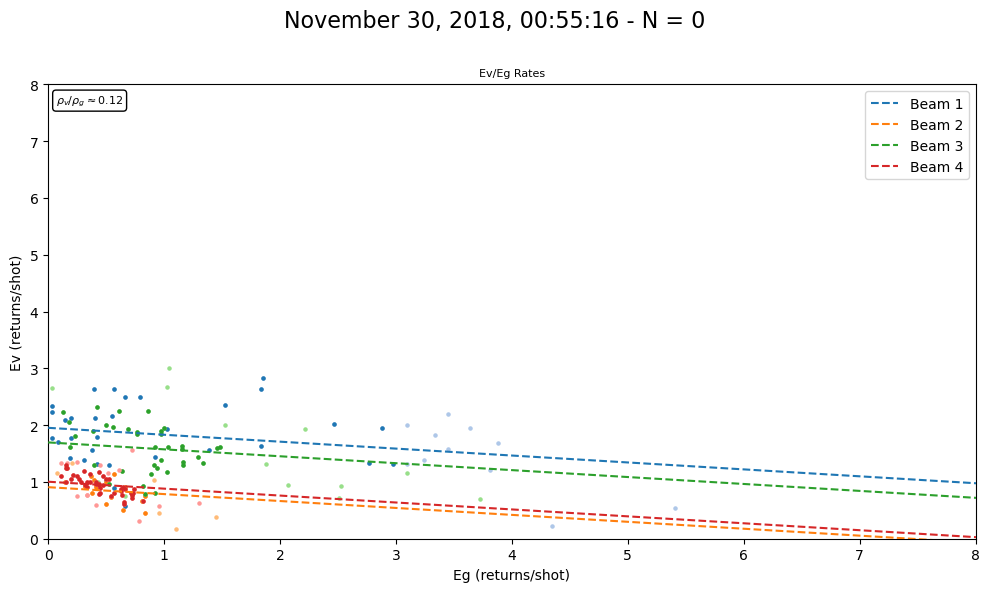

Nothing in rebinned section for torgnon file 1's beam 5.
Nothing in rebinned section for torgnon file 1's beam 6.


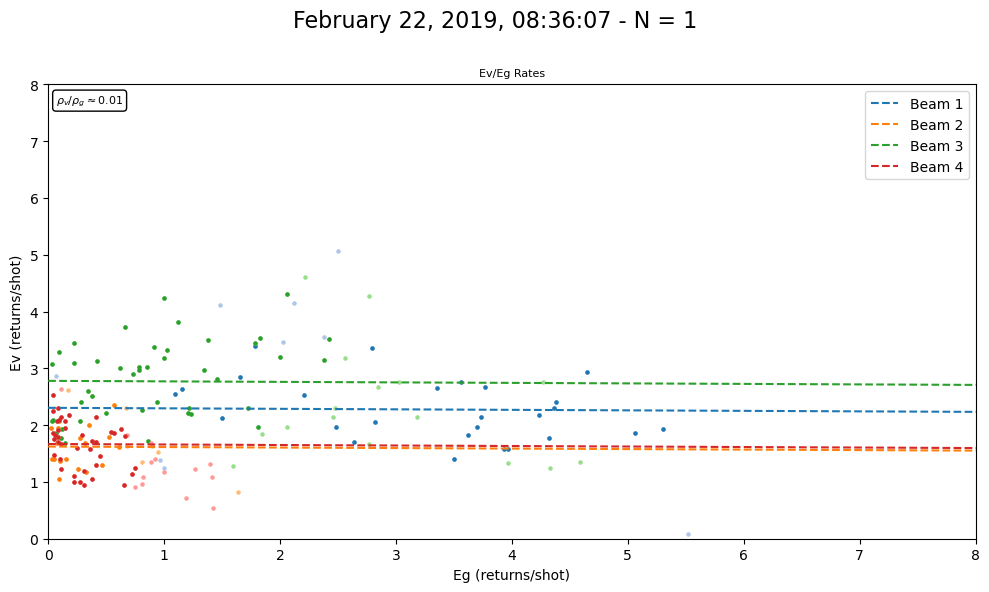

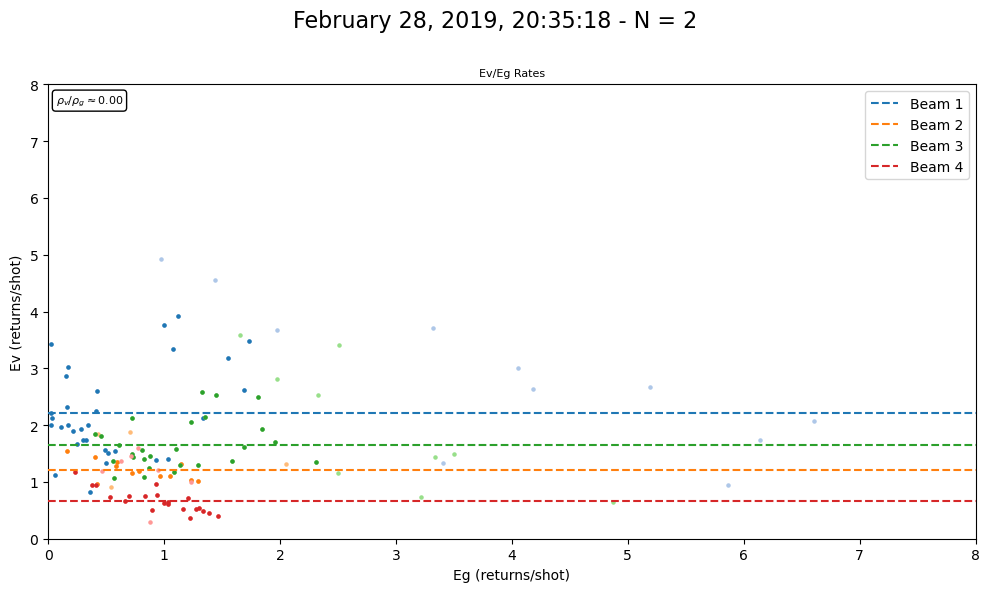

Nothing in rebinned section for torgnon file 3's beam 5.
Nothing in rebinned section for torgnon file 3's beam 6.


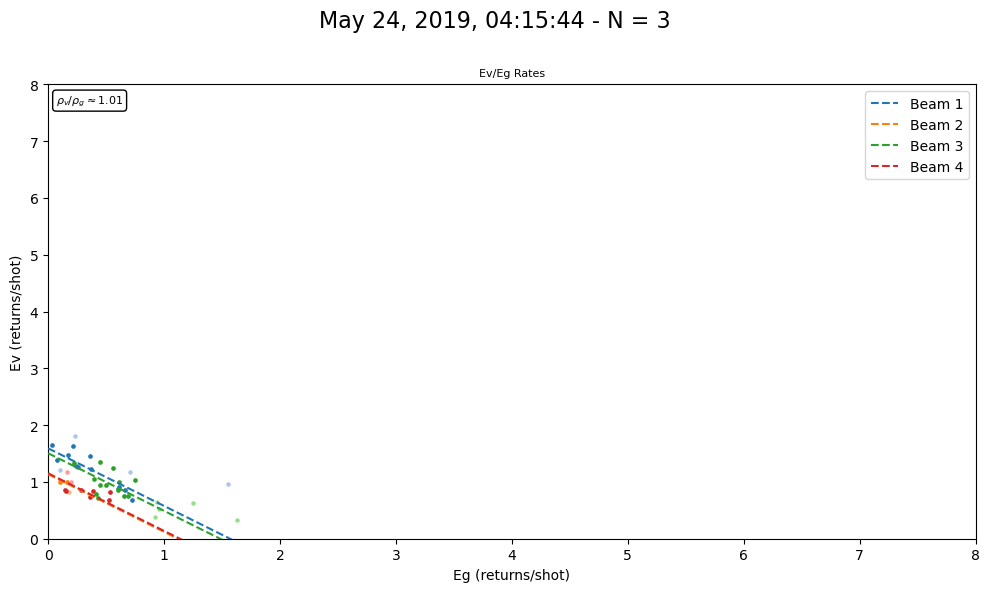

Nothing in rebinned section for torgnon file 4's beam 1.
Nothing in rebinned section for torgnon file 4's beam 2.


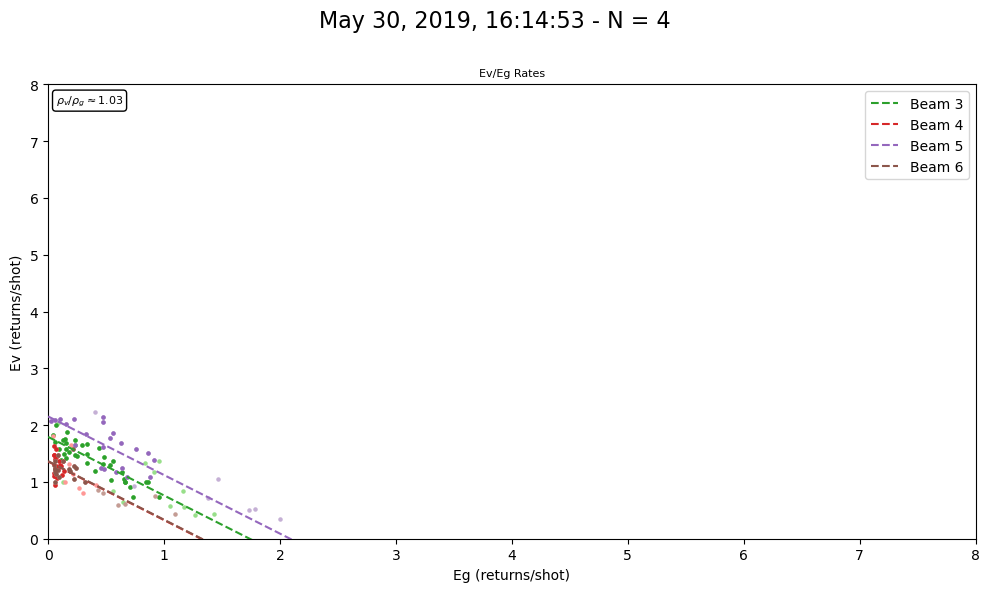

Nothing in rebinned section for torgnon file 5's beam 1.
Nothing in rebinned section for torgnon file 5's beam 2.
Nothing in rebinned section for torgnon file 5's beam 3.
Nothing in rebinned section for torgnon file 5's beam 4.
Nothing in rebinned section for torgnon file 5's beam 5.
Nothing in rebinned section for torgnon file 5's beam 6.
Nothing in rebinned section for torgnon file 6's beam 5.
Nothing in rebinned section for torgnon file 6's beam 6.


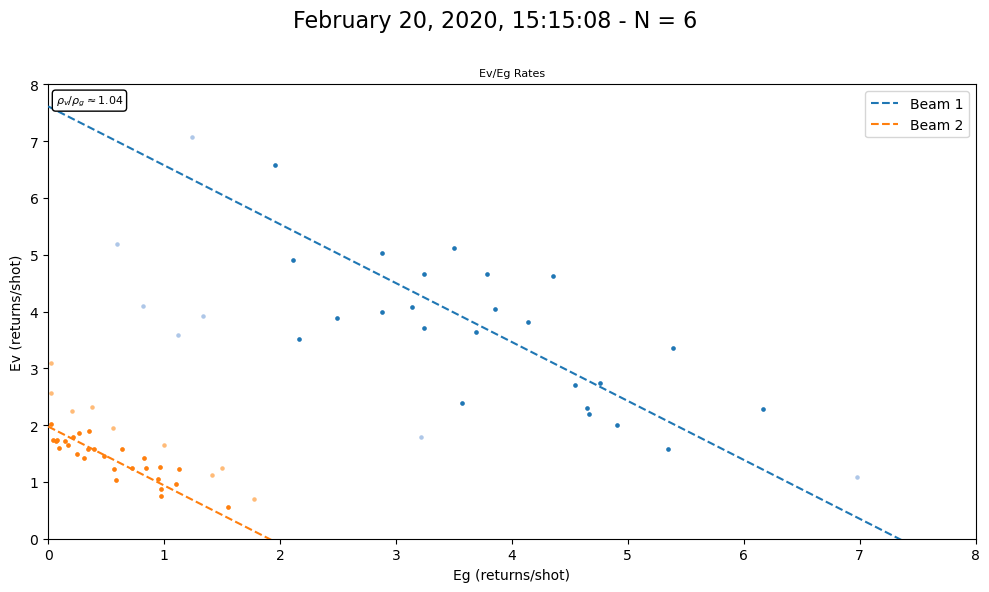

Nothing in rebinned section for torgnon file 7's beam 3.
Nothing in rebinned section for torgnon file 7's beam 4.
Nothing in rebinned section for torgnon file 7's beam 5.
Nothing in rebinned section for torgnon file 7's beam 6.


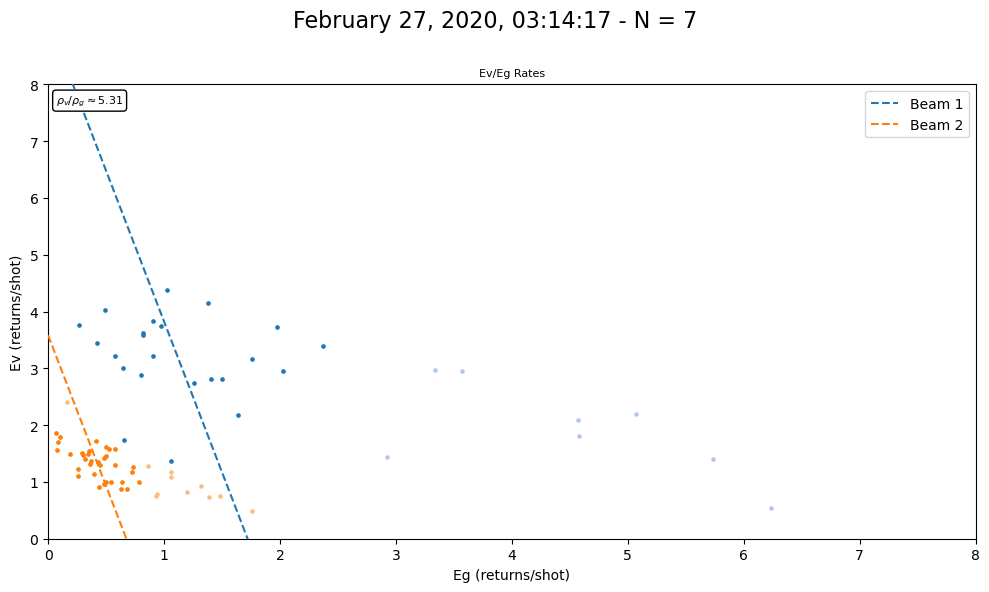

Nothing in rebinned section for torgnon file 8's beam 3.
Nothing in rebinned section for torgnon file 8's beam 4.
Nothing in rebinned section for torgnon file 8's beam 5.
Nothing in rebinned section for torgnon file 8's beam 6.


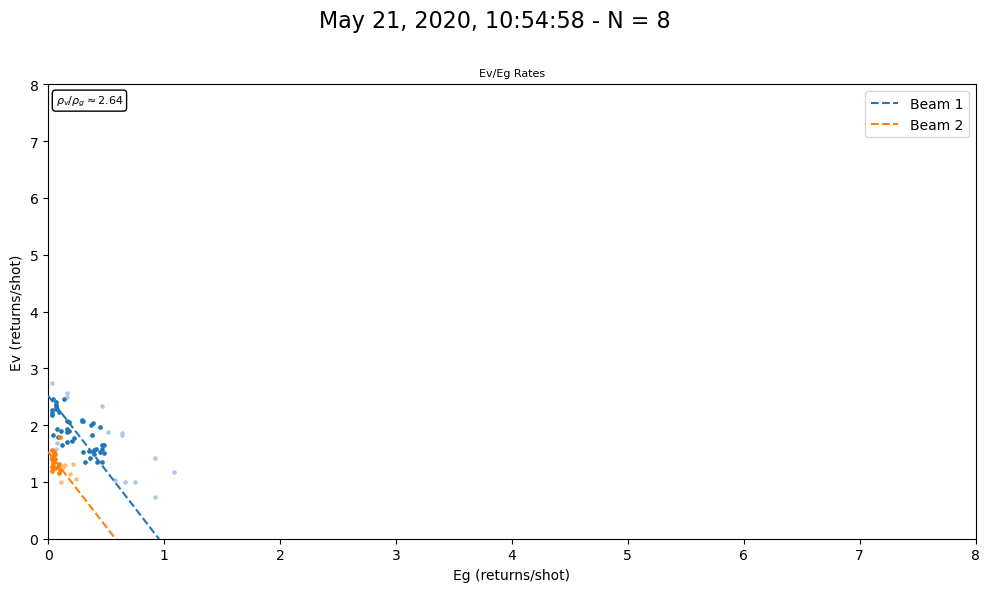

Nothing in rebinned section for torgnon file 9's beam 1.
Nothing in rebinned section for torgnon file 9's beam 2.


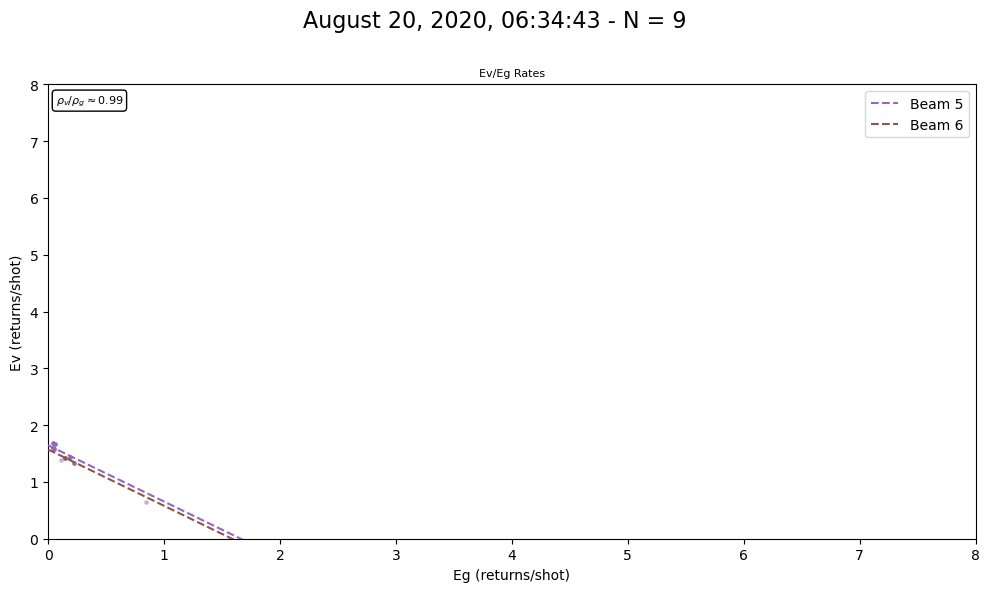

Nothing in rebinned section for torgnon file 10's beam 1.
Nothing in rebinned section for torgnon file 10's beam 2.
Nothing in rebinned section for torgnon file 10's beam 3.
Nothing in rebinned section for torgnon file 10's beam 4.


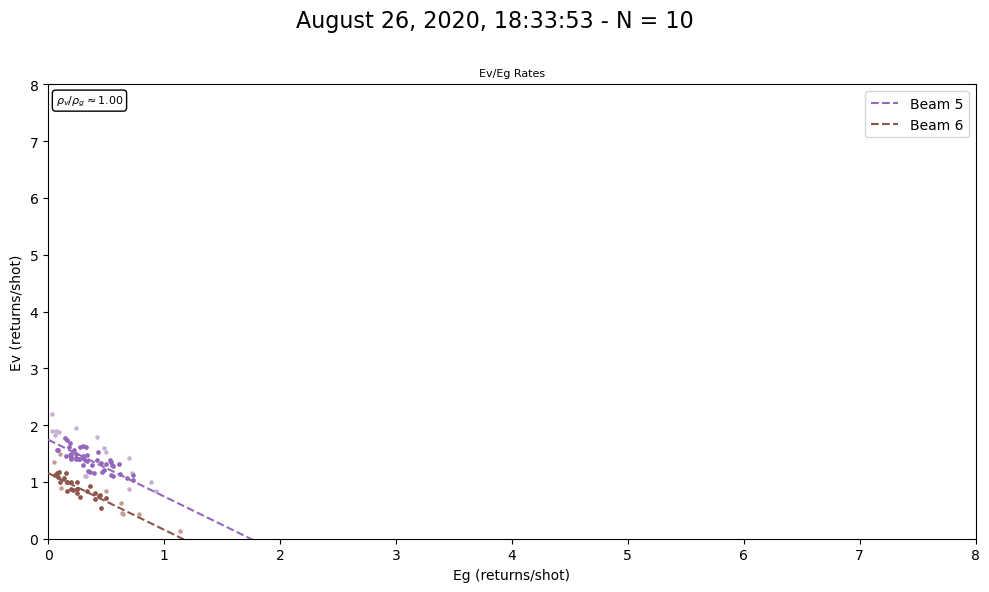

Nothing in rebinned section for torgnon file 11's beam 5.
Nothing in rebinned section for torgnon file 11's beam 6.


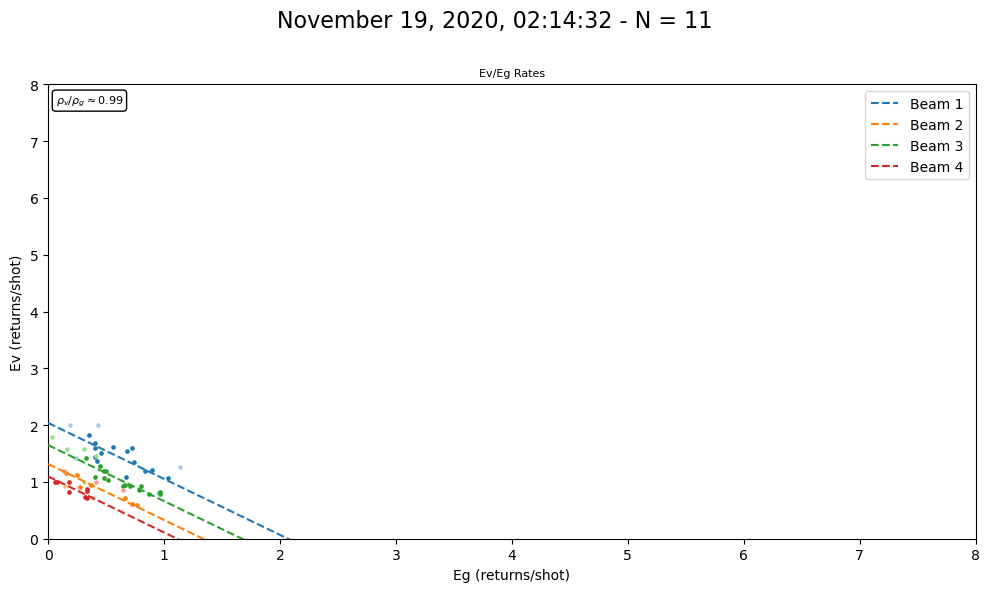

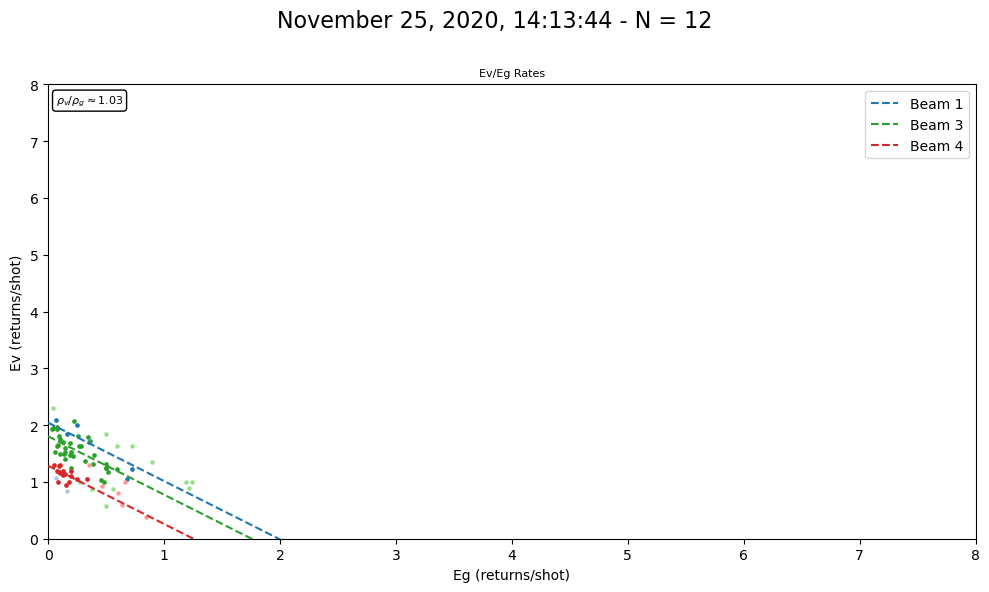

Nothing in rebinned section for torgnon file 13's beam 3.
Nothing in rebinned section for torgnon file 13's beam 4.
Nothing in rebinned section for torgnon file 13's beam 5.
Nothing in rebinned section for torgnon file 13's beam 6.
Nothing in rebinned section for torgnon file 14's beam 1.
Nothing in rebinned section for torgnon file 14's beam 2.
Nothing in rebinned section for torgnon file 14's beam 3.
Nothing in rebinned section for torgnon file 14's beam 4.


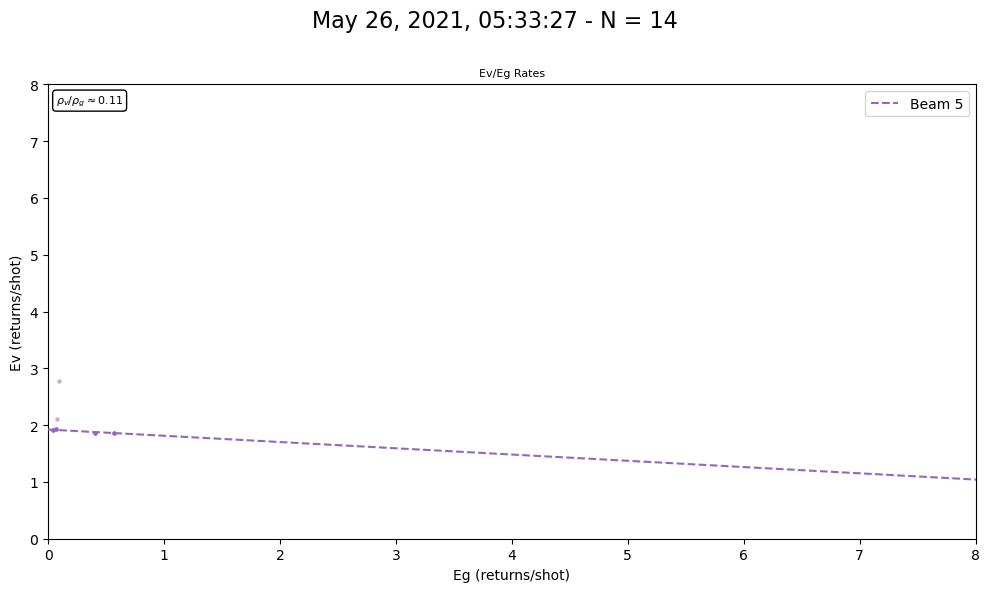

Nothing in rebinned section for torgnon file 15's beam 1.
Nothing in rebinned section for torgnon file 15's beam 2.


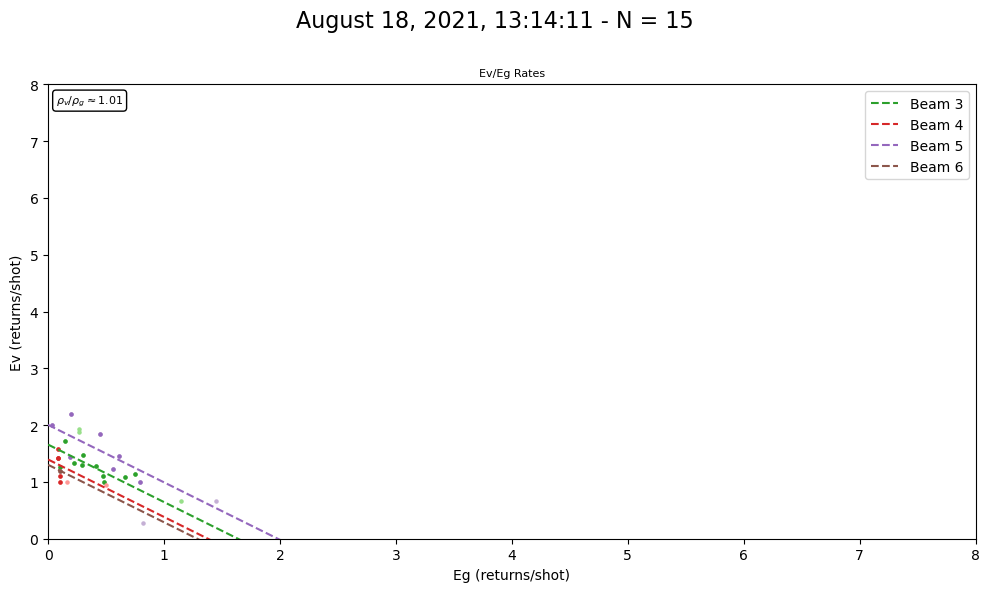

Nothing in rebinned section for torgnon file 16's beam 5.
Nothing in rebinned section for torgnon file 16's beam 6.


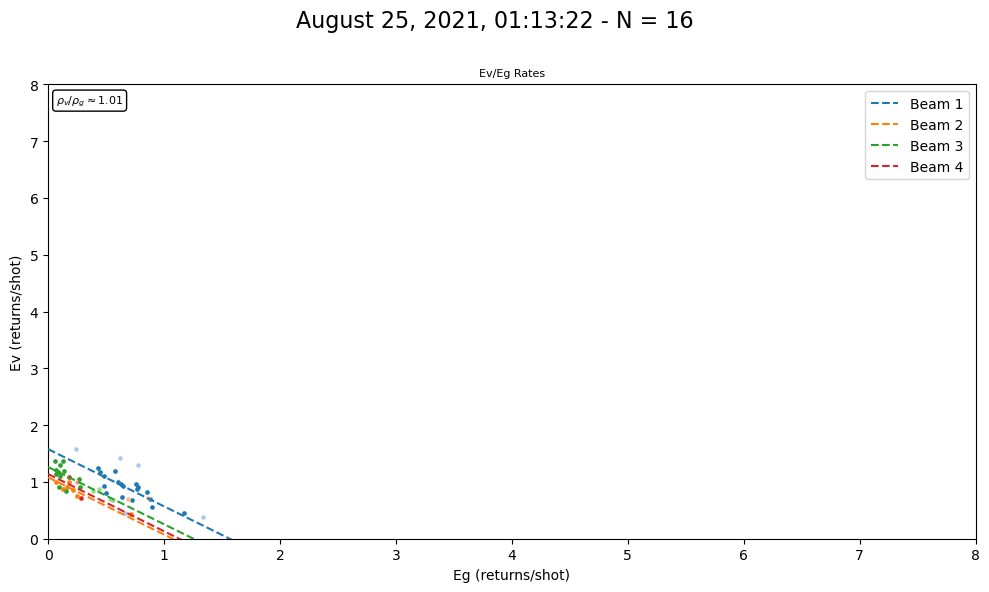

Nothing in rebinned section for torgnon file 17's beam 5.
Nothing in rebinned section for torgnon file 17's beam 6.


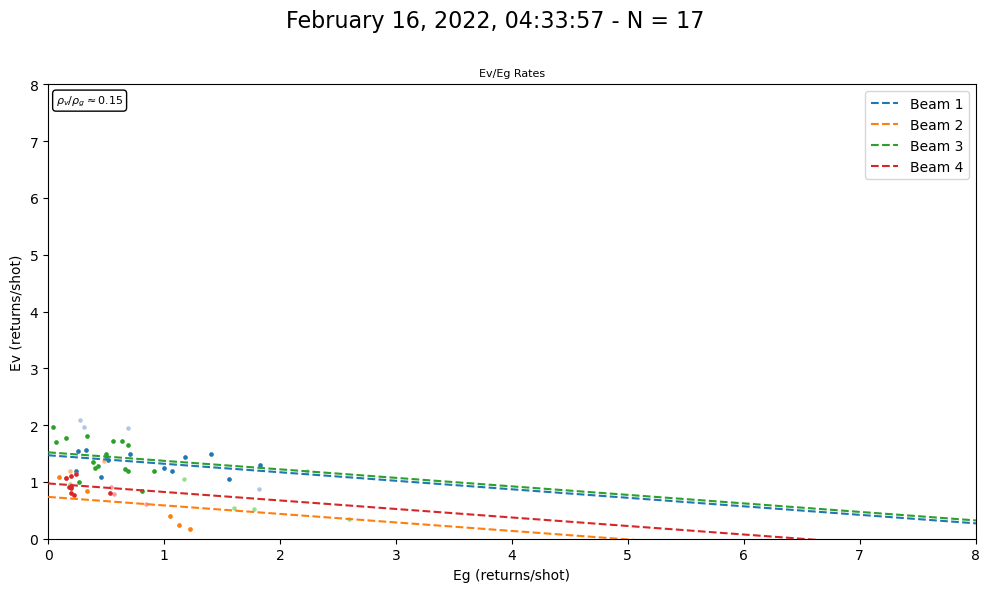

Nothing in rebinned section for torgnon file 18's beam 1.
Nothing in rebinned section for torgnon file 18's beam 2.


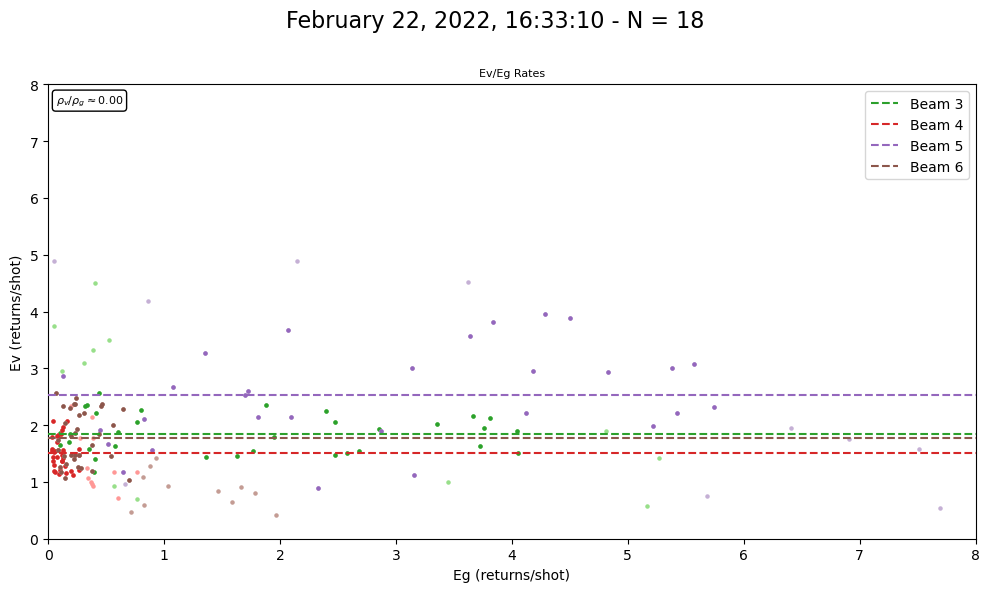

Nothing in rebinned section for torgnon file 19's beam 3.
Nothing in rebinned section for torgnon file 19's beam 4.
Nothing in rebinned section for torgnon file 19's beam 5.
Nothing in rebinned section for torgnon file 19's beam 6.
Nothing in rebinned section for torgnon file 20's beam 1.
Nothing in rebinned section for torgnon file 20's beam 2.
Nothing in rebinned section for torgnon file 20's beam 3.
Nothing in rebinned section for torgnon file 20's beam 4.


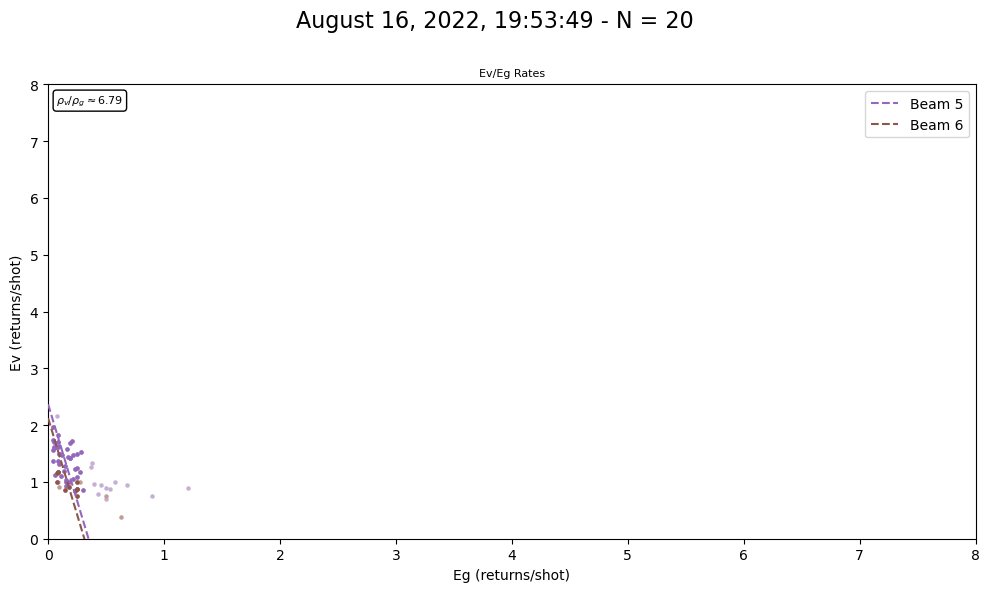

Nothing in rebinned section for torgnon file 21's beam 1.
Nothing in rebinned section for torgnon file 21's beam 2.


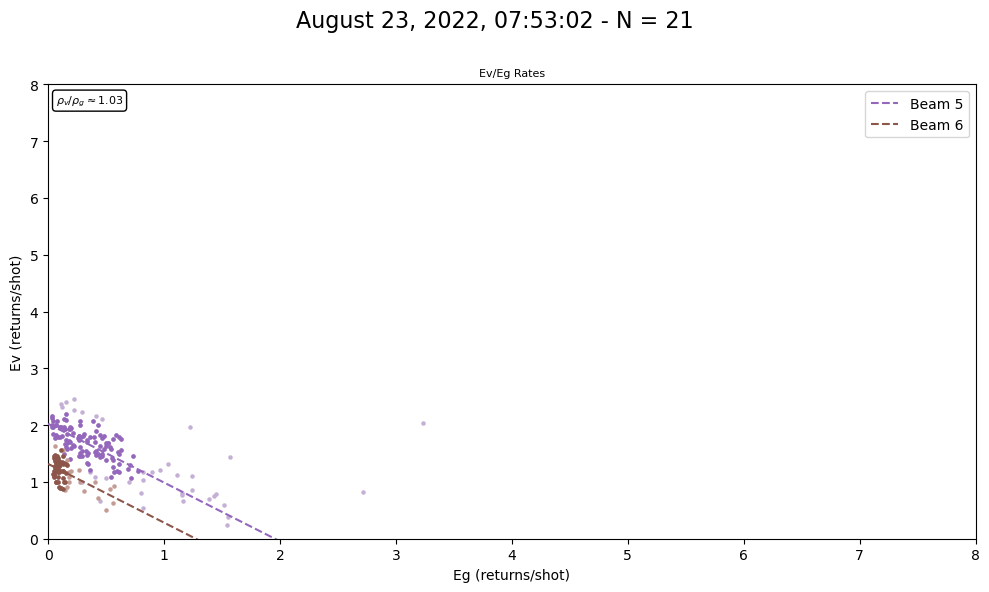

Nothing in rebinned section for torgnon file 22's beam 5.
Nothing in rebinned section for torgnon file 22's beam 6.


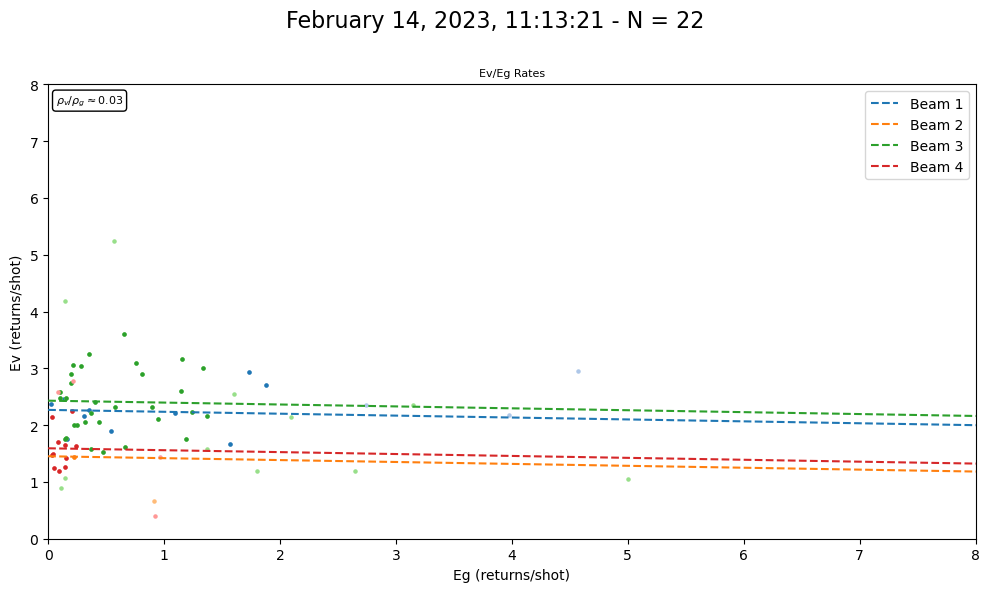

Nothing in rebinned section for torgnon file 23's beam 1.
Nothing in rebinned section for torgnon file 23's beam 2.


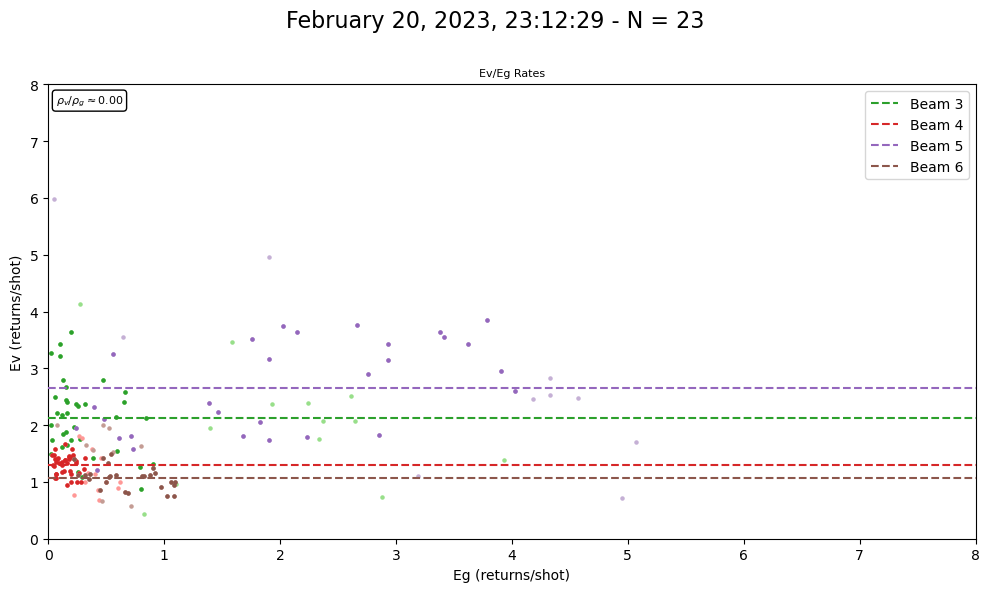

Nothing in rebinned section for torgnon file 24's beam 3.
Nothing in rebinned section for torgnon file 24's beam 4.
Nothing in rebinned section for torgnon file 24's beam 5.
Nothing in rebinned section for torgnon file 24's beam 6.


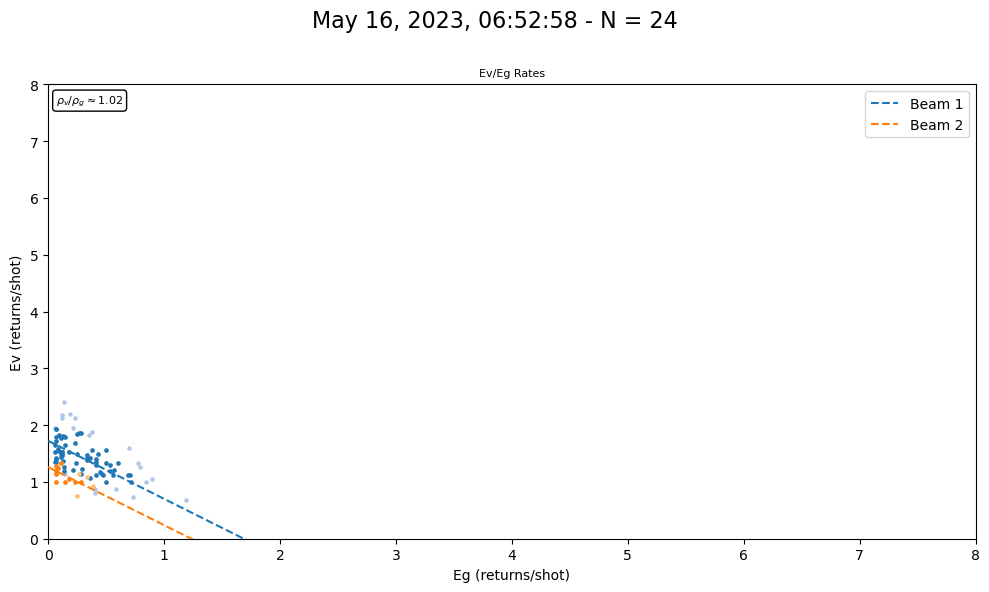

Nothing in rebinned section for torgnon file 25's beam 1.
Nothing in rebinned section for torgnon file 25's beam 2.
Nothing in rebinned section for torgnon file 25's beam 4.
Nothing in rebinned section for torgnon file 25's beam 5.
Nothing in rebinned section for torgnon file 25's beam 6.
Nothing in rebinned section for torgnon file 26's beam 2.


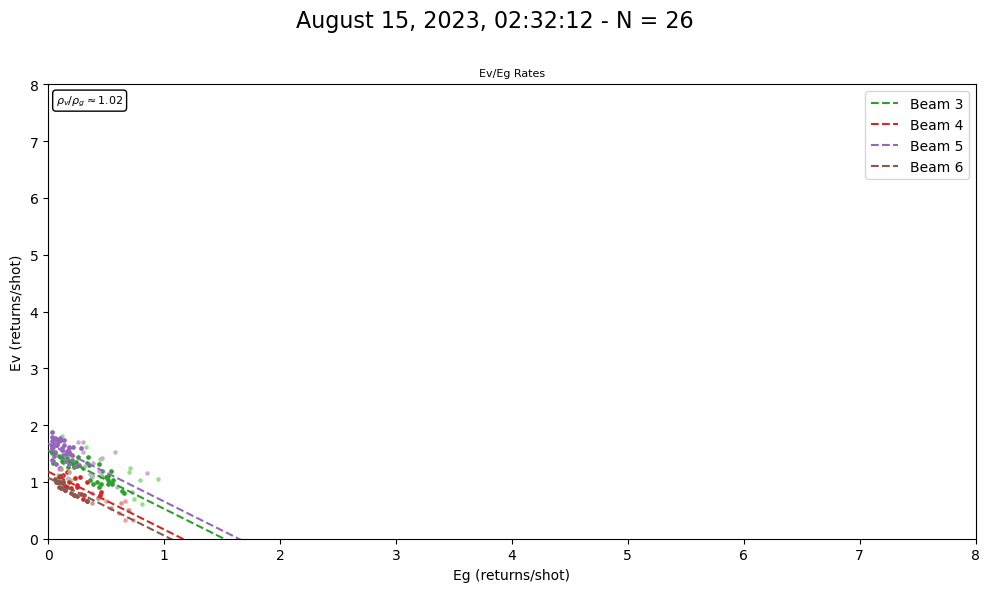

Nothing in rebinned section for torgnon file 27's beam 1.
Nothing in rebinned section for torgnon file 27's beam 2.
Nothing in rebinned section for torgnon file 27's beam 3.
Nothing in rebinned section for torgnon file 27's beam 4.


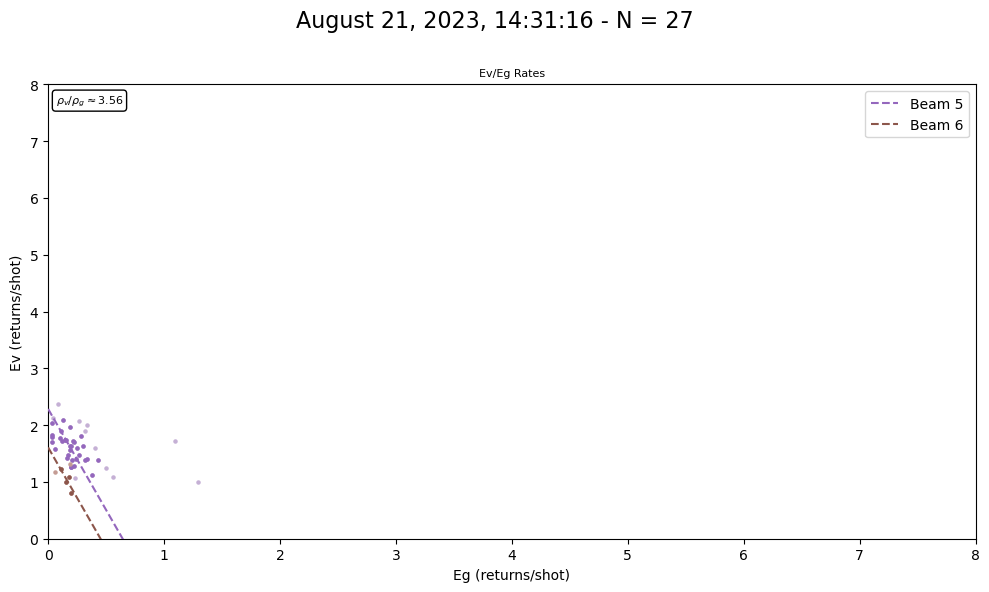

Nothing in rebinned section for torgnon file 28's beam 1.
Nothing in rebinned section for torgnon file 28's beam 2.
Nothing in rebinned section for torgnon file 28's beam 3.
Nothing in rebinned section for torgnon file 28's beam 4.
Nothing in rebinned section for torgnon file 28's beam 6.
Nothing in rebinned section for torgnon file 29's beam 5.
Nothing in rebinned section for torgnon file 29's beam 6.


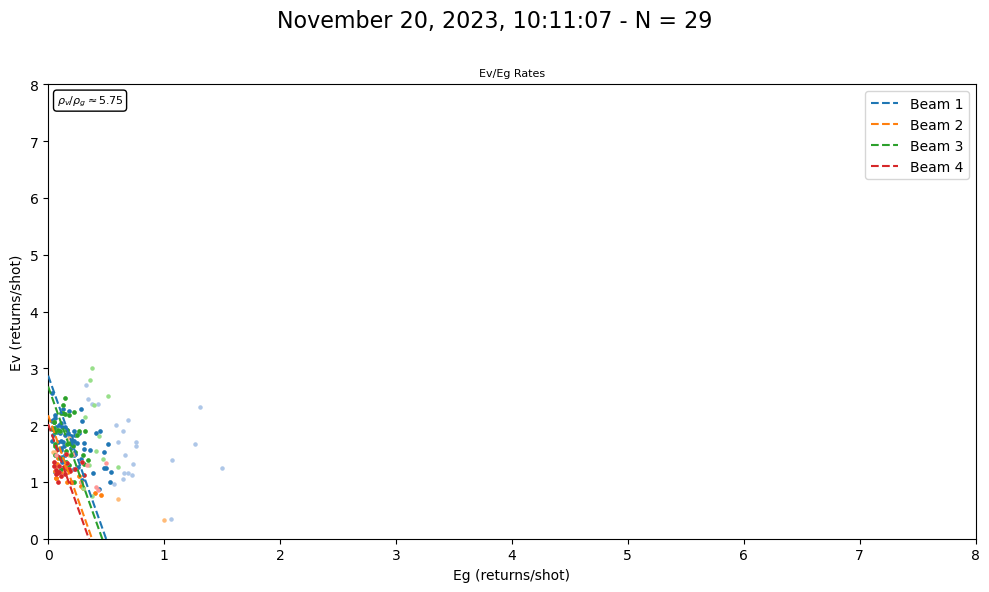

Nothing in rebinned section for torgnon file 30's beam 1.
Nothing in rebinned section for torgnon file 30's beam 2.


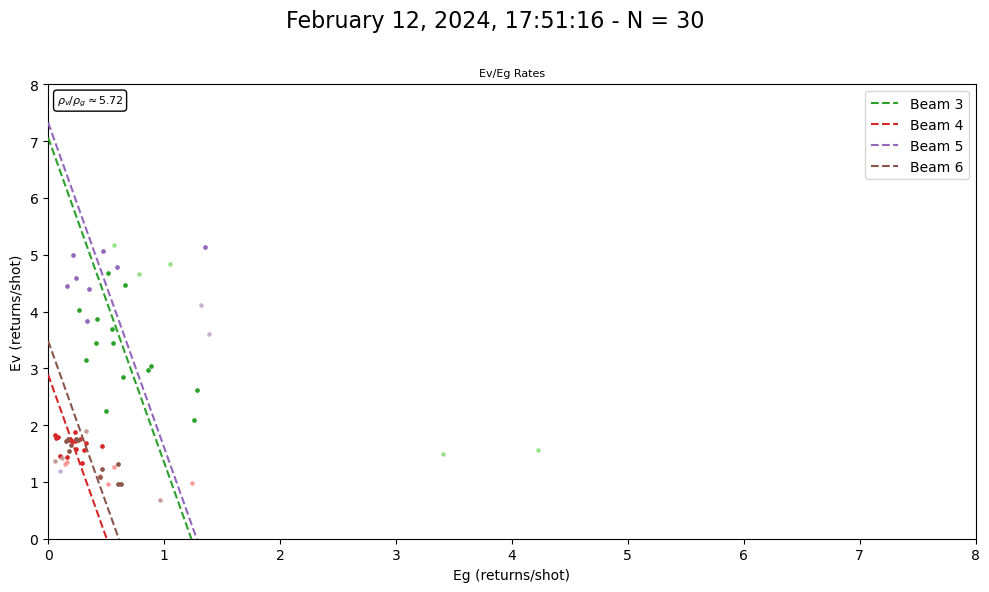

Nothing in rebinned section for torgnon file 31's beam 5.
Nothing in rebinned section for torgnon file 31's beam 6.


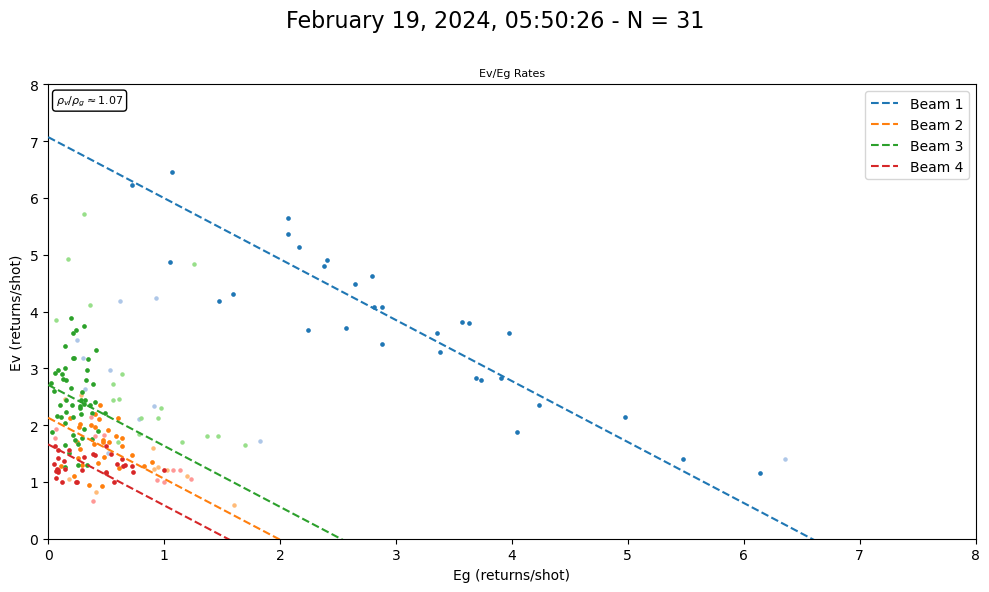

In [6]:
from scripts.parallel_blocks import *

dirpath = '../data_store/data/torgnon/'

all_ATL03, all_ATL08, failed_ATL03 = track_pairs(dirpath, failed=True)
N = len(all_ATL03)

coords = (7.5609, 45.8238)

for i in range(N):
    data = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i], coords=coords, width=4,height=4,file_index=i, alt_thresh=80,\
                         altitude=2091, threshold=1, small_box=8.05, graph_detail=1, loss='linear', rebinned=30, f_scale=.05,\
                         outlier_removal=.1,method='bimodal')

# Oregon Young Pine

29
Nothing in rebinned section for oregon_yp file 0's beam 1.
Nothing in rebinned section for oregon_yp file 0's beam 2.


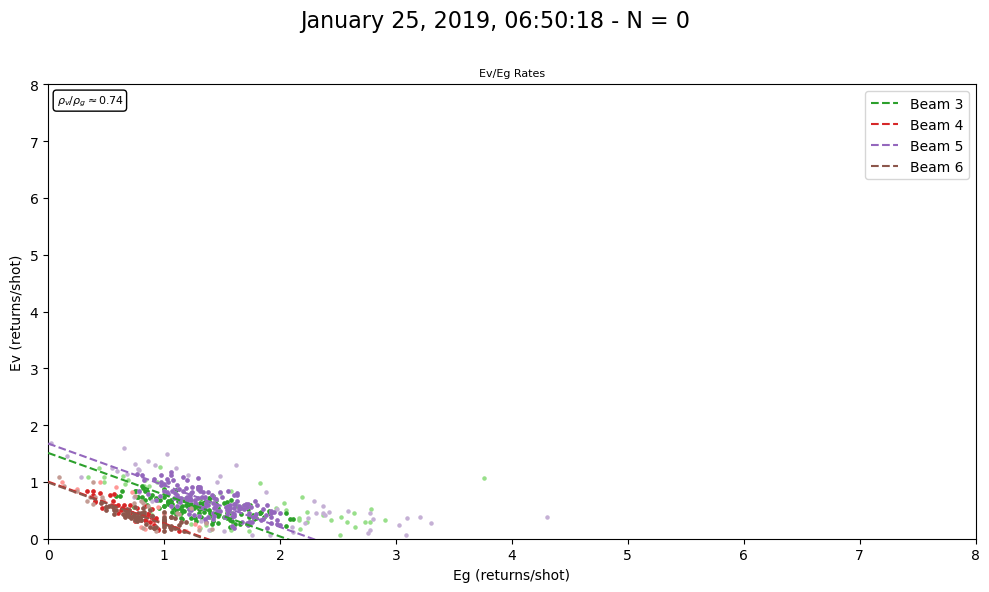

Nothing in rebinned section for oregon_yp file 1's beam 1.
Nothing in rebinned section for oregon_yp file 1's beam 2.
Nothing in rebinned section for oregon_yp file 1's beam 3.
Nothing in rebinned section for oregon_yp file 1's beam 4.
Nothing in rebinned section for oregon_yp file 1's beam 5.
Nothing in rebinned section for oregon_yp file 1's beam 6.
Nothing in rebinned section for oregon_yp file 2's beam 1.
Nothing in rebinned section for oregon_yp file 2's beam 2.
Nothing in rebinned section for oregon_yp file 2's beam 3.
Nothing in rebinned section for oregon_yp file 2's beam 4.


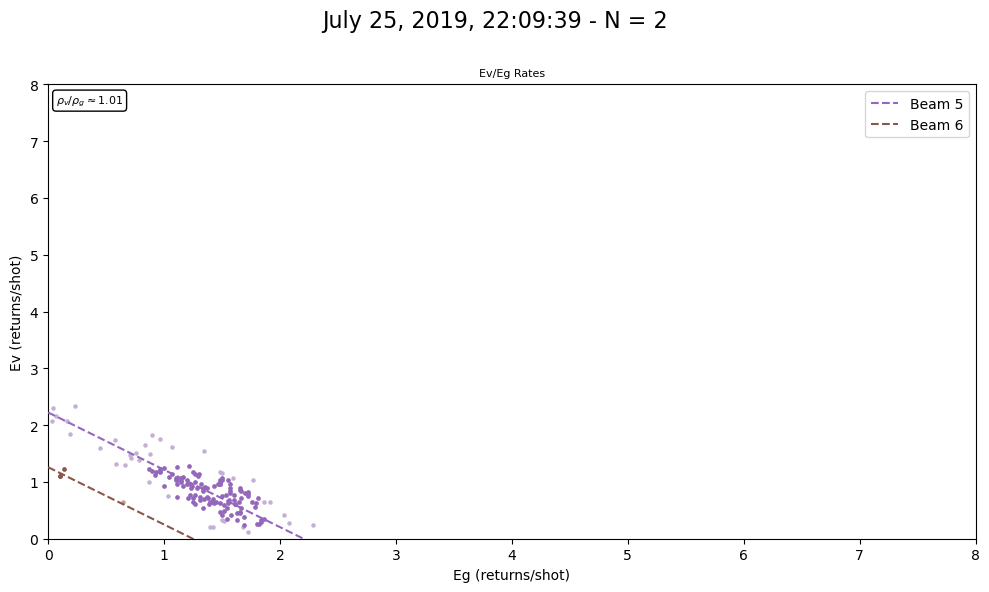

Nothing in rebinned section for oregon_yp file 3's beam 3.
Nothing in rebinned section for oregon_yp file 3's beam 4.
Nothing in rebinned section for oregon_yp file 3's beam 5.
Nothing in rebinned section for oregon_yp file 3's beam 6.


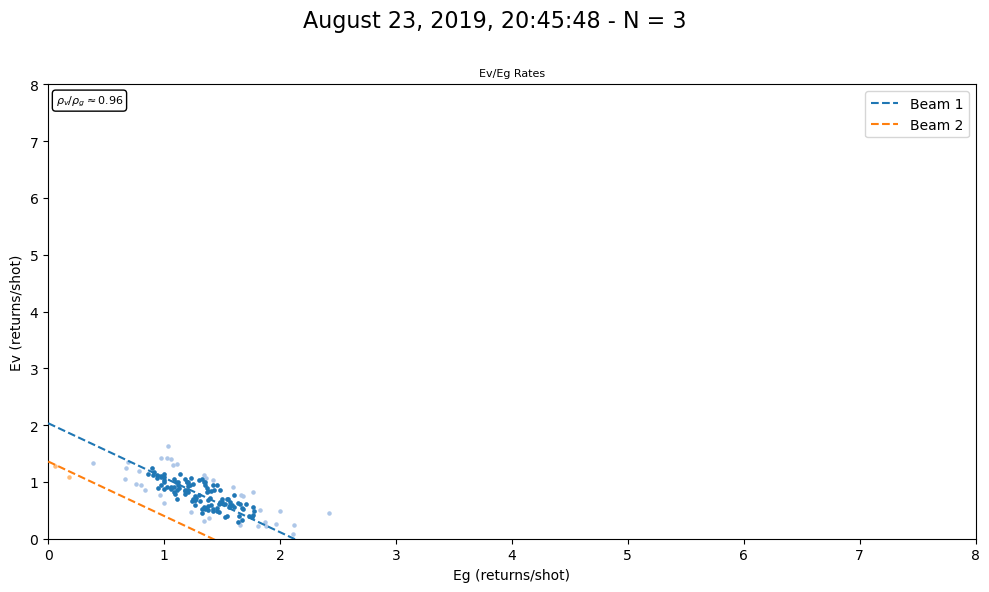

Nothing in rebinned section for oregon_yp file 4's beam 1.
Nothing in rebinned section for oregon_yp file 4's beam 2.
Nothing in rebinned section for oregon_yp file 4's beam 3.
Nothing in rebinned section for oregon_yp file 4's beam 4.
Nothing in rebinned section for oregon_yp file 4's beam 5.
Nothing in rebinned section for oregon_yp file 4's beam 6.
Nothing in rebinned section for oregon_yp file 5's beam 1.
Nothing in rebinned section for oregon_yp file 5's beam 2.
Nothing in rebinned section for oregon_yp file 5's beam 3.
Nothing in rebinned section for oregon_yp file 5's beam 4.


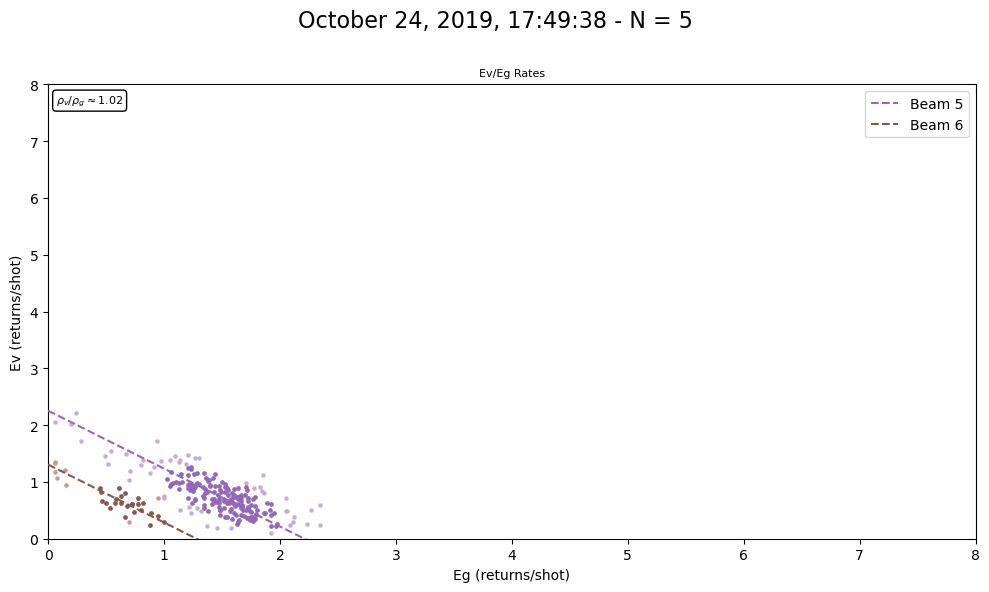

Nothing in rebinned section for oregon_yp file 6's beam 3.
Nothing in rebinned section for oregon_yp file 6's beam 4.
Nothing in rebinned section for oregon_yp file 6's beam 5.
Nothing in rebinned section for oregon_yp file 6's beam 6.


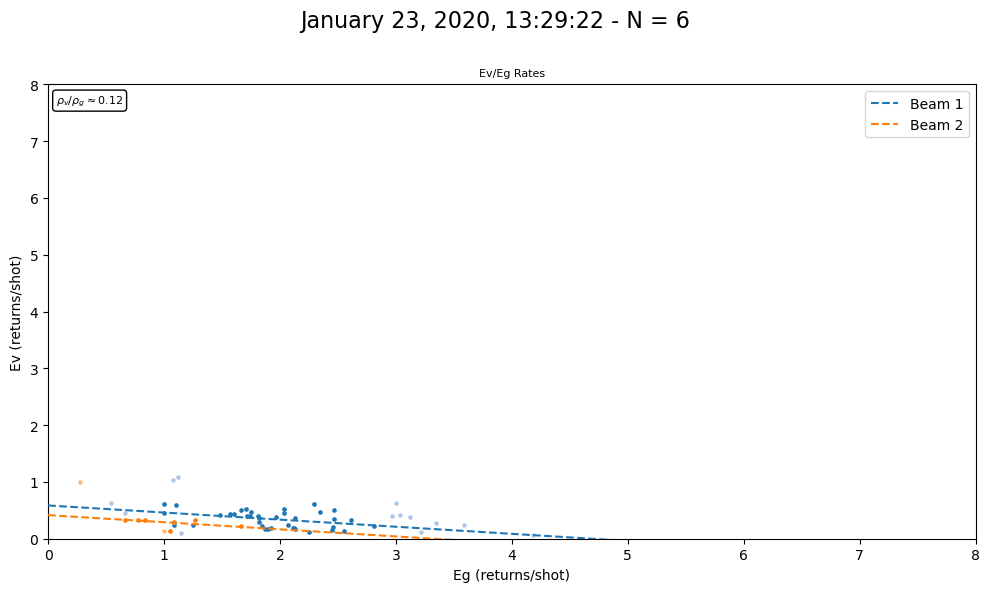

Nothing in rebinned section for oregon_yp file 7's beam 1.
Nothing in rebinned section for oregon_yp file 7's beam 2.
Nothing in rebinned section for oregon_yp file 7's beam 3.
Nothing in rebinned section for oregon_yp file 7's beam 4.
Nothing in rebinned section for oregon_yp file 8's beam 3.
Nothing in rebinned section for oregon_yp file 8's beam 4.
Nothing in rebinned section for oregon_yp file 8's beam 5.
Nothing in rebinned section for oregon_yp file 8's beam 6.


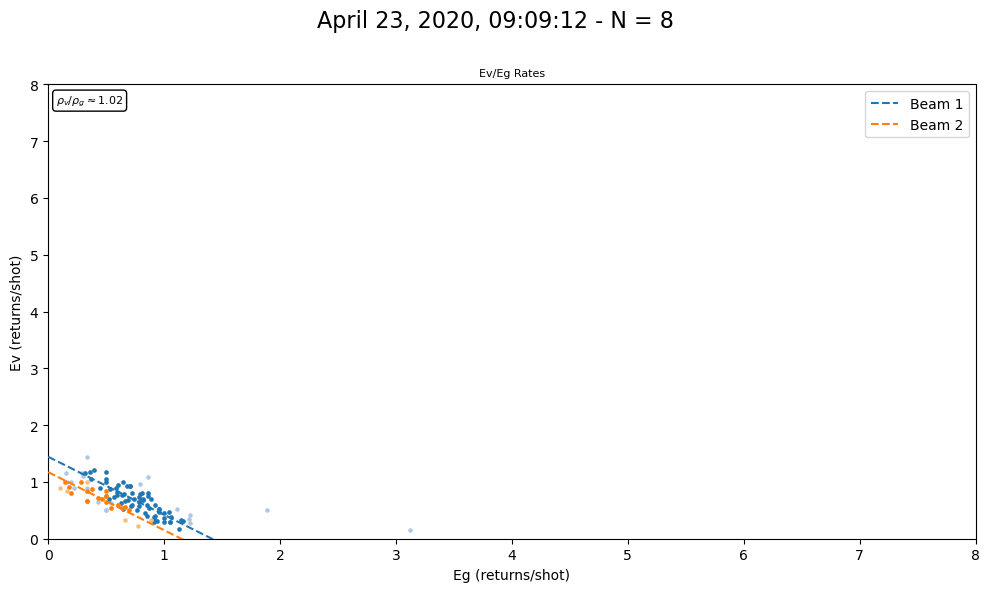

Nothing in rebinned section for oregon_yp file 9's beam 1.
Nothing in rebinned section for oregon_yp file 9's beam 2.


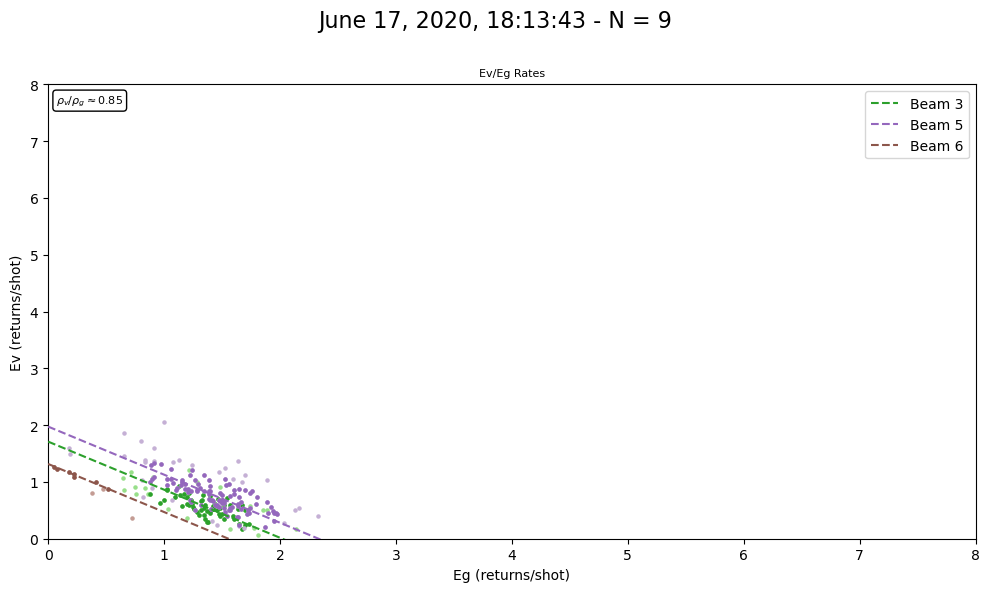

Nothing in rebinned section for oregon_yp file 10's beam 1.
Nothing in rebinned section for oregon_yp file 10's beam 2.
Nothing in rebinned section for oregon_yp file 10's beam 3.
Nothing in rebinned section for oregon_yp file 10's beam 4.


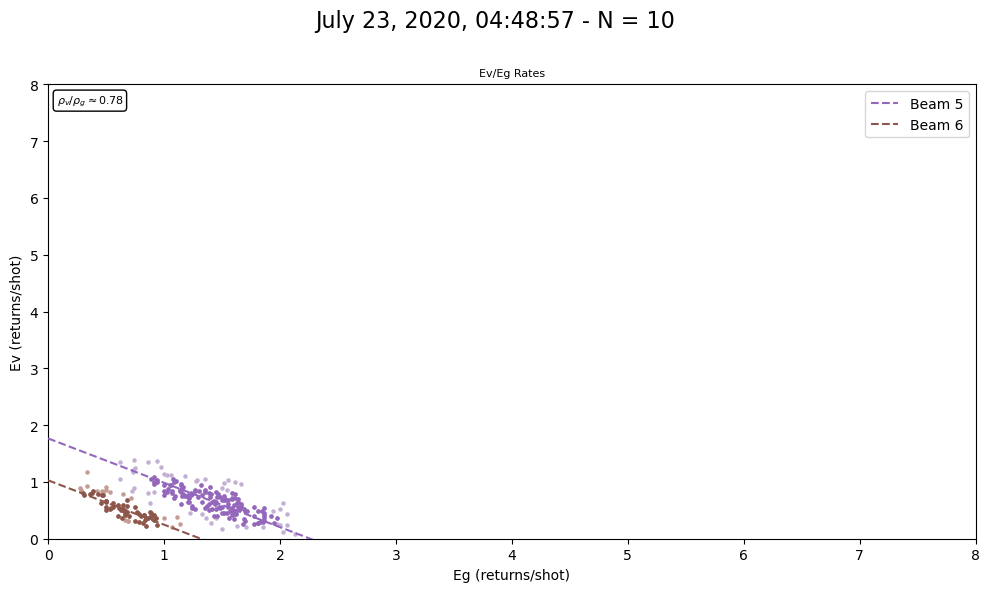

Nothing in rebinned section for oregon_yp file 11's beam 1.
Nothing in rebinned section for oregon_yp file 11's beam 2.


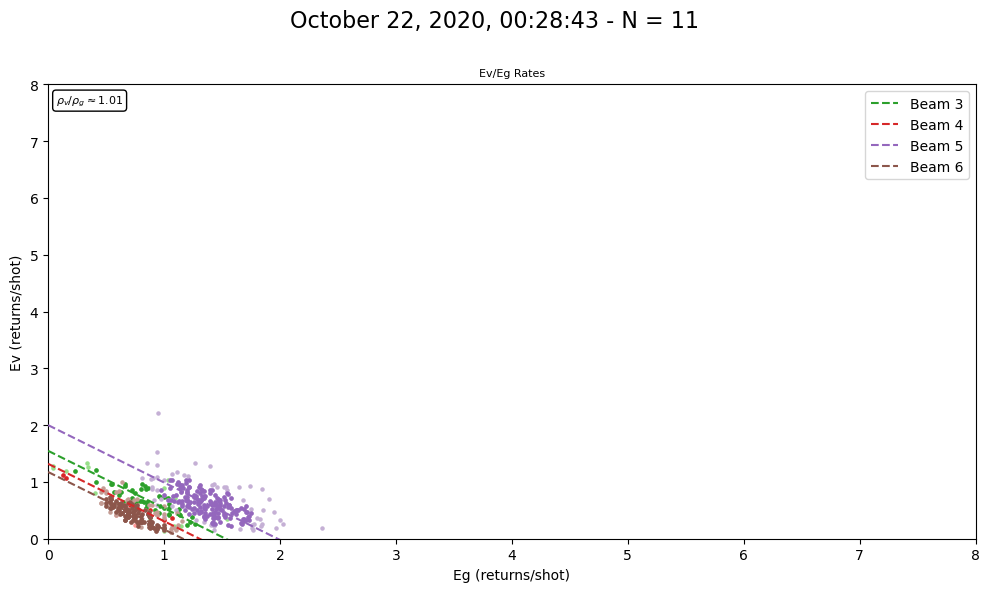

Nothing in rebinned section for oregon_yp file 12's beam 1.
Nothing in rebinned section for oregon_yp file 12's beam 2.
Nothing in rebinned section for oregon_yp file 12's beam 3.
Nothing in rebinned section for oregon_yp file 12's beam 4.


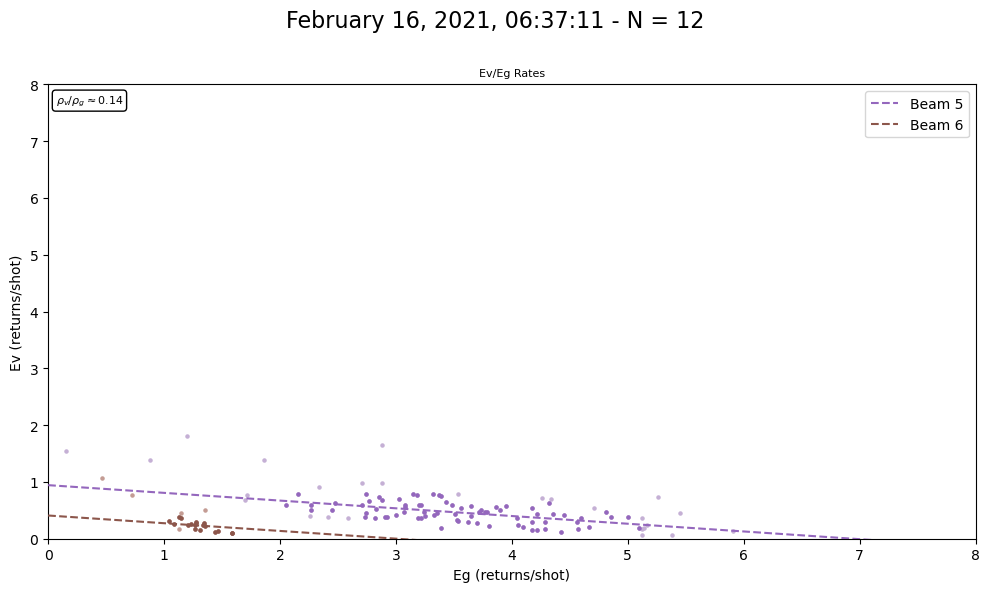

Nothing in rebinned section for oregon_yp file 13's beam 1.
Nothing in rebinned section for oregon_yp file 13's beam 2.


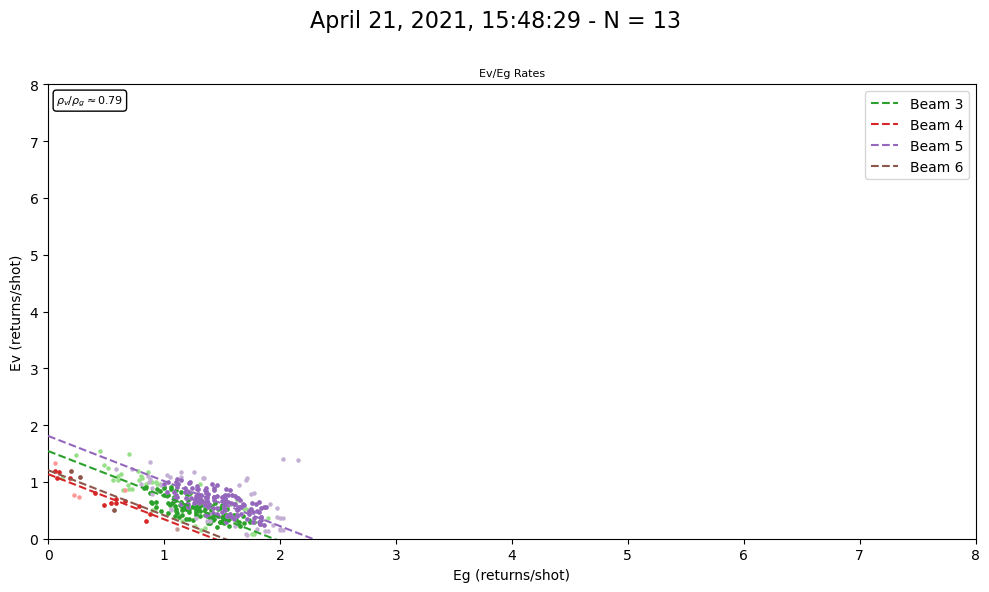

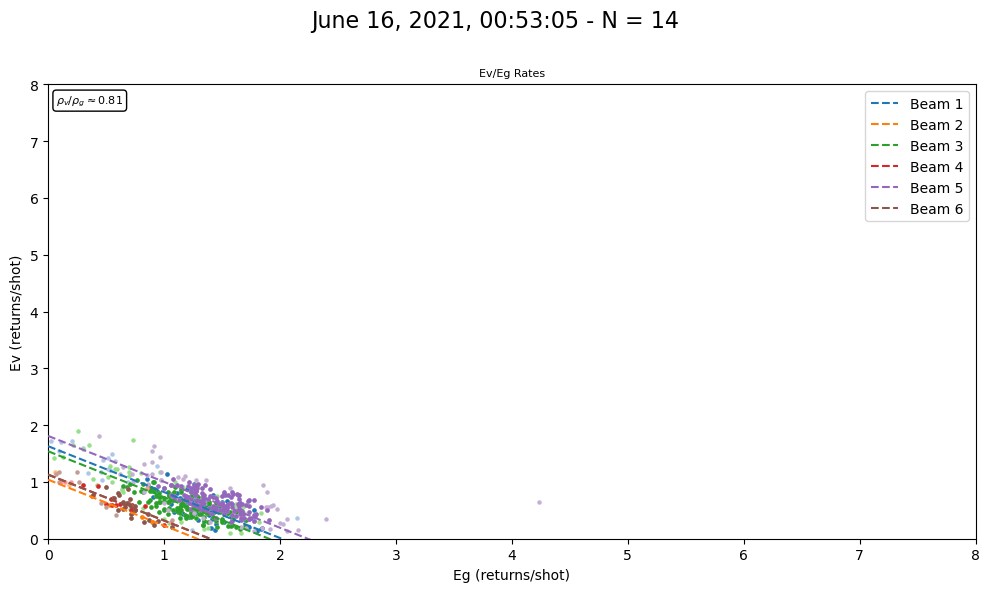

Nothing in rebinned section for oregon_yp file 15's beam 3.
Nothing in rebinned section for oregon_yp file 15's beam 4.
Nothing in rebinned section for oregon_yp file 15's beam 5.
Nothing in rebinned section for oregon_yp file 15's beam 6.


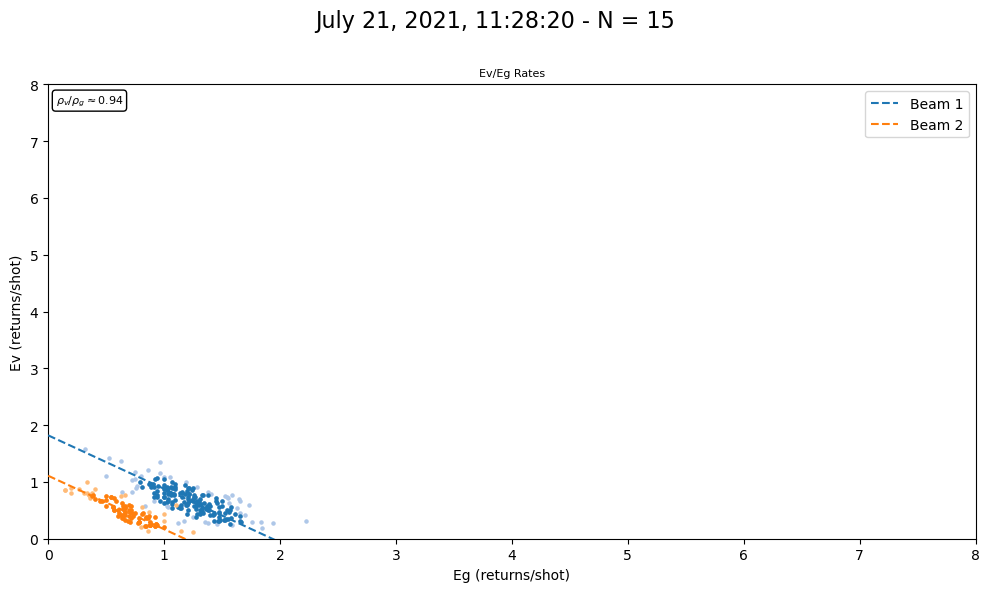

Nothing in rebinned section for oregon_yp file 16's beam 1.
Nothing in rebinned section for oregon_yp file 16's beam 2.
Nothing in rebinned section for oregon_yp file 16's beam 3.
Nothing in rebinned section for oregon_yp file 16's beam 4.
Nothing in rebinned section for oregon_yp file 16's beam 5.
Nothing in rebinned section for oregon_yp file 16's beam 6.
Nothing in rebinned section for oregon_yp file 17's beam 1.
Nothing in rebinned section for oregon_yp file 17's beam 2.
Nothing in rebinned section for oregon_yp file 17's beam 5.
Nothing in rebinned section for oregon_yp file 17's beam 6.


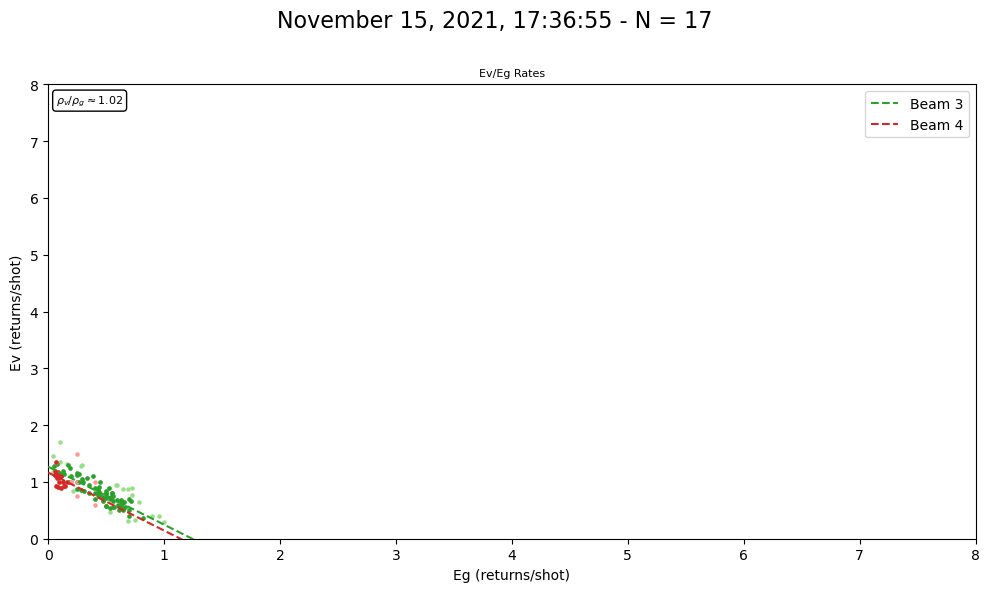

Nothing in rebinned section for oregon_yp file 18's beam 1.
Nothing in rebinned section for oregon_yp file 18's beam 2.
Nothing in rebinned section for oregon_yp file 18's beam 3.
Nothing in rebinned section for oregon_yp file 18's beam 4.


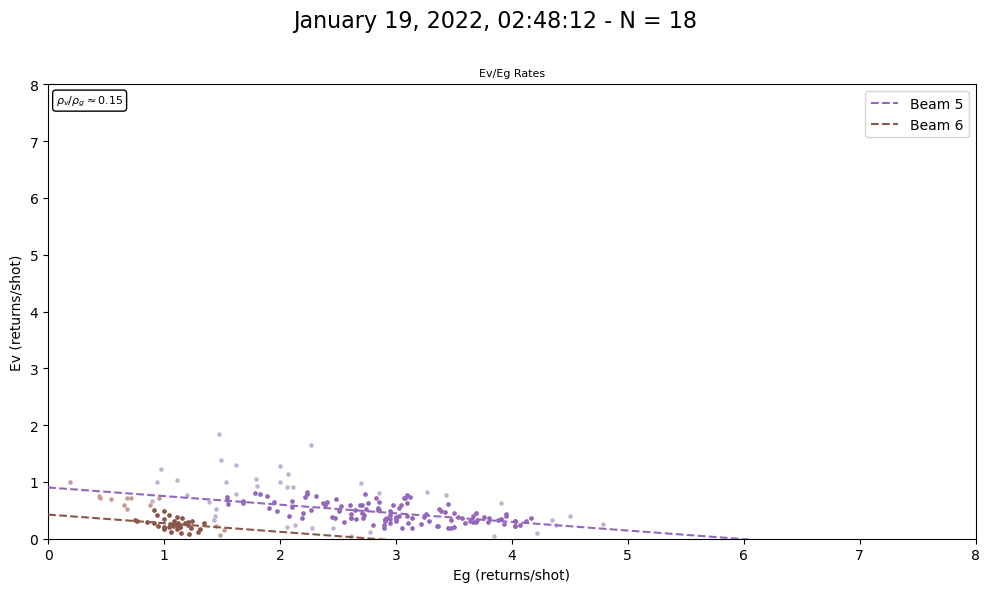

Nothing in rebinned section for oregon_yp file 19's beam 1.
Nothing in rebinned section for oregon_yp file 19's beam 2.
Nothing in rebinned section for oregon_yp file 19's beam 3.
Nothing in rebinned section for oregon_yp file 19's beam 4.


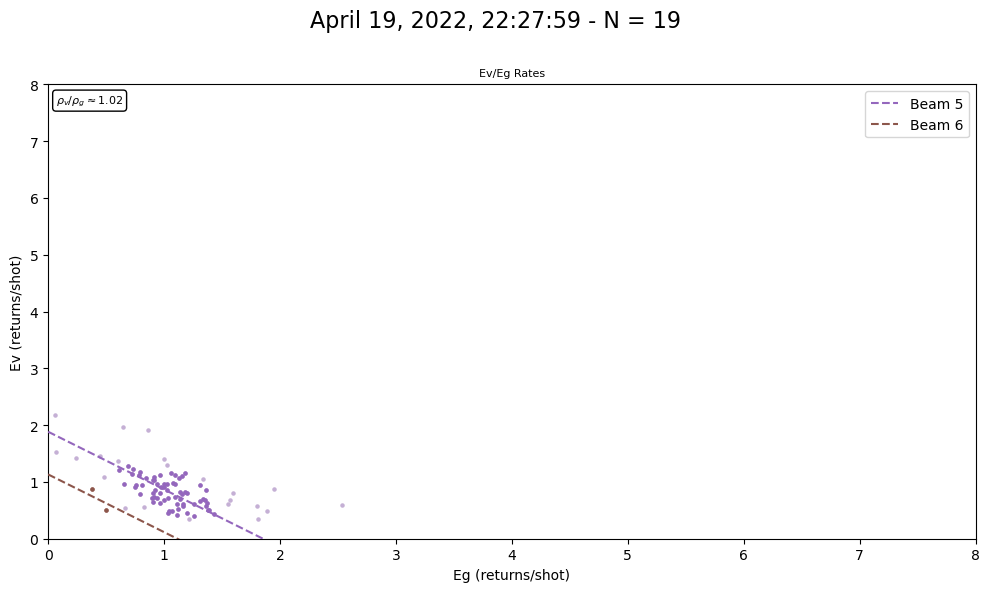

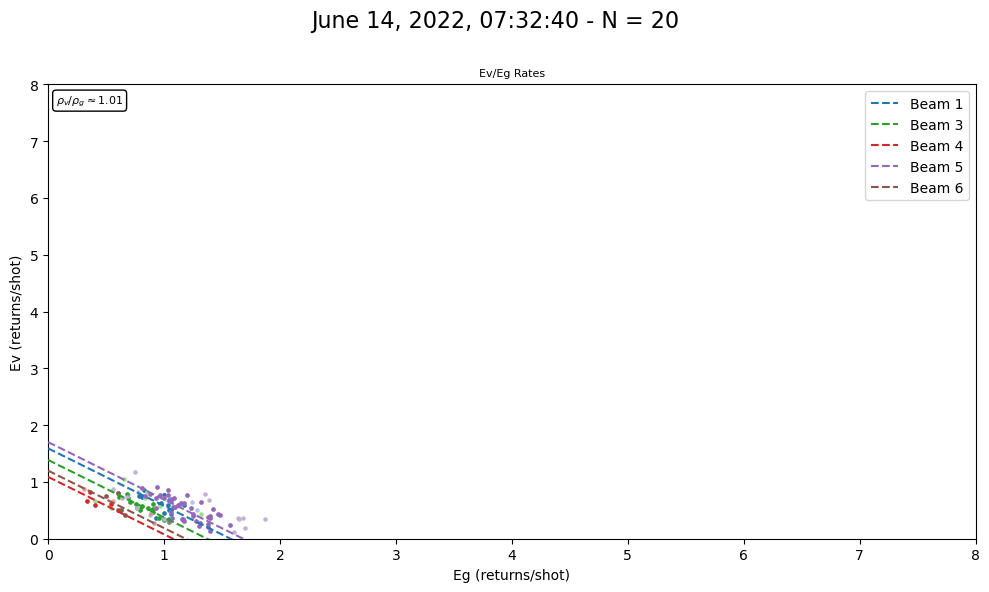

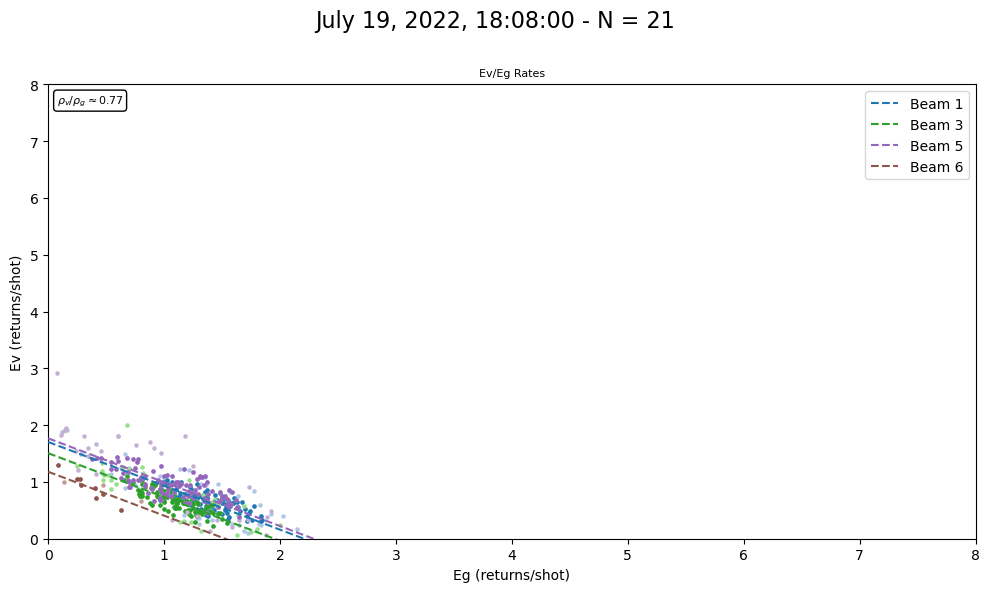

Nothing in rebinned section for oregon_yp file 22's beam 2.
Nothing in rebinned section for oregon_yp file 22's beam 3.
Nothing in rebinned section for oregon_yp file 22's beam 4.
Nothing in rebinned section for oregon_yp file 22's beam 5.
Nothing in rebinned section for oregon_yp file 22's beam 6.


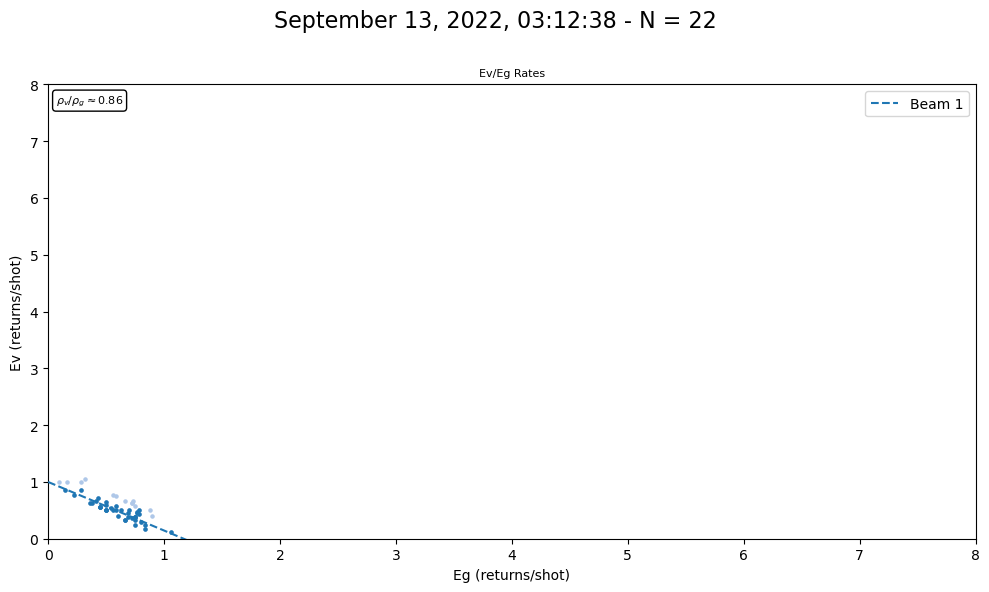

Nothing in rebinned section for oregon_yp file 23's beam 1.
Nothing in rebinned section for oregon_yp file 23's beam 2.
Nothing in rebinned section for oregon_yp file 23's beam 3.
Nothing in rebinned section for oregon_yp file 23's beam 4.
Nothing in rebinned section for oregon_yp file 23's beam 5.
Nothing in rebinned section for oregon_yp file 23's beam 6.
Nothing in rebinned section for oregon_yp file 24's beam 1.
Nothing in rebinned section for oregon_yp file 24's beam 2.


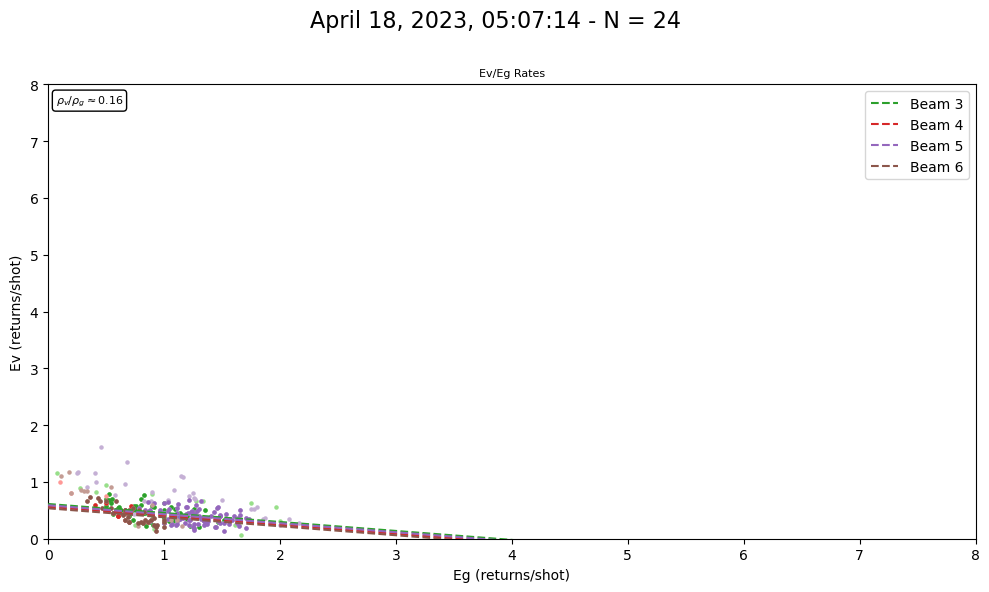

Nothing in rebinned section for oregon_yp file 25's beam 1.
Nothing in rebinned section for oregon_yp file 25's beam 2.


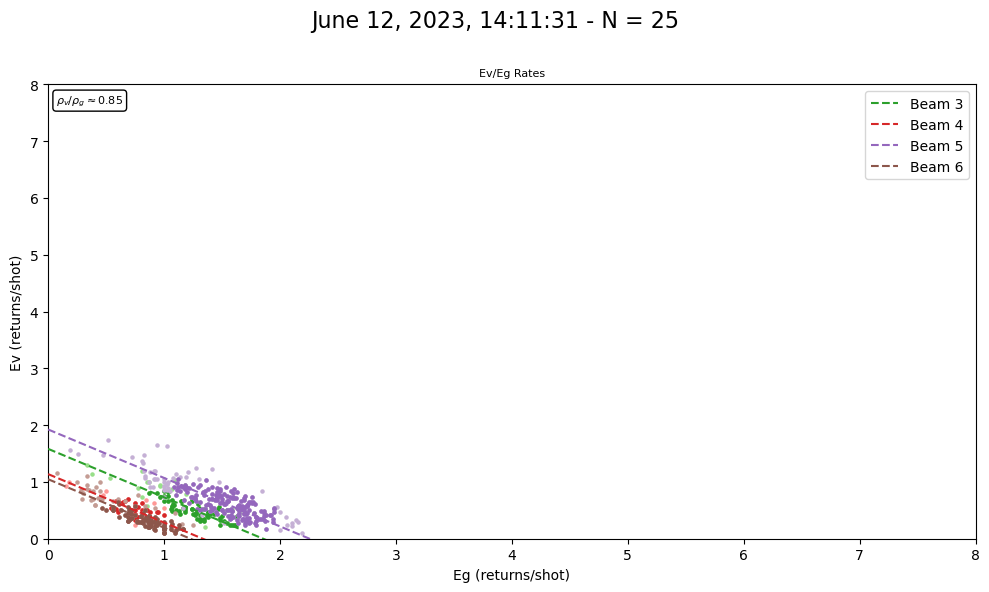

Nothing in rebinned section for oregon_yp file 26's beam 1.
Nothing in rebinned section for oregon_yp file 26's beam 2.
Nothing in rebinned section for oregon_yp file 26's beam 3.
Nothing in rebinned section for oregon_yp file 26's beam 4.
Nothing in rebinned section for oregon_yp file 26's beam 5.
Nothing in rebinned section for oregon_yp file 26's beam 6.
Nothing in rebinned section for oregon_yp file 27's beam 1.
Nothing in rebinned section for oregon_yp file 27's beam 2.
Nothing in rebinned section for oregon_yp file 27's beam 3.
Nothing in rebinned section for oregon_yp file 27's beam 4.
Nothing in rebinned section for oregon_yp file 27's beam 5.
Nothing in rebinned section for oregon_yp file 27's beam 6.
Nothing in rebinned section for oregon_yp file 28's beam 5.
Nothing in rebinned section for oregon_yp file 28's beam 6.


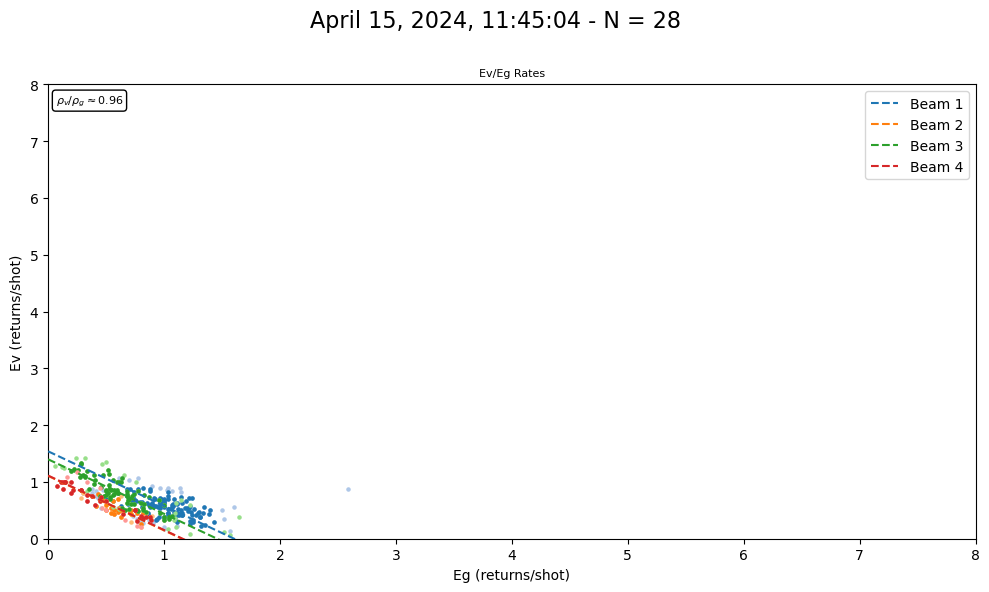

Nothing in rebinned section for oregon_yp file 29's beam 1.
Nothing in rebinned section for oregon_yp file 29's beam 2.


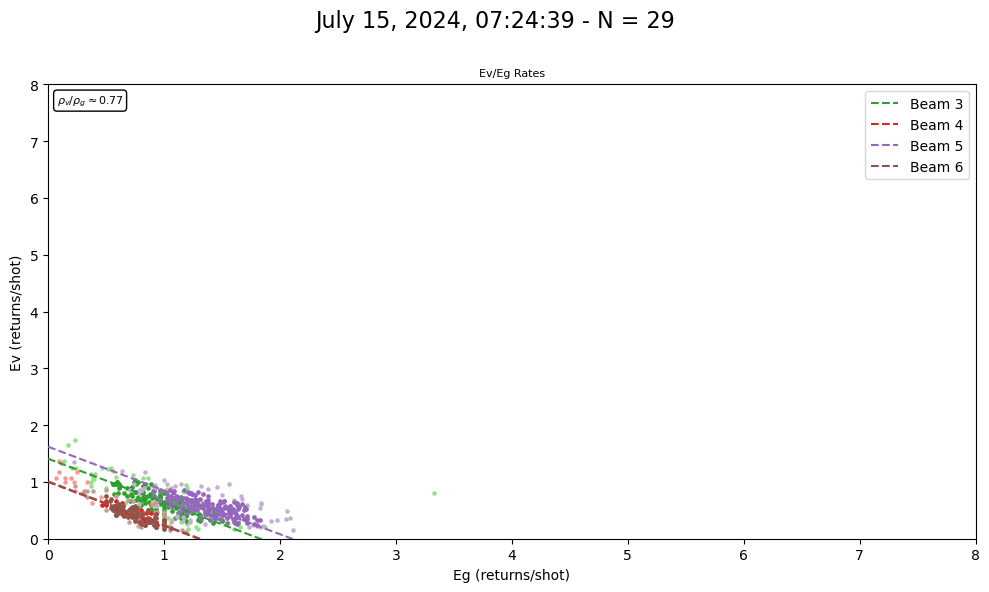

In [1]:
from scripts.parallel_blocks import *

dirpath = '../data_store/data/oregon_yp/'

all_ATL03, all_ATL08, failed_ATL03 = track_pairs(dirpath, failed=True)
N = len(all_ATL03)
print(N-1)

coords = (-121.606, 44.3238)

for i in range(N):
    data = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i], coords=coords, width=4,height=4,file_index=i, alt_thresh=80,\
                         altitude=977, threshold=1, small_box=8.05, graph_detail=1, loss='linear', rebinned=30, f_scale=.05,\
                         outlier_removal=.25,method='bimodal')